### Importing Libraries

In [1]:
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize

### Verifying the structure and dimentions of the data files

In [2]:
# Open the SSC dataset
ssc_ds = xr.open_dataset("Data/Processed_SSC_Data.nc")

# Print the SSC dataset
print("SSC Dataset:\n")
print(ssc_ds)
print("=" * 125)

# Open the wind dataset
wind_ds = xr.open_dataset("Data/Processed_Wind_Data.nc")

# Print the wind dataset
print("\nWind Dataset:\n")
print(wind_ds)
print("=" * 125)

# Close datasets after inspection
ssc_ds.close()
wind_ds.close()

SSC Dataset:

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 22, time: 2091)
Coordinates:
  * lat      (lat) float32 35.74 35.77 35.79 35.81 ... 36.21 36.23 36.26 36.28
  * lon      (lon) float32 13.92 13.96 14.0 14.04 ... 14.65 14.69 14.73 14.77
  * time     (time) datetime64[ns] 2021-01-01 2021-01-01T12:00:00 ... 2023-11-12
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  BARK (measured);POZZ (measured);
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 14:46:23
    NC_GLOBAL.grid_type:               REGULAR
    NC_

### Load Shapefile and Extract Coastline Boundaries

In [3]:
# Load the shapefile
shapefile_path = 'Data/land_sea_mask/MaltaCoastline.shp'
malta_coastline = gpd.read_file(shapefile_path)

# Assuming a roughly 3km per pixel resolution, calculate degree resolution approx
# For simplicity, we'll use the SSC dataset's extent and resolution as a reference
min_lon, max_lon = 13.9, 14.81
min_lat, max_lat = 35.6, 36.3

# Assuming the SSC dataset's grid dimensions to approximate grid size
grid_width = 22  # From SSC dataset lon dimension
grid_height = 25  # From SSC dataset lat dimension

# Determine grid resolution in degrees
lon_res = (max_lon - min_lon) / grid_width
lat_res = (max_lat - min_lat) / grid_height

# Create a transform for rasterization
transform = from_origin(min_lon, max_lat, lon_res, lat_res)

# Rasterize the shapefile
shapes = ((geom, 1) for geom in malta_coastline.geometry)
raster = rasterize(shapes=shapes, out_shape=(grid_height, grid_width), transform=transform, fill=0, all_touched=True, dtype='float32')

# Create longitude and latitude coordinates for the raster
lons = np.linspace(min_lon, max_lon - lon_res, grid_width)
lats = np.linspace(max_lat, min_lat + lat_res, grid_height)

# Convert the rasterized data to an xarray DataArray
land_sea_mask = xr.DataArray(raster, dims=['lat', 'lon'], coords={'lat': lats[::-1], 'lon': lons})

# Convert to xarray Dataset and assign variable name
ds = land_sea_mask.to_dataset(name='land_sea_mask')

# Define output path and save to NetCDF
output_nc_path = '/mnt/data/MaltaLandSeaMask.nc'
ds.to_netcdf(output_nc_path)

### Creating a FieldSet

In [4]:
# Initialize the FieldSet with ocean currents and wind data
fieldset = FieldSet.from_netcdf(
    filenames={
        "U": "Data/Processed_SSC_Data.nc",
        "V": "Data/Processed_SSC_Data.nc",
        "U_wind": "Data/Processed_Wind_Data.nc",
        "V_wind": "Data/Processed_Wind_Data.nc"
    },
    variables={
        "U": "u",
        "V": "v",
        "U_wind": "u10",
        "V_wind": "v10"
    },
    dimensions={
        "U": {"lon": "lon", "lat": "lat", "time": "time"},
        "V": {"lon": "lon", "lat": "lat", "time": "time"},
        "U_wind": {"lon": "longitude", "lat": "latitude", "time": "time"},
        "V_wind": {"lon": "longitude", "lat": "latitude", "time": "time"}
    },
    allow_time_extrapolation=True
)

# Load the land mask dataset and add it to the FieldSet
land_mask_ds = xr.open_dataset('Data/land_sea_mask/MaltaLandSeaMask.nc')
land_mask_field = Field.from_netcdf('Data/land_sea_mask/MaltaLandSeaMask.nc', variable='land_sea_mask', dimensions={'lon': 'lon', 'lat': 'lat'}, mesh='spherical', allow_time_extrapolation=True)
fieldset.add_field(land_mask_field)

### Initializing the Particles

In [5]:
## Given polygon boundaries
#boundaries = {
#    'min_lon': 13.9, 'max_lon': 14.81,
#    'min_lat': 35.6, 'max_lat': 36.3
#}
#
## Calculate center of the polygon
#center_lon = (boundaries['min_lon'] + boundaries['max_lon']) / 2
#center_lat = (boundaries['min_lat'] + boundaries['max_lat']) / 2
#
## Define a range within which particles will be released around the center
## This will be a smaller area in the very center of your polygon
#range_lon = (boundaries['max_lon'] - boundaries['min_lon']) / 10  # 10% of the total longitude range
#range_lat = (boundaries['max_lat'] - boundaries['min_lat']) / 10  # 10% of the total latitude range
#
## Number of particles to release
#num_particles = 20
#
## Generate random positions within the central area
#lat_release = np.random.uniform(center_lat - range_lat, center_lat + range_lat, num_particles)
#lon_release = np.random.uniform(center_lon - range_lon, center_lon + range_lon, num_particles)
#
## Create a ParticleSet with JITParticle
#pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon_release, lat=lat_release)

In [6]:
# Define polygon boundaries
boundaries = {
    'min_lon': 13.9, 'max_lon': 14.81,
    'min_lat': 35.6, 'max_lat': 36.3
}

# Adjusting the release points to be closer to the edges of the boundary
edge_buffer_lon = (boundaries['max_lon'] - boundaries['min_lon']) / 20  # 5% buffer from the longitude edges
edge_buffer_lat = (boundaries['max_lat'] - boundaries['min_lat']) / 20  # 5% buffer from the latitude edges

# Number of particles to release
num_particles = 20

# Generate positions close to the edges
lat_release_near_edges = np.concatenate([
    np.random.uniform(boundaries['min_lat'] + edge_buffer_lat, boundaries['min_lat'] + 2 * edge_buffer_lat, num_particles // 4),
    np.random.uniform(boundaries['max_lat'] - 2 * edge_buffer_lat, boundaries['max_lat'] - edge_buffer_lat, num_particles // 4)
])

lon_release_near_edges = np.concatenate([
    np.random.uniform(boundaries['min_lon'] + edge_buffer_lon, boundaries['min_lon'] + 2 * edge_buffer_lon, num_particles // 4),
    np.random.uniform(boundaries['max_lon'] - 2 * edge_buffer_lon, boundaries['max_lon'] - edge_buffer_lon, num_particles // 4)
])

# To ensure even distribution, shuffle the arrays
np.random.shuffle(lat_release_near_edges)
np.random.shuffle(lon_release_near_edges)

# Since we divided the particles into groups for each edge, we might need to adjust if num_particles is not a multiple of 4
# This is a simple fix to ensure we have exactly num_particles
lat_release = np.resize(lat_release_near_edges, num_particles)
lon_release = np.resize(lon_release_near_edges, num_particles)

# Create a ParticleSet with JITParticle positioned near the edges
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon_release, lat=lat_release)

### Define Simulation Parameters

In [7]:
# Define number of days for the simulation
runtime = timedelta(days=1046)  

#--------------------------------------------------------------------------------------------------------------------------

# Option 1: Fixed timestep (e.g., 10 minutes)
# dt = timedelta(minutes=12)

# Option 2: Timestep that aligns with your data intervals (e.g., 30 minutes or 1 hour)
#dt = timedelta(minutes=30)
dt = timedelta(hours=1)

# Option 3: If you want to use the exact timestep as your data
# dt = timedelta(hours=12)  # if your data interval is 12 hours

### Execute the Simulation

In [9]:
def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()
        
# Custom kernel to prevent particles from moving onto land
def AvoidLand(particle, fieldset, time):
    if fieldset.land_sea_mask[time, particle.depth, particle.lat, particle.lon] > 0.5:  # Assuming land is marked as 1
        particle.delete()        

# Execute the simulation
output_file = pset.ParticleFile(name="debris_simulation_output.zarr", outputdt=timedelta(minutes=60))  # Save output every hour
pset.execute(
    AdvectionRK4 + pset.Kernel(CheckOutOfBounds) + pset.Kernel(CheckError) + pset.Kernel(AvoidLand),  # Combine the advection kernel with the custom delete kernel
    runtime=runtime,
    dt=dt,
    output_file=output_file,
)

INFO: Output files are stored in debris_simulation_output.zarr.
  0%|          | 0/90374400.0 [00:00<?, ?it/s]WARNING: ParticleSet is empty on writing as array at time 0
  0%|          | 3600.0/90374400.0 [00:00<3:11:36, 7860.89it/s]WARNING: ParticleSet is empty on writing as array at time 3600
  0%|          | 43200.0/90374400.0 [00:00<16:20, 92122.87it/s]WARNING: ParticleSet is empty on writing as array at time 43200
  0%|          | 86400.0/90374400.0 [00:00<10:46, 139599.73it/s]WARNING: ParticleSet is empty on writing as array at time 86400
  0%|          | 129600.0/90374400.0 [00:00<08:05, 185797.38it/s]WARNING: ParticleSet is empty on writing as array at time 129600
  0%|          | 172800.0/90374400.0 [00:01<06:32, 229570.53it/s]WARNING: ParticleSet is empty on writing as array at time 172800
  0%|          | 216000.0/90374400.0 [00:01<05:30, 272508.16it/s]WARNING: ParticleSet is empty on writing as array at time 216000
  0%|          | 259200.0/90374400.0 [00:01<05:02, 298176.8

  0%|          | 432000.0/90374400.0 [00:01<05:22, 278690.79it/s]WARNING: ParticleSet is empty on writing as array at time 432000
  1%|          | 475200.0/90374400.0 [00:02<05:06, 293291.80it/s]WARNING: ParticleSet is empty on writing as array at time 475200
  1%|          | 518400.0/90374400.0 [00:02<05:07, 291799.40it/s]WARNING: ParticleSet is empty on writing as array at time 518400
  1%|          | 561600.0/90374400.0 [00:02<04:45, 314236.34it/s]WARNING: ParticleSet is empty on writing as array at time 561600
  1%|          | 604800.0/90374400.0 [00:02<04:28, 334317.44it/s]WARNING: ParticleSet is empty on writing as array at time 604800
  1%|          | 648000.0/90374400.0 [00:02<04:31, 330834.48it/s]WARNING: ParticleSet is empty on writing as array at time 648000
  1%|          | 691200.0/90374400.0 [00:02<04:51, 308055.64it/s]WARNING: ParticleSet is empty on writing as array at time 691200
  1%|          | 752400.0/90374400.0 [00:02<03:58, 376114.71it/s]WARNING: ParticleSet is e

  1%|          | 864000.0/90374400.0 [00:03<03:42, 402916.85it/s]WARNING: ParticleSet is empty on writing as array at time 864000
  1%|          | 932400.0/90374400.0 [00:03<03:09, 472847.57it/s]WARNING: ParticleSet is empty on writing as array at time 932400
  1%|          | 990000.0/90374400.0 [00:03<02:58, 499368.32it/s]WARNING: ParticleSet is empty on writing as array at time 990000
  1%|          | 1044000.0/90374400.0 [00:03<03:13, 460491.23it/s]WARNING: ParticleSet is empty on writing as array at time 1.044e+06
  1%|          | 1098000.0/90374400.0 [00:03<03:06, 479558.39it/s]WARNING: ParticleSet is empty on writing as array at time 1.098e+06
  1%|▏         | 1162800.0/90374400.0 [00:03<02:50, 522538.70it/s]WARNING: ParticleSet is empty on writing as array at time 1.1628e+06
  1%|▏         | 1216800.0/90374400.0 [00:03<03:10, 467164.43it/s]WARNING: ParticleSet is empty on writing as array at time 1.2168e+06


  1%|▏         | 1274400.0/90374400.0 [00:03<03:00, 493385.85it/s]WARNING: ParticleSet is empty on writing as array at time 1.2744e+06
  1%|▏         | 1332000.0/90374400.0 [00:03<02:55, 506404.59it/s]WARNING: ParticleSet is empty on writing as array at time 1.332e+06
  2%|▏         | 1386000.0/90374400.0 [00:04<03:25, 432484.30it/s]WARNING: ParticleSet is empty on writing as array at time 1.386e+06
  2%|▏         | 1432800.0/90374400.0 [00:04<03:22, 439778.13it/s]WARNING: ParticleSet is empty on writing as array at time 1.4328e+06
  2%|▏         | 1479600.0/90374400.0 [00:04<03:23, 437478.77it/s]WARNING: ParticleSet is empty on writing as array at time 1.4796e+06
  2%|▏         | 1530000.0/90374400.0 [00:04<03:15, 455184.08it/s]WARNING: ParticleSet is empty on writing as array at time 1.53e+06
  2%|▏         | 1594800.0/90374400.0 [00:04<02:56, 503384.33it/s]WARNING: ParticleSet is empty on writing as array at time 1.5948e+06
  2%|▏         | 1648800.0/90374400.0 [00:04<03:22, 437931.

  2%|▏         | 1695600.0/90374400.0 [00:04<05:08, 287879.22it/s]WARNING: ParticleSet is empty on writing as array at time 1.6956e+06
  2%|▏         | 1753200.0/90374400.0 [00:05<04:21, 339241.12it/s]WARNING: ParticleSet is empty on writing as array at time 1.7532e+06
  2%|▏         | 1814400.0/90374400.0 [00:05<04:08, 355856.99it/s]WARNING: ParticleSet is empty on writing as array at time 1.8144e+06
  2%|▏         | 1864800.0/90374400.0 [00:05<03:48, 387484.41it/s]WARNING: ParticleSet is empty on writing as array at time 1.8648e+06
  2%|▏         | 1911600.0/90374400.0 [00:05<04:03, 362766.85it/s]WARNING: ParticleSet is empty on writing as array at time 1.9116e+06
  2%|▏         | 1954800.0/90374400.0 [00:05<04:07, 357073.60it/s]WARNING: ParticleSet is empty on writing as array at time 1.9548e+06
  2%|▏         | 2008800.0/90374400.0 [00:05<03:41, 399424.98it/s]WARNING: ParticleSet is empty on writing as array at time 2.0088e+06
  2%|▏         | 2052000.0/90374400.0 [00:05<03:50, 382

  2%|▏         | 2095200.0/90374400.0 [00:06<04:17, 343035.33it/s]WARNING: ParticleSet is empty on writing as array at time 2.0952e+06
  2%|▏         | 2152800.0/90374400.0 [00:06<03:42, 396177.74it/s]WARNING: ParticleSet is empty on writing as array at time 2.1528e+06
  2%|▏         | 2203200.0/90374400.0 [00:06<03:52, 379116.70it/s]WARNING: ParticleSet is empty on writing as array at time 2.2032e+06
  2%|▏         | 2246400.0/90374400.0 [00:06<03:47, 386590.63it/s]WARNING: ParticleSet is empty on writing as array at time 2.2464e+06
  3%|▎         | 2289600.0/90374400.0 [00:06<03:50, 381563.60it/s]WARNING: ParticleSet is empty on writing as array at time 2.2896e+06
  3%|▎         | 2332800.0/90374400.0 [00:06<03:58, 369824.37it/s]WARNING: ParticleSet is empty on writing as array at time 2.3328e+06
  3%|▎         | 2376000.0/90374400.0 [00:06<04:06, 357065.60it/s]WARNING: ParticleSet is empty on writing as array at time 2.376e+06
  3%|▎         | 2426400.0/90374400.0 [00:06<03:46, 3889

  3%|▎         | 2469600.0/90374400.0 [00:06<03:42, 395961.46it/s]WARNING: ParticleSet is empty on writing as array at time 2.4696e+06
  3%|▎         | 2527200.0/90374400.0 [00:07<03:18, 442468.77it/s]WARNING: ParticleSet is empty on writing as array at time 2.5272e+06
  3%|▎         | 2588400.0/90374400.0 [00:07<02:59, 489466.12it/s]WARNING: ParticleSet is empty on writing as array at time 2.5884e+06
  3%|▎         | 2638800.0/90374400.0 [00:07<03:21, 434350.11it/s]WARNING: ParticleSet is empty on writing as array at time 2.6388e+06
  3%|▎         | 2700000.0/90374400.0 [00:07<03:03, 476827.93it/s]WARNING: ParticleSet is empty on writing as array at time 2.7e+06
  3%|▎         | 2764800.0/90374400.0 [00:07<03:12, 454215.04it/s]WARNING: ParticleSet is empty on writing as array at time 2.7648e+06
  3%|▎         | 2844000.0/90374400.0 [00:07<02:44, 530830.84it/s]WARNING: ParticleSet is empty on writing as array at time 2.844e+06


  3%|▎         | 2901600.0/90374400.0 [00:07<02:59, 486184.87it/s]WARNING: ParticleSet is empty on writing as array at time 2.9016e+06
  3%|▎         | 2955600.0/90374400.0 [00:07<02:56, 495814.21it/s]WARNING: ParticleSet is empty on writing as array at time 2.9556e+06
  3%|▎         | 3016800.0/90374400.0 [00:08<02:47, 522514.02it/s]WARNING: ParticleSet is empty on writing as array at time 3.0168e+06
  3%|▎         | 3070800.0/90374400.0 [00:08<03:12, 452569.56it/s]WARNING: ParticleSet is empty on writing as array at time 3.0708e+06
  3%|▎         | 3121200.0/90374400.0 [00:08<03:12, 452654.37it/s]WARNING: ParticleSet is empty on writing as array at time 3.1212e+06
  4%|▎         | 3171600.0/90374400.0 [00:08<03:12, 454095.99it/s]WARNING: ParticleSet is empty on writing as array at time 3.1716e+06
  4%|▎         | 3218400.0/90374400.0 [00:08<03:14, 447649.62it/s]WARNING: ParticleSet is empty on writing as array at time 3.2184e+06
  4%|▎         | 3265200.0/90374400.0 [00:08<03:16, 442

  4%|▎         | 3315600.0/90374400.0 [00:08<03:11, 455707.42it/s]WARNING: ParticleSet is empty on writing as array at time 3.3156e+06
  4%|▎         | 3362400.0/90374400.0 [00:08<03:09, 458258.86it/s]WARNING: ParticleSet is empty on writing as array at time 3.3624e+06
  4%|▍         | 3409200.0/90374400.0 [00:08<03:13, 449388.56it/s]WARNING: ParticleSet is empty on writing as array at time 3.4092e+06
  4%|▍         | 3456000.0/90374400.0 [00:09<04:28, 324241.62it/s]WARNING: ParticleSet is empty on writing as array at time 3.456e+06
  4%|▍         | 3506400.0/90374400.0 [00:09<04:01, 359346.65it/s]WARNING: ParticleSet is empty on writing as array at time 3.5064e+06
  4%|▍         | 3549600.0/90374400.0 [00:09<03:57, 366327.04it/s]WARNING: ParticleSet is empty on writing as array at time 3.5496e+06
  4%|▍         | 3592800.0/90374400.0 [00:09<04:22, 330908.98it/s]WARNING: ParticleSet is empty on writing as array at time 3.5928e+06
  4%|▍         | 3632400.0/90374400.0 [00:09<04:10, 3459

  5%|▍         | 4082400.0/90374400.0 [00:10<03:24, 422268.26it/s]WARNING: ParticleSet is empty on writing as array at time 4.0824e+06
  5%|▍         | 4136400.0/90374400.0 [00:10<03:10, 453677.00it/s]WARNING: ParticleSet is empty on writing as array at time 4.1364e+06
  5%|▍         | 4190400.0/90374400.0 [00:11<03:30, 409843.28it/s]WARNING: ParticleSet is empty on writing as array at time 4.1904e+06
  5%|▍         | 4258800.0/90374400.0 [00:11<03:01, 475447.87it/s]WARNING: ParticleSet is empty on writing as array at time 4.2588e+06
  5%|▍         | 4309200.0/90374400.0 [00:11<02:59, 479709.96it/s]WARNING: ParticleSet is empty on writing as array at time 4.3092e+06
  5%|▍         | 4359600.0/90374400.0 [00:11<03:04, 466487.68it/s]WARNING: ParticleSet is empty on writing as array at time 4.3596e+06
  5%|▍         | 4410000.0/90374400.0 [00:11<03:52, 369603.45it/s]WARNING: ParticleSet is empty on writing as array at time 4.41e+06
  5%|▍         | 4453200.0/90374400.0 [00:11<04:17, 33409

  5%|▍         | 4492800.0/90374400.0 [00:11<04:34, 313250.12it/s]WARNING: ParticleSet is empty on writing as array at time 4.4928e+06
  5%|▌         | 4557600.0/90374400.0 [00:12<03:43, 384804.19it/s]WARNING: ParticleSet is empty on writing as array at time 4.5576e+06
  5%|▌         | 4611600.0/90374400.0 [00:12<03:24, 418837.06it/s]WARNING: ParticleSet is empty on writing as array at time 4.6116e+06
  5%|▌         | 4662000.0/90374400.0 [00:12<03:16, 436975.82it/s]WARNING: ParticleSet is empty on writing as array at time 4.662e+06
  5%|▌         | 4708800.0/90374400.0 [00:12<04:23, 325690.60it/s]WARNING: ParticleSet is empty on writing as array at time 4.7088e+06
  5%|▌         | 4752000.0/90374400.0 [00:12<04:38, 307867.58it/s]WARNING: ParticleSet is empty on writing as array at time 4.752e+06
  5%|▌         | 4795200.0/90374400.0 [00:12<04:15, 334370.64it/s]WARNING: ParticleSet is empty on writing as array at time 4.7952e+06
  5%|▌         | 4845600.0/90374400.0 [00:12<03:49, 37266

  5%|▌         | 4914000.0/90374400.0 [00:13<03:11, 446014.60it/s]WARNING: ParticleSet is empty on writing as array at time 4.914e+06
  5%|▌         | 4968000.0/90374400.0 [00:13<03:30, 404888.10it/s]WARNING: ParticleSet is empty on writing as array at time 4.968e+06
  6%|▌         | 5014800.0/90374400.0 [00:13<03:42, 382917.19it/s]WARNING: ParticleSet is empty on writing as array at time 5.0148e+06
  6%|▌         | 5079600.0/90374400.0 [00:13<03:11, 445080.34it/s]WARNING: ParticleSet is empty on writing as array at time 5.0796e+06
  6%|▌         | 5130000.0/90374400.0 [00:13<03:19, 426508.72it/s]WARNING: ParticleSet is empty on writing as array at time 5.13e+06
  6%|▌         | 5176800.0/90374400.0 [00:13<03:35, 395186.80it/s]WARNING: ParticleSet is empty on writing as array at time 5.1768e+06
  6%|▌         | 5227200.0/90374400.0 [00:13<03:50, 370149.67it/s]WARNING: ParticleSet is empty on writing as array at time 5.2272e+06
  6%|▌         | 5270400.0/90374400.0 [00:13<03:41, 384340.

  6%|▌         | 5313600.0/90374400.0 [00:14<03:48, 372981.68it/s]WARNING: ParticleSet is empty on writing as array at time 5.3136e+06
  6%|▌         | 5367600.0/90374400.0 [00:14<03:25, 414000.88it/s]WARNING: ParticleSet is empty on writing as array at time 5.3676e+06
  6%|▌         | 5410800.0/90374400.0 [00:14<04:14, 334036.60it/s]WARNING: ParticleSet is empty on writing as array at time 5.4108e+06
  6%|▌         | 5450400.0/90374400.0 [00:14<04:14, 333273.72it/s]WARNING: ParticleSet is empty on writing as array at time 5.4504e+06
  6%|▌         | 5486400.0/90374400.0 [00:14<04:14, 333151.67it/s]WARNING: ParticleSet is empty on writing as array at time 5.4864e+06
  6%|▌         | 5529600.0/90374400.0 [00:14<04:20, 325161.86it/s]WARNING: ParticleSet is empty on writing as array at time 5.5296e+06
  6%|▌         | 5572800.0/90374400.0 [00:14<04:24, 320430.74it/s]WARNING: ParticleSet is empty on writing as array at time 5.5728e+06
  6%|▌         | 5616000.0/90374400.0 [00:14<04:18, 327

  6%|▋         | 5702400.0/90374400.0 [00:15<03:58, 355373.47it/s]WARNING: ParticleSet is empty on writing as array at time 5.7024e+06
  6%|▋         | 5745600.0/90374400.0 [00:15<03:57, 356611.94it/s]WARNING: ParticleSet is empty on writing as array at time 5.7456e+06
  6%|▋         | 5788800.0/90374400.0 [00:15<03:58, 355327.27it/s]WARNING: ParticleSet is empty on writing as array at time 5.7888e+06
  6%|▋         | 5832000.0/90374400.0 [00:15<04:16, 329339.57it/s]WARNING: ParticleSet is empty on writing as array at time 5.832e+06
  7%|▋         | 5875200.0/90374400.0 [00:15<04:30, 312702.10it/s]WARNING: ParticleSet is empty on writing as array at time 5.8752e+06
  7%|▋         | 5918400.0/90374400.0 [00:15<04:08, 339668.67it/s]WARNING: ParticleSet is empty on writing as array at time 5.9184e+06
  7%|▋         | 5961600.0/90374400.0 [00:15<03:52, 362861.22it/s]WARNING: ParticleSet is empty on writing as array at time 5.9616e+06
  7%|▋         | 6008400.0/90374400.0 [00:16<03:36, 3894

  7%|▋         | 6105600.0/90374400.0 [00:16<03:13, 435003.11it/s]WARNING: ParticleSet is empty on writing as array at time 6.1056e+06
  7%|▋         | 6163200.0/90374400.0 [00:16<02:58, 472044.33it/s]WARNING: ParticleSet is empty on writing as array at time 6.1632e+06
  7%|▋         | 6213600.0/90374400.0 [00:16<02:57, 474609.89it/s]WARNING: ParticleSet is empty on writing as array at time 6.2136e+06
  7%|▋         | 6264000.0/90374400.0 [00:16<04:14, 330583.04it/s]WARNING: ParticleSet is empty on writing as array at time 6.264e+06
  7%|▋         | 6307200.0/90374400.0 [00:16<04:08, 338171.88it/s]WARNING: ParticleSet is empty on writing as array at time 6.3072e+06
  7%|▋         | 6350400.0/90374400.0 [00:16<04:11, 333833.20it/s]WARNING: ParticleSet is empty on writing as array at time 6.3504e+06
  7%|▋         | 6393600.0/90374400.0 [00:17<04:25, 315996.13it/s]WARNING: ParticleSet is empty on writing as array at time 6.3936e+06
  7%|▋         | 6436800.0/90374400.0 [00:17<04:30, 3105

  7%|▋         | 6483600.0/90374400.0 [00:17<04:04, 342656.13it/s]WARNING: ParticleSet is empty on writing as array at time 6.4836e+06
  7%|▋         | 6523200.0/90374400.0 [00:17<04:03, 344440.53it/s]WARNING: ParticleSet is empty on writing as array at time 6.5232e+06
  7%|▋         | 6566400.0/90374400.0 [00:17<03:56, 354033.22it/s]WARNING: ParticleSet is empty on writing as array at time 6.5664e+06
  7%|▋         | 6609600.0/90374400.0 [00:17<03:45, 371983.12it/s]WARNING: ParticleSet is empty on writing as array at time 6.6096e+06
  7%|▋         | 6652800.0/90374400.0 [00:17<03:42, 375574.56it/s]WARNING: ParticleSet is empty on writing as array at time 6.6528e+06
  7%|▋         | 6696000.0/90374400.0 [00:17<03:39, 380933.74it/s]WARNING: ParticleSet is empty on writing as array at time 6.696e+06
  7%|▋         | 6739200.0/90374400.0 [00:18<03:34, 389094.96it/s]WARNING: ParticleSet is empty on writing as array at time 6.7392e+06
  8%|▊         | 6782400.0/90374400.0 [00:18<03:38, 3831

  8%|▊         | 6919200.0/90374400.0 [00:18<03:17, 423423.34it/s]WARNING: ParticleSet is empty on writing as array at time 6.9192e+06
  8%|▊         | 6962400.0/90374400.0 [00:18<03:23, 409038.43it/s]WARNING: ParticleSet is empty on writing as array at time 6.9624e+06
  8%|▊         | 7005600.0/90374400.0 [00:18<03:21, 413348.77it/s]WARNING: ParticleSet is empty on writing as array at time 7.0056e+06
  8%|▊         | 7056000.0/90374400.0 [00:18<03:10, 437303.97it/s]WARNING: ParticleSet is empty on writing as array at time 7.056e+06
  8%|▊         | 7102800.0/90374400.0 [00:18<03:24, 407493.99it/s]WARNING: ParticleSet is empty on writing as array at time 7.1028e+06
  8%|▊         | 7146000.0/90374400.0 [00:19<04:16, 324119.52it/s]WARNING: ParticleSet is empty on writing as array at time 7.146e+06
  8%|▊         | 7182000.0/90374400.0 [00:19<04:53, 283770.96it/s]WARNING: ParticleSet is empty on writing as array at time 7.182e+06
  8%|▊         | 7214400.0/90374400.0 [00:19<05:21, 258749

  8%|▊         | 7300800.0/90374400.0 [00:19<05:00, 276553.32it/s]WARNING: ParticleSet is empty on writing as array at time 7.3008e+06
  8%|▊         | 7344000.0/90374400.0 [00:19<04:45, 290758.83it/s]WARNING: ParticleSet is empty on writing as array at time 7.344e+06
  8%|▊         | 7387200.0/90374400.0 [00:19<04:18, 321625.41it/s]WARNING: ParticleSet is empty on writing as array at time 7.3872e+06
  8%|▊         | 7430400.0/90374400.0 [00:20<04:27, 310601.82it/s]WARNING: ParticleSet is empty on writing as array at time 7.4304e+06
  8%|▊         | 7473600.0/90374400.0 [00:20<04:26, 310776.82it/s]WARNING: ParticleSet is empty on writing as array at time 7.4736e+06
  8%|▊         | 7516800.0/90374400.0 [00:20<04:26, 310913.05it/s]WARNING: ParticleSet is empty on writing as array at time 7.5168e+06
  8%|▊         | 7560000.0/90374400.0 [00:20<04:15, 323627.10it/s]WARNING: ParticleSet is empty on writing as array at time 7.56e+06
  8%|▊         | 7606800.0/90374400.0 [00:20<03:54, 352792

  9%|▊         | 7689600.0/90374400.0 [00:20<03:44, 367600.92it/s]WARNING: ParticleSet is empty on writing as array at time 7.6896e+06
  9%|▊         | 7732800.0/90374400.0 [00:21<04:06, 334863.86it/s]WARNING: ParticleSet is empty on writing as array at time 7.7328e+06
  9%|▊         | 7776000.0/90374400.0 [00:21<04:25, 310586.37it/s]WARNING: ParticleSet is empty on writing as array at time 7.776e+06
  9%|▊         | 7819200.0/90374400.0 [00:21<04:13, 326130.21it/s]WARNING: ParticleSet is empty on writing as array at time 7.8192e+06
  9%|▊         | 7862400.0/90374400.0 [00:21<04:05, 336680.31it/s]WARNING: ParticleSet is empty on writing as array at time 7.8624e+06
  9%|▉         | 7909200.0/90374400.0 [00:21<03:43, 368989.90it/s]WARNING: ParticleSet is empty on writing as array at time 7.9092e+06
  9%|▉         | 7952400.0/90374400.0 [00:21<03:34, 384548.78it/s]WARNING: ParticleSet is empty on writing as array at time 7.9524e+06
  9%|▉         | 8002800.0/90374400.0 [00:21<03:19, 4131

  9%|▉         | 8092800.0/90374400.0 [00:22<04:31, 303374.74it/s]WARNING: ParticleSet is empty on writing as array at time 8.0928e+06
  9%|▉         | 8128800.0/90374400.0 [00:22<04:20, 315686.86it/s]WARNING: ParticleSet is empty on writing as array at time 8.1288e+06
  9%|▉         | 8172000.0/90374400.0 [00:22<04:01, 341015.66it/s]WARNING: ParticleSet is empty on writing as array at time 8.172e+06
  9%|▉         | 8211600.0/90374400.0 [00:22<03:59, 342818.42it/s]WARNING: ParticleSet is empty on writing as array at time 8.2116e+06
  9%|▉         | 8251200.0/90374400.0 [00:22<04:49, 283930.73it/s]WARNING: ParticleSet is empty on writing as array at time 8.2512e+06
  9%|▉         | 8294400.0/90374400.0 [00:22<04:36, 297371.21it/s]WARNING: ParticleSet is empty on writing as array at time 8.2944e+06
  9%|▉         | 8337600.0/90374400.0 [00:22<04:28, 305531.55it/s]WARNING: ParticleSet is empty on writing as array at time 8.3376e+06
  9%|▉         | 8380800.0/90374400.0 [00:22<04:25, 3088

  9%|▉         | 8510400.0/90374400.0 [00:23<03:48, 358390.01it/s]WARNING: ParticleSet is empty on writing as array at time 8.5104e+06
  9%|▉         | 8553600.0/90374400.0 [00:23<03:49, 357103.66it/s]WARNING: ParticleSet is empty on writing as array at time 8.5536e+06
 10%|▉         | 8596800.0/90374400.0 [00:23<03:55, 346616.31it/s]WARNING: ParticleSet is empty on writing as array at time 8.5968e+06
 10%|▉         | 8640000.0/90374400.0 [00:23<03:54, 348409.08it/s]WARNING: ParticleSet is empty on writing as array at time 8.64e+06
 10%|▉         | 8683200.0/90374400.0 [00:23<03:52, 351428.88it/s]WARNING: ParticleSet is empty on writing as array at time 8.6832e+06
 10%|▉         | 8726400.0/90374400.0 [00:23<03:53, 349493.75it/s]WARNING: ParticleSet is empty on writing as array at time 8.7264e+06
 10%|▉         | 8769600.0/90374400.0 [00:24<03:49, 355664.60it/s]WARNING: ParticleSet is empty on writing as array at time 8.7696e+06
 10%|▉         | 8812800.0/90374400.0 [00:24<03:45, 36147

 10%|▉         | 8899200.0/90374400.0 [00:24<03:50, 353319.75it/s]WARNING: ParticleSet is empty on writing as array at time 8.8992e+06
 10%|▉         | 8942400.0/90374400.0 [00:24<03:54, 347296.55it/s]WARNING: ParticleSet is empty on writing as array at time 8.9424e+06
 10%|▉         | 8985600.0/90374400.0 [00:24<03:42, 365634.44it/s]WARNING: ParticleSet is empty on writing as array at time 8.9856e+06
 10%|▉         | 9028800.0/90374400.0 [00:24<03:42, 365973.08it/s]WARNING: ParticleSet is empty on writing as array at time 9.0288e+06
 10%|█         | 9072000.0/90374400.0 [00:24<03:42, 365874.37it/s]WARNING: ParticleSet is empty on writing as array at time 9.072e+06
 10%|█         | 9115200.0/90374400.0 [00:25<04:12, 321245.16it/s]WARNING: ParticleSet is empty on writing as array at time 9.1152e+06
 10%|█         | 9158400.0/90374400.0 [00:25<04:22, 309659.28it/s]WARNING: ParticleSet is empty on writing as array at time 9.1584e+06
 10%|█         | 9201600.0/90374400.0 [00:25<04:41, 2885

 10%|█         | 9288000.0/90374400.0 [00:25<04:35, 293924.25it/s]WARNING: ParticleSet is empty on writing as array at time 9.288e+06
 10%|█         | 9331200.0/90374400.0 [00:25<04:18, 313736.52it/s]WARNING: ParticleSet is empty on writing as array at time 9.3312e+06
 10%|█         | 9374400.0/90374400.0 [00:25<04:10, 323466.58it/s]WARNING: ParticleSet is empty on writing as array at time 9.3744e+06
 10%|█         | 9417600.0/90374400.0 [00:26<04:00, 336443.52it/s]WARNING: ParticleSet is empty on writing as array at time 9.4176e+06
 10%|█         | 9460800.0/90374400.0 [00:26<03:56, 342786.76it/s]WARNING: ParticleSet is empty on writing as array at time 9.4608e+06
 11%|█         | 9504000.0/90374400.0 [00:26<03:56, 342367.40it/s]WARNING: ParticleSet is empty on writing as array at time 9.504e+06
 11%|█         | 9547200.0/90374400.0 [00:26<03:59, 337349.45it/s]WARNING: ParticleSet is empty on writing as array at time 9.5472e+06
 11%|█         | 9590400.0/90374400.0 [00:26<03:50, 35056

 11%|█         | 9676800.0/90374400.0 [00:26<04:06, 327313.71it/s]WARNING: ParticleSet is empty on writing as array at time 9.6768e+06
 11%|█         | 9720000.0/90374400.0 [00:26<04:12, 319093.98it/s]WARNING: ParticleSet is empty on writing as array at time 9.72e+06
 11%|█         | 9763200.0/90374400.0 [00:27<04:09, 322962.06it/s]WARNING: ParticleSet is empty on writing as array at time 9.7632e+06
 11%|█         | 9806400.0/90374400.0 [00:27<04:18, 311900.64it/s]WARNING: ParticleSet is empty on writing as array at time 9.8064e+06
 11%|█         | 9849600.0/90374400.0 [00:27<04:42, 284840.56it/s]WARNING: ParticleSet is empty on writing as array at time 9.8496e+06
 11%|█         | 9892800.0/90374400.0 [00:27<04:27, 301276.70it/s]WARNING: ParticleSet is empty on writing as array at time 9.8928e+06
 11%|█         | 9936000.0/90374400.0 [00:27<04:08, 323248.64it/s]WARNING: ParticleSet is empty on writing as array at time 9.936e+06
 11%|█         | 9979200.0/90374400.0 [00:27<04:02, 332151

 11%|█         | 10108800.0/90374400.0 [00:28<03:33, 376813.74it/s]WARNING: ParticleSet is empty on writing as array at time 1.01088e+07
 11%|█         | 10152000.0/90374400.0 [00:28<03:25, 390830.76it/s]WARNING: ParticleSet is empty on writing as array at time 1.0152e+07
 11%|█▏        | 10202400.0/90374400.0 [00:28<03:10, 420028.51it/s]WARNING: ParticleSet is empty on writing as array at time 1.02024e+07
 11%|█▏        | 10245600.0/90374400.0 [00:28<03:19, 401724.27it/s]WARNING: ParticleSet is empty on writing as array at time 1.02456e+07
 11%|█▏        | 10288800.0/90374400.0 [00:28<03:18, 402498.94it/s]WARNING: ParticleSet is empty on writing as array at time 1.02888e+07
 11%|█▏        | 10332000.0/90374400.0 [00:28<03:18, 402854.59it/s]WARNING: ParticleSet is empty on writing as array at time 1.0332e+07
 11%|█▏        | 10375200.0/90374400.0 [00:28<03:20, 398446.40it/s]WARNING: ParticleSet is empty on writing as array at time 1.03752e+07
 12%|█▏        | 10418400.0/90374400.0 [00:

 12%|█▏        | 10857600.0/90374400.0 [00:29<03:16, 405563.11it/s]WARNING: ParticleSet is empty on writing as array at time 1.08576e+07
 12%|█▏        | 10900800.0/90374400.0 [00:30<03:16, 405327.58it/s]WARNING: ParticleSet is empty on writing as array at time 1.09008e+07
 12%|█▏        | 10951200.0/90374400.0 [00:30<03:03, 432541.40it/s]WARNING: ParticleSet is empty on writing as array at time 1.09512e+07
 12%|█▏        | 11001600.0/90374400.0 [00:30<02:56, 450427.52it/s]WARNING: ParticleSet is empty on writing as array at time 1.10016e+07
 12%|█▏        | 11052000.0/90374400.0 [00:30<02:52, 460429.45it/s]WARNING: ParticleSet is empty on writing as array at time 1.1052e+07
 12%|█▏        | 11098800.0/90374400.0 [00:30<02:53, 455767.39it/s]WARNING: ParticleSet is empty on writing as array at time 1.10988e+07
 12%|█▏        | 11145600.0/90374400.0 [00:30<03:29, 377878.87it/s]WARNING: ParticleSet is empty on writing as array at time 1.11456e+07
 12%|█▏        | 11188800.0/90374400.0 [00

 12%|█▏        | 11278800.0/90374400.0 [00:30<03:12, 410680.19it/s]WARNING: ParticleSet is empty on writing as array at time 1.12788e+07
 13%|█▎        | 11322000.0/90374400.0 [00:31<03:15, 404340.00it/s]WARNING: ParticleSet is empty on writing as array at time 1.1322e+07
 13%|█▎        | 11365200.0/90374400.0 [00:31<03:14, 406933.64it/s]WARNING: ParticleSet is empty on writing as array at time 1.13652e+07
 13%|█▎        | 11408400.0/90374400.0 [00:31<03:14, 406101.15it/s]WARNING: ParticleSet is empty on writing as array at time 1.14084e+07
 13%|█▎        | 11451600.0/90374400.0 [00:31<03:28, 379416.48it/s]WARNING: ParticleSet is empty on writing as array at time 1.14516e+07
 13%|█▎        | 11491200.0/90374400.0 [00:31<03:40, 357752.44it/s]WARNING: ParticleSet is empty on writing as array at time 1.14912e+07
 13%|█▎        | 11534400.0/90374400.0 [00:31<03:42, 355112.03it/s]WARNING: ParticleSet is empty on writing as array at time 1.15344e+07
 13%|█▎        | 11577600.0/90374400.0 [00

 13%|█▎        | 11664000.0/90374400.0 [00:31<03:35, 364936.07it/s]WARNING: ParticleSet is empty on writing as array at time 1.1664e+07
 13%|█▎        | 11707200.0/90374400.0 [00:32<03:36, 364146.96it/s]WARNING: ParticleSet is empty on writing as array at time 1.17072e+07
 13%|█▎        | 11750400.0/90374400.0 [00:32<03:40, 356318.70it/s]WARNING: ParticleSet is empty on writing as array at time 1.17504e+07
 13%|█▎        | 11793600.0/90374400.0 [00:32<03:41, 355259.90it/s]WARNING: ParticleSet is empty on writing as array at time 1.17936e+07
 13%|█▎        | 11836800.0/90374400.0 [00:32<03:51, 338852.87it/s]WARNING: ParticleSet is empty on writing as array at time 1.18368e+07
 13%|█▎        | 11880000.0/90374400.0 [00:32<03:51, 338652.77it/s]WARNING: ParticleSet is empty on writing as array at time 1.188e+07
 13%|█▎        | 11923200.0/90374400.0 [00:32<03:48, 343081.49it/s]WARNING: ParticleSet is empty on writing as array at time 1.19232e+07
 13%|█▎        | 11966400.0/90374400.0 [00:3

 13%|█▎        | 12052800.0/90374400.0 [00:33<05:22, 243029.67it/s]WARNING: ParticleSet is empty on writing as array at time 1.20528e+07
 13%|█▎        | 12096000.0/90374400.0 [00:33<04:58, 262303.02it/s]WARNING: ParticleSet is empty on writing as array at time 1.2096e+07
 13%|█▎        | 12139200.0/90374400.0 [00:33<04:35, 284242.84it/s]WARNING: ParticleSet is empty on writing as array at time 1.21392e+07
 13%|█▎        | 12182400.0/90374400.0 [00:33<04:23, 296297.66it/s]WARNING: ParticleSet is empty on writing as array at time 1.21824e+07
 14%|█▎        | 12225600.0/90374400.0 [00:33<04:08, 314920.30it/s]WARNING: ParticleSet is empty on writing as array at time 1.22256e+07
 14%|█▎        | 12268800.0/90374400.0 [00:33<03:55, 331886.28it/s]WARNING: ParticleSet is empty on writing as array at time 1.22688e+07
 14%|█▎        | 12312000.0/90374400.0 [00:34<03:42, 351190.66it/s]WARNING: ParticleSet is empty on writing as array at time 1.2312e+07
 14%|█▎        | 12362400.0/90374400.0 [00:

 14%|█▍        | 12463200.0/90374400.0 [00:34<03:02, 426855.93it/s]WARNING: ParticleSet is empty on writing as array at time 1.24632e+07
 14%|█▍        | 12510000.0/90374400.0 [00:34<03:13, 403312.93it/s]WARNING: ParticleSet is empty on writing as array at time 1.251e+07
 14%|█▍        | 12553200.0/90374400.0 [00:34<03:25, 379119.94it/s]WARNING: ParticleSet is empty on writing as array at time 1.25532e+07
 14%|█▍        | 12592800.0/90374400.0 [00:34<03:39, 354651.57it/s]WARNING: ParticleSet is empty on writing as array at time 1.25928e+07
 14%|█▍        | 12632400.0/90374400.0 [00:34<03:50, 337124.09it/s]WARNING: ParticleSet is empty on writing as array at time 1.26324e+07
 14%|█▍        | 12668400.0/90374400.0 [00:35<04:14, 305440.21it/s]WARNING: ParticleSet is empty on writing as array at time 1.26684e+07
 14%|█▍        | 12700800.0/90374400.0 [00:35<04:24, 294070.06it/s]WARNING: ParticleSet is empty on writing as array at time 1.27008e+07
 14%|█▍        | 12747600.0/90374400.0 [00:

 14%|█▍        | 12844800.0/90374400.0 [00:35<03:10, 406465.55it/s]WARNING: ParticleSet is empty on writing as array at time 1.28448e+07
 14%|█▍        | 12888000.0/90374400.0 [00:35<03:35, 358889.06it/s]WARNING: ParticleSet is empty on writing as array at time 1.2888e+07
 14%|█▍        | 12927600.0/90374400.0 [00:35<04:05, 315416.75it/s]WARNING: ParticleSet is empty on writing as array at time 1.29276e+07
 14%|█▍        | 12963600.0/90374400.0 [00:35<04:19, 297939.35it/s]WARNING: ParticleSet is empty on writing as array at time 1.29636e+07
 14%|█▍        | 13003200.0/90374400.0 [00:36<04:17, 300409.98it/s]WARNING: ParticleSet is empty on writing as array at time 1.30032e+07
 14%|█▍        | 13046400.0/90374400.0 [00:36<04:16, 301654.97it/s]WARNING: ParticleSet is empty on writing as array at time 1.30464e+07
 14%|█▍        | 13089600.0/90374400.0 [00:36<04:20, 296710.97it/s]WARNING: ParticleSet is empty on writing as array at time 1.30896e+07
 15%|█▍        | 13132800.0/90374400.0 [00

 15%|█▍        | 13230000.0/90374400.0 [00:36<03:17, 390349.39it/s]WARNING: ParticleSet is empty on writing as array at time 1.323e+07
 15%|█▍        | 13284000.0/90374400.0 [00:36<02:59, 429850.71it/s]WARNING: ParticleSet is empty on writing as array at time 1.3284e+07
 15%|█▍        | 13341600.0/90374400.0 [00:36<02:46, 463044.52it/s]WARNING: ParticleSet is empty on writing as array at time 1.33416e+07
 15%|█▍        | 13392000.0/90374400.0 [00:37<03:02, 422258.01it/s]WARNING: ParticleSet is empty on writing as array at time 1.3392e+07
 15%|█▍        | 13449600.0/90374400.0 [00:37<02:49, 454229.89it/s]WARNING: ParticleSet is empty on writing as array at time 1.34496e+07
 15%|█▍        | 13503600.0/90374400.0 [00:37<02:41, 475189.39it/s]WARNING: ParticleSet is empty on writing as array at time 1.35036e+07
 15%|█▍        | 13554000.0/90374400.0 [00:37<02:40, 478819.95it/s]WARNING: ParticleSet is empty on writing as array at time 1.3554e+07
 15%|█▌        | 13604400.0/90374400.0 [00:37<

 16%|█▌        | 14011200.0/90374400.0 [00:38<03:14, 393260.99it/s]WARNING: ParticleSet is empty on writing as array at time 1.40112e+07
 16%|█▌        | 14054400.0/90374400.0 [00:38<03:10, 401477.32it/s]WARNING: ParticleSet is empty on writing as array at time 1.40544e+07
 16%|█▌        | 14097600.0/90374400.0 [00:38<03:07, 407455.76it/s]WARNING: ParticleSet is empty on writing as array at time 1.40976e+07
 16%|█▌        | 14140800.0/90374400.0 [00:38<03:24, 373239.83it/s]WARNING: ParticleSet is empty on writing as array at time 1.41408e+07
 16%|█▌        | 14180400.0/90374400.0 [00:39<03:29, 364152.87it/s]WARNING: ParticleSet is empty on writing as array at time 1.41804e+07
 16%|█▌        | 14223600.0/90374400.0 [00:39<03:20, 380646.60it/s]WARNING: ParticleSet is empty on writing as array at time 1.42236e+07
 16%|█▌        | 14266800.0/90374400.0 [00:39<03:13, 393818.57it/s]WARNING: ParticleSet is empty on writing as array at time 1.42668e+07
 16%|█▌        | 14320800.0/90374400.0 [0

 16%|█▌        | 14414400.0/90374400.0 [00:39<02:52, 439508.98it/s]WARNING: ParticleSet is empty on writing as array at time 1.44144e+07
 16%|█▌        | 14461200.0/90374400.0 [00:39<02:52, 440926.59it/s]WARNING: ParticleSet is empty on writing as array at time 1.44612e+07
 16%|█▌        | 14511600.0/90374400.0 [00:39<02:47, 452052.34it/s]WARNING: ParticleSet is empty on writing as array at time 1.45116e+07
 16%|█▌        | 14558400.0/90374400.0 [00:39<03:19, 379933.17it/s]WARNING: ParticleSet is empty on writing as array at time 1.45584e+07
 16%|█▌        | 14601600.0/90374400.0 [00:40<03:14, 390394.02it/s]WARNING: ParticleSet is empty on writing as array at time 1.46016e+07
 16%|█▌        | 14644800.0/90374400.0 [00:40<03:09, 400610.44it/s]WARNING: ParticleSet is empty on writing as array at time 1.46448e+07
 16%|█▋        | 14698800.0/90374400.0 [00:40<02:52, 438604.07it/s]WARNING: ParticleSet is empty on writing as array at time 1.46988e+07
 16%|█▋        | 14749200.0/90374400.0 [0

 16%|█▋        | 14796000.0/90374400.0 [00:40<02:46, 454009.73it/s]WARNING: ParticleSet is empty on writing as array at time 1.4796e+07
 16%|█▋        | 14842800.0/90374400.0 [00:40<02:49, 444846.20it/s]WARNING: ParticleSet is empty on writing as array at time 1.48428e+07
 16%|█▋        | 14889600.0/90374400.0 [00:40<02:47, 451414.20it/s]WARNING: ParticleSet is empty on writing as array at time 1.48896e+07
 17%|█▋        | 14936400.0/90374400.0 [00:40<02:46, 453728.70it/s]WARNING: ParticleSet is empty on writing as array at time 1.49364e+07
 17%|█▋        | 14986800.0/90374400.0 [00:40<02:42, 464069.75it/s]WARNING: ParticleSet is empty on writing as array at time 1.49868e+07
 17%|█▋        | 15033600.0/90374400.0 [00:41<03:07, 400933.39it/s]WARNING: ParticleSet is empty on writing as array at time 1.50336e+07
 17%|█▋        | 15084000.0/90374400.0 [00:41<02:56, 426216.92it/s]WARNING: ParticleSet is empty on writing as array at time 1.5084e+07
 17%|█▋        | 15130800.0/90374400.0 [00:

 17%|█▋        | 15181200.0/90374400.0 [00:41<02:46, 451915.84it/s]WARNING: ParticleSet is empty on writing as array at time 1.51812e+07
 17%|█▋        | 15228000.0/90374400.0 [00:41<02:52, 436823.85it/s]WARNING: ParticleSet is empty on writing as array at time 1.5228e+07
 17%|█▋        | 15274800.0/90374400.0 [00:41<02:51, 438866.96it/s]WARNING: ParticleSet is empty on writing as array at time 1.52748e+07
 17%|█▋        | 15325200.0/90374400.0 [00:41<02:45, 454212.42it/s]WARNING: ParticleSet is empty on writing as array at time 1.53252e+07
 17%|█▋        | 15372000.0/90374400.0 [00:41<02:44, 457225.86it/s]WARNING: ParticleSet is empty on writing as array at time 1.5372e+07
 17%|█▋        | 15418800.0/90374400.0 [00:41<02:44, 454764.17it/s]WARNING: ParticleSet is empty on writing as array at time 1.54188e+07
 17%|█▋        | 15465600.0/90374400.0 [00:42<03:14, 384322.68it/s]WARNING: ParticleSet is empty on writing as array at time 1.54656e+07
 17%|█▋        | 15516000.0/90374400.0 [00:

 17%|█▋        | 15624000.0/90374400.0 [00:42<02:38, 471547.84it/s]WARNING: ParticleSet is empty on writing as array at time 1.5624e+07
 17%|█▋        | 15674400.0/90374400.0 [00:42<02:35, 479436.42it/s]WARNING: ParticleSet is empty on writing as array at time 1.56744e+07
 17%|█▋        | 15724800.0/90374400.0 [00:42<03:00, 413934.57it/s]WARNING: ParticleSet is empty on writing as array at time 1.57248e+07
 17%|█▋        | 15771600.0/90374400.0 [00:42<02:54, 427753.72it/s]WARNING: ParticleSet is empty on writing as array at time 1.57716e+07
 18%|█▊        | 15825600.0/90374400.0 [00:42<02:43, 455814.64it/s]WARNING: ParticleSet is empty on writing as array at time 1.58256e+07
 18%|█▊        | 15876000.0/90374400.0 [00:42<02:39, 467168.65it/s]WARNING: ParticleSet is empty on writing as array at time 1.5876e+07
 18%|█▊        | 15926400.0/90374400.0 [00:42<02:36, 476214.41it/s]WARNING: ParticleSet is empty on writing as array at time 1.59264e+07


 18%|█▊        | 15980400.0/90374400.0 [00:43<02:31, 490880.39it/s]WARNING: ParticleSet is empty on writing as array at time 1.59804e+07
 18%|█▊        | 16030800.0/90374400.0 [00:43<02:51, 433555.40it/s]WARNING: ParticleSet is empty on writing as array at time 1.60308e+07
 18%|█▊        | 16077600.0/90374400.0 [00:43<02:51, 433187.34it/s]WARNING: ParticleSet is empty on writing as array at time 1.60776e+07
 18%|█▊        | 16131600.0/90374400.0 [00:43<02:41, 458666.68it/s]WARNING: ParticleSet is empty on writing as array at time 1.61316e+07
 18%|█▊        | 16182000.0/90374400.0 [00:43<02:40, 461727.13it/s]WARNING: ParticleSet is empty on writing as array at time 1.6182e+07
 18%|█▊        | 16232400.0/90374400.0 [00:43<02:39, 466013.42it/s]WARNING: ParticleSet is empty on writing as array at time 1.62324e+07
 18%|█▊        | 16282800.0/90374400.0 [00:43<02:37, 470993.72it/s]WARNING: ParticleSet is empty on writing as array at time 1.62828e+07
 18%|█▊        | 16333200.0/90374400.0 [00

 18%|█▊        | 16383600.0/90374400.0 [00:44<02:53, 427029.60it/s]WARNING: ParticleSet is empty on writing as array at time 1.63836e+07
 18%|█▊        | 16430400.0/90374400.0 [00:44<02:49, 435492.49it/s]WARNING: ParticleSet is empty on writing as array at time 1.64304e+07
 18%|█▊        | 16480800.0/90374400.0 [00:44<02:42, 453365.63it/s]WARNING: ParticleSet is empty on writing as array at time 1.64808e+07
 18%|█▊        | 16527600.0/90374400.0 [00:44<02:41, 456351.18it/s]WARNING: ParticleSet is empty on writing as array at time 1.65276e+07
 18%|█▊        | 16574400.0/90374400.0 [00:44<02:46, 442334.82it/s]WARNING: ParticleSet is empty on writing as array at time 1.65744e+07
 18%|█▊        | 16621200.0/90374400.0 [00:44<03:42, 331553.60it/s]WARNING: ParticleSet is empty on writing as array at time 1.66212e+07
 18%|█▊        | 16675200.0/90374400.0 [00:44<03:42, 330724.82it/s]WARNING: ParticleSet is empty on writing as array at time 1.66752e+07
 19%|█▊        | 16725600.0/90374400.0 [0

 19%|█▊        | 16768800.0/90374400.0 [00:45<03:18, 371054.96it/s]WARNING: ParticleSet is empty on writing as array at time 1.67688e+07
 19%|█▊        | 16815600.0/90374400.0 [00:45<03:07, 393286.74it/s]WARNING: ParticleSet is empty on writing as array at time 1.68156e+07
 19%|█▊        | 16858800.0/90374400.0 [00:45<03:05, 397255.32it/s]WARNING: ParticleSet is empty on writing as array at time 1.68588e+07
 19%|█▊        | 16905600.0/90374400.0 [00:45<02:56, 416147.05it/s]WARNING: ParticleSet is empty on writing as array at time 1.69056e+07
 19%|█▉        | 16948800.0/90374400.0 [00:45<02:54, 420387.59it/s]WARNING: ParticleSet is empty on writing as array at time 1.69488e+07
 19%|█▉        | 16992000.0/90374400.0 [00:45<02:53, 422019.85it/s]WARNING: ParticleSet is empty on writing as array at time 1.6992e+07
 19%|█▉        | 17046000.0/90374400.0 [00:45<02:41, 454854.46it/s]WARNING: ParticleSet is empty on writing as array at time 1.7046e+07
 19%|█▉        | 17092800.0/90374400.0 [00:

 19%|█▉        | 17175600.0/90374400.0 [00:46<03:12, 380398.95it/s]WARNING: ParticleSet is empty on writing as array at time 1.71756e+07
 19%|█▉        | 17226000.0/90374400.0 [00:46<02:58, 410562.45it/s]WARNING: ParticleSet is empty on writing as array at time 1.7226e+07
 19%|█▉        | 17280000.0/90374400.0 [00:46<03:07, 389141.70it/s]WARNING: ParticleSet is empty on writing as array at time 1.728e+07
 19%|█▉        | 17323200.0/90374400.0 [00:46<03:17, 370517.32it/s]WARNING: ParticleSet is empty on writing as array at time 1.73232e+07
 19%|█▉        | 17366400.0/90374400.0 [00:46<03:41, 330055.07it/s]WARNING: ParticleSet is empty on writing as array at time 1.73664e+07
 19%|█▉        | 17409600.0/90374400.0 [00:46<03:38, 333474.74it/s]WARNING: ParticleSet is empty on writing as array at time 1.74096e+07
 19%|█▉        | 17456400.0/90374400.0 [00:46<03:21, 361779.64it/s]WARNING: ParticleSet is empty on writing as array at time 1.74564e+07
 19%|█▉        | 17496000.0/90374400.0 [00:4

 19%|█▉        | 17586000.0/90374400.0 [00:47<03:07, 387179.96it/s]WARNING: ParticleSet is empty on writing as array at time 1.7586e+07
 20%|█▉        | 17625600.0/90374400.0 [00:47<03:25, 354184.72it/s]WARNING: ParticleSet is empty on writing as array at time 1.76256e+07
 20%|█▉        | 17668800.0/90374400.0 [00:47<03:21, 360388.40it/s]WARNING: ParticleSet is empty on writing as array at time 1.76688e+07
 20%|█▉        | 17715600.0/90374400.0 [00:47<03:07, 387024.56it/s]WARNING: ParticleSet is empty on writing as array at time 1.77156e+07
 20%|█▉        | 17755200.0/90374400.0 [00:47<03:07, 387060.49it/s]WARNING: ParticleSet is empty on writing as array at time 1.77552e+07
 20%|█▉        | 17798400.0/90374400.0 [00:47<03:04, 393847.81it/s]WARNING: ParticleSet is empty on writing as array at time 1.77984e+07
 20%|█▉        | 17841600.0/90374400.0 [00:47<03:03, 395318.66it/s]WARNING: ParticleSet is empty on writing as array at time 1.78416e+07
 20%|█▉        | 17888400.0/90374400.0 [00

 20%|█▉        | 17989200.0/90374400.0 [00:48<02:40, 452052.91it/s]WARNING: ParticleSet is empty on writing as array at time 1.79892e+07
 20%|█▉        | 18036000.0/90374400.0 [00:48<02:42, 446077.21it/s]WARNING: ParticleSet is empty on writing as array at time 1.8036e+07
 20%|██        | 18082800.0/90374400.0 [00:48<02:40, 451352.04it/s]WARNING: ParticleSet is empty on writing as array at time 1.80828e+07
 20%|██        | 18129600.0/90374400.0 [00:48<02:41, 446904.65it/s]WARNING: ParticleSet is empty on writing as array at time 1.81296e+07
 20%|██        | 18176400.0/90374400.0 [00:48<02:48, 428728.61it/s]WARNING: ParticleSet is empty on writing as array at time 1.81764e+07
 20%|██        | 18219600.0/90374400.0 [00:48<02:54, 413118.97it/s]WARNING: ParticleSet is empty on writing as array at time 1.82196e+07
 20%|██        | 18262800.0/90374400.0 [00:48<02:53, 414764.07it/s]WARNING: ParticleSet is empty on writing as array at time 1.82628e+07
 20%|██        | 18306000.0/90374400.0 [00

 20%|██        | 18349200.0/90374400.0 [00:48<02:55, 411098.46it/s]WARNING: ParticleSet is empty on writing as array at time 1.83492e+07
 20%|██        | 18392400.0/90374400.0 [00:49<03:21, 357316.44it/s]WARNING: ParticleSet is empty on writing as array at time 1.83924e+07
 20%|██        | 18432000.0/90374400.0 [00:49<03:40, 326444.41it/s]WARNING: ParticleSet is empty on writing as array at time 1.8432e+07
 20%|██        | 18471600.0/90374400.0 [00:49<03:29, 343056.56it/s]WARNING: ParticleSet is empty on writing as array at time 1.84716e+07
 20%|██        | 18511200.0/90374400.0 [00:49<03:21, 355989.30it/s]WARNING: ParticleSet is empty on writing as array at time 1.85112e+07
 21%|██        | 18550800.0/90374400.0 [00:49<03:19, 360527.04it/s]WARNING: ParticleSet is empty on writing as array at time 1.85508e+07
 21%|██        | 18590400.0/90374400.0 [00:49<03:14, 368967.30it/s]WARNING: ParticleSet is empty on writing as array at time 1.85904e+07
 21%|██        | 18630000.0/90374400.0 [00

 21%|██        | 18752400.0/90374400.0 [00:50<03:11, 373038.05it/s]WARNING: ParticleSet is empty on writing as array at time 1.87524e+07
 21%|██        | 18792000.0/90374400.0 [00:50<03:09, 377566.53it/s]WARNING: ParticleSet is empty on writing as array at time 1.8792e+07
 21%|██        | 18838800.0/90374400.0 [00:50<02:57, 401934.38it/s]WARNING: ParticleSet is empty on writing as array at time 1.88388e+07
 21%|██        | 18882000.0/90374400.0 [00:50<03:00, 396646.39it/s]WARNING: ParticleSet is empty on writing as array at time 1.8882e+07
 21%|██        | 18925200.0/90374400.0 [00:50<03:04, 387981.45it/s]WARNING: ParticleSet is empty on writing as array at time 1.89252e+07
 21%|██        | 18964800.0/90374400.0 [00:50<03:03, 389237.96it/s]WARNING: ParticleSet is empty on writing as array at time 1.89648e+07
 21%|██        | 19008000.0/90374400.0 [00:50<02:57, 401092.84it/s]WARNING: ParticleSet is empty on writing as array at time 1.9008e+07
 21%|██        | 19051200.0/90374400.0 [00:5

 21%|██        | 19137600.0/90374400.0 [00:51<03:10, 373918.88it/s]WARNING: ParticleSet is empty on writing as array at time 1.91376e+07
 21%|██        | 19180800.0/90374400.0 [00:51<03:11, 372128.55it/s]WARNING: ParticleSet is empty on writing as array at time 1.91808e+07
 21%|██▏       | 19224000.0/90374400.0 [00:51<03:13, 367739.66it/s]WARNING: ParticleSet is empty on writing as array at time 1.9224e+07
 21%|██▏       | 19267200.0/90374400.0 [00:51<03:17, 360618.97it/s]WARNING: ParticleSet is empty on writing as array at time 1.92672e+07
 21%|██▏       | 19310400.0/90374400.0 [00:51<03:21, 351854.03it/s]WARNING: ParticleSet is empty on writing as array at time 1.93104e+07
 21%|██▏       | 19353600.0/90374400.0 [00:51<03:24, 346930.27it/s]WARNING: ParticleSet is empty on writing as array at time 1.93536e+07
 21%|██▏       | 19396800.0/90374400.0 [00:51<03:13, 365873.60it/s]WARNING: ParticleSet is empty on writing as array at time 1.93968e+07
 22%|██▏       | 19440000.0/90374400.0 [00

 22%|██▏       | 19526400.0/90374400.0 [00:52<03:55, 300208.10it/s]WARNING: ParticleSet is empty on writing as array at time 1.95264e+07
 22%|██▏       | 19569600.0/90374400.0 [00:52<04:02, 292051.37it/s]WARNING: ParticleSet is empty on writing as array at time 1.95696e+07
 22%|██▏       | 19612800.0/90374400.0 [00:52<03:59, 295425.93it/s]WARNING: ParticleSet is empty on writing as array at time 1.96128e+07
 22%|██▏       | 19656000.0/90374400.0 [00:52<03:42, 317176.06it/s]WARNING: ParticleSet is empty on writing as array at time 1.9656e+07
 22%|██▏       | 19699200.0/90374400.0 [00:52<03:33, 330927.01it/s]WARNING: ParticleSet is empty on writing as array at time 1.96992e+07
 22%|██▏       | 19742400.0/90374400.0 [00:52<03:26, 341226.44it/s]WARNING: ParticleSet is empty on writing as array at time 1.97424e+07
 22%|██▏       | 19785600.0/90374400.0 [00:53<03:23, 346679.20it/s]WARNING: ParticleSet is empty on writing as array at time 1.97856e+07
 22%|██▏       | 19828800.0/90374400.0 [00

 22%|██▏       | 19915200.0/90374400.0 [00:53<03:20, 351460.86it/s]WARNING: ParticleSet is empty on writing as array at time 1.99152e+07
 22%|██▏       | 19958400.0/90374400.0 [00:53<03:13, 363117.20it/s]WARNING: ParticleSet is empty on writing as array at time 1.99584e+07
 22%|██▏       | 20001600.0/90374400.0 [00:53<03:12, 366150.14it/s]WARNING: ParticleSet is empty on writing as array at time 2.00016e+07
 22%|██▏       | 20044800.0/90374400.0 [00:53<03:11, 368047.21it/s]WARNING: ParticleSet is empty on writing as array at time 2.00448e+07
 22%|██▏       | 20088000.0/90374400.0 [00:53<03:09, 371835.43it/s]WARNING: ParticleSet is empty on writing as array at time 2.0088e+07
 22%|██▏       | 20131200.0/90374400.0 [00:54<03:04, 380766.95it/s]WARNING: ParticleSet is empty on writing as array at time 2.01312e+07
 22%|██▏       | 20174400.0/90374400.0 [00:54<02:57, 394577.70it/s]WARNING: ParticleSet is empty on writing as array at time 2.01744e+07
 22%|██▏       | 20217600.0/90374400.0 [00

 22%|██▏       | 20304000.0/90374400.0 [00:54<03:00, 387268.81it/s]WARNING: ParticleSet is empty on writing as array at time 2.0304e+07
 23%|██▎       | 20347200.0/90374400.0 [00:54<02:59, 390641.33it/s]WARNING: ParticleSet is empty on writing as array at time 2.03472e+07
 23%|██▎       | 20394000.0/90374400.0 [00:54<02:50, 410550.31it/s]WARNING: ParticleSet is empty on writing as array at time 2.0394e+07
 23%|██▎       | 20437200.0/90374400.0 [00:54<02:50, 410825.87it/s]WARNING: ParticleSet is empty on writing as array at time 2.04372e+07
 23%|██▎       | 20480400.0/90374400.0 [00:54<02:50, 410783.36it/s]WARNING: ParticleSet is empty on writing as array at time 2.04804e+07
 23%|██▎       | 20523600.0/90374400.0 [00:54<02:51, 408340.80it/s]WARNING: ParticleSet is empty on writing as array at time 2.05236e+07
 23%|██▎       | 20566800.0/90374400.0 [00:55<02:54, 400296.89it/s]WARNING: ParticleSet is empty on writing as array at time 2.05668e+07
 23%|██▎       | 20610000.0/90374400.0 [00:

 23%|██▎       | 20692800.0/90374400.0 [00:55<03:04, 377717.42it/s]WARNING: ParticleSet is empty on writing as array at time 2.06928e+07
 23%|██▎       | 20736000.0/90374400.0 [00:55<03:06, 373425.67it/s]WARNING: ParticleSet is empty on writing as array at time 2.0736e+07
 23%|██▎       | 20779200.0/90374400.0 [00:55<03:21, 345678.36it/s]WARNING: ParticleSet is empty on writing as array at time 2.07792e+07
 23%|██▎       | 20822400.0/90374400.0 [00:55<03:30, 330137.49it/s]WARNING: ParticleSet is empty on writing as array at time 2.08224e+07
 23%|██▎       | 20865600.0/90374400.0 [00:55<03:29, 331126.43it/s]WARNING: ParticleSet is empty on writing as array at time 2.08656e+07
 23%|██▎       | 20908800.0/90374400.0 [00:56<03:25, 337580.22it/s]WARNING: ParticleSet is empty on writing as array at time 2.09088e+07
 23%|██▎       | 20952000.0/90374400.0 [00:56<03:34, 323169.54it/s]WARNING: ParticleSet is empty on writing as array at time 2.0952e+07
 23%|██▎       | 20995200.0/90374400.0 [00:

 23%|██▎       | 21081600.0/90374400.0 [00:56<03:19, 347782.30it/s]WARNING: ParticleSet is empty on writing as array at time 2.10816e+07
 23%|██▎       | 21132000.0/90374400.0 [00:56<03:01, 380843.63it/s]WARNING: ParticleSet is empty on writing as array at time 2.1132e+07
 23%|██▎       | 21171600.0/90374400.0 [00:56<03:06, 371795.00it/s]WARNING: ParticleSet is empty on writing as array at time 2.11716e+07
 23%|██▎       | 21211200.0/90374400.0 [00:56<03:11, 360512.31it/s]WARNING: ParticleSet is empty on writing as array at time 2.12112e+07
 24%|██▎       | 21254400.0/90374400.0 [00:57<03:02, 378703.63it/s]WARNING: ParticleSet is empty on writing as array at time 2.12544e+07
 24%|██▎       | 21297600.0/90374400.0 [00:57<03:01, 379690.10it/s]WARNING: ParticleSet is empty on writing as array at time 2.12976e+07
 24%|██▎       | 21348000.0/90374400.0 [00:57<02:48, 409044.09it/s]WARNING: ParticleSet is empty on writing as array at time 2.1348e+07
 24%|██▎       | 21391200.0/90374400.0 [00:

 24%|██▍       | 21477600.0/90374400.0 [00:57<03:01, 379788.03it/s]WARNING: ParticleSet is empty on writing as array at time 2.14776e+07
 24%|██▍       | 21517200.0/90374400.0 [00:57<03:07, 367217.99it/s]WARNING: ParticleSet is empty on writing as array at time 2.15172e+07
 24%|██▍       | 21556800.0/90374400.0 [00:57<03:08, 366043.17it/s]WARNING: ParticleSet is empty on writing as array at time 2.15568e+07
 24%|██▍       | 21600000.0/90374400.0 [00:57<03:05, 370987.37it/s]WARNING: ParticleSet is empty on writing as array at time 2.16e+07
 24%|██▍       | 21643200.0/90374400.0 [00:58<03:07, 366117.75it/s]WARNING: ParticleSet is empty on writing as array at time 2.16432e+07
 24%|██▍       | 21686400.0/90374400.0 [00:58<03:08, 364029.38it/s]WARNING: ParticleSet is empty on writing as array at time 2.16864e+07
 24%|██▍       | 21729600.0/90374400.0 [00:58<03:03, 373500.77it/s]WARNING: ParticleSet is empty on writing as array at time 2.17296e+07
 24%|██▍       | 21772800.0/90374400.0 [00:5

 24%|██▍       | 21877200.0/90374400.0 [00:58<02:34, 444586.61it/s]WARNING: ParticleSet is empty on writing as array at time 2.18772e+07
 24%|██▍       | 21924000.0/90374400.0 [00:58<02:39, 429178.43it/s]WARNING: ParticleSet is empty on writing as array at time 2.1924e+07
 24%|██▍       | 21970800.0/90374400.0 [00:58<02:39, 428724.99it/s]WARNING: ParticleSet is empty on writing as array at time 2.19708e+07
 24%|██▍       | 22014000.0/90374400.0 [00:59<03:33, 320895.16it/s]WARNING: ParticleSet is empty on writing as array at time 2.2014e+07
 24%|██▍       | 22060800.0/90374400.0 [00:59<03:14, 351892.26it/s]WARNING: ParticleSet is empty on writing as array at time 2.20608e+07
 24%|██▍       | 22107600.0/90374400.0 [00:59<02:59, 380358.00it/s]WARNING: ParticleSet is empty on writing as array at time 2.21076e+07
 25%|██▍       | 22150800.0/90374400.0 [00:59<02:54, 390134.68it/s]WARNING: ParticleSet is empty on writing as array at time 2.21508e+07
 25%|██▍       | 22194000.0/90374400.0 [00:

 25%|██▍       | 22291200.0/90374400.0 [00:59<03:02, 372717.76it/s]WARNING: ParticleSet is empty on writing as array at time 2.22912e+07
 25%|██▍       | 22334400.0/90374400.0 [00:59<02:56, 385624.81it/s]WARNING: ParticleSet is empty on writing as array at time 2.23344e+07
 25%|██▍       | 22377600.0/90374400.0 [00:59<02:53, 392628.11it/s]WARNING: ParticleSet is empty on writing as array at time 2.23776e+07
 25%|██▍       | 22420800.0/90374400.0 [01:00<02:53, 392681.55it/s]WARNING: ParticleSet is empty on writing as array at time 2.24208e+07
 25%|██▍       | 22471200.0/90374400.0 [01:00<02:42, 417645.81it/s]WARNING: ParticleSet is empty on writing as array at time 2.24712e+07
 25%|██▍       | 22514400.0/90374400.0 [01:00<02:41, 418996.43it/s]WARNING: ParticleSet is empty on writing as array at time 2.25144e+07
 25%|██▍       | 22561200.0/90374400.0 [01:00<02:38, 428441.52it/s]WARNING: ParticleSet is empty on writing as array at time 2.25612e+07
 25%|██▌       | 22608000.0/90374400.0 [0

 25%|██▌       | 22654800.0/90374400.0 [01:00<02:34, 438444.93it/s]WARNING: ParticleSet is empty on writing as array at time 2.26548e+07
 25%|██▌       | 22701600.0/90374400.0 [01:00<02:38, 426868.04it/s]WARNING: ParticleSet is empty on writing as array at time 2.27016e+07
 25%|██▌       | 22744800.0/90374400.0 [01:00<02:45, 407771.59it/s]WARNING: ParticleSet is empty on writing as array at time 2.27448e+07
 25%|██▌       | 22788000.0/90374400.0 [01:00<02:50, 397496.21it/s]WARNING: ParticleSet is empty on writing as array at time 2.2788e+07
 25%|██▌       | 22831200.0/90374400.0 [01:01<02:48, 401866.15it/s]WARNING: ParticleSet is empty on writing as array at time 2.28312e+07
 25%|██▌       | 22874400.0/90374400.0 [01:01<02:48, 401035.56it/s]WARNING: ParticleSet is empty on writing as array at time 2.28744e+07
 25%|██▌       | 22921200.0/90374400.0 [01:01<02:42, 415468.34it/s]WARNING: ParticleSet is empty on writing as array at time 2.29212e+07
 25%|██▌       | 22964400.0/90374400.0 [01

 26%|██▌       | 23047200.0/90374400.0 [01:01<03:23, 330305.58it/s]WARNING: ParticleSet is empty on writing as array at time 2.30472e+07
 26%|██▌       | 23083200.0/90374400.0 [01:01<03:41, 303323.61it/s]WARNING: ParticleSet is empty on writing as array at time 2.30832e+07
 26%|██▌       | 23115600.0/90374400.0 [01:01<03:44, 299669.64it/s]WARNING: ParticleSet is empty on writing as array at time 2.31156e+07
 26%|██▌       | 23155200.0/90374400.0 [01:01<03:28, 322527.27it/s]WARNING: ParticleSet is empty on writing as array at time 2.31552e+07
 26%|██▌       | 23198400.0/90374400.0 [01:02<03:34, 313127.66it/s]WARNING: ParticleSet is empty on writing as array at time 2.31984e+07
 26%|██▌       | 23241600.0/90374400.0 [01:02<03:21, 332553.35it/s]WARNING: ParticleSet is empty on writing as array at time 2.32416e+07
 26%|██▌       | 23284800.0/90374400.0 [01:02<03:10, 351384.01it/s]WARNING: ParticleSet is empty on writing as array at time 2.32848e+07
 26%|██▌       | 23328000.0/90374400.0 [0

 26%|██▌       | 23468400.0/90374400.0 [01:02<02:41, 413784.43it/s]WARNING: ParticleSet is empty on writing as array at time 2.34684e+07
 26%|██▌       | 23511600.0/90374400.0 [01:02<02:39, 418203.58it/s]WARNING: ParticleSet is empty on writing as array at time 2.35116e+07
 26%|██▌       | 23554800.0/90374400.0 [01:02<02:38, 421127.19it/s]WARNING: ParticleSet is empty on writing as array at time 2.35548e+07
 26%|██▌       | 23598000.0/90374400.0 [01:03<02:37, 423728.38it/s]WARNING: ParticleSet is empty on writing as array at time 2.3598e+07
 26%|██▌       | 23644800.0/90374400.0 [01:03<02:33, 433770.90it/s]WARNING: ParticleSet is empty on writing as array at time 2.36448e+07
 26%|██▌       | 23691600.0/90374400.0 [01:03<02:32, 437150.40it/s]WARNING: ParticleSet is empty on writing as array at time 2.36916e+07
 26%|██▋       | 23738400.0/90374400.0 [01:03<02:34, 431923.12it/s]WARNING: ParticleSet is empty on writing as array at time 2.37384e+07
 26%|██▋       | 23785200.0/90374400.0 [01

 27%|██▋       | 24246000.0/90374400.0 [01:04<02:39, 413652.78it/s]WARNING: ParticleSet is empty on writing as array at time 2.4246e+07
 27%|██▋       | 24289200.0/90374400.0 [01:04<02:43, 404087.11it/s]WARNING: ParticleSet is empty on writing as array at time 2.42892e+07
 27%|██▋       | 24332400.0/90374400.0 [01:04<02:48, 391300.86it/s]WARNING: ParticleSet is empty on writing as array at time 2.43324e+07
 27%|██▋       | 24375600.0/90374400.0 [01:05<03:06, 353996.50it/s]WARNING: ParticleSet is empty on writing as array at time 2.43756e+07
 27%|██▋       | 24415200.0/90374400.0 [01:05<03:15, 337549.74it/s]WARNING: ParticleSet is empty on writing as array at time 2.44152e+07
 27%|██▋       | 24451200.0/90374400.0 [01:05<03:17, 333398.78it/s]WARNING: ParticleSet is empty on writing as array at time 2.44512e+07
 27%|██▋       | 24494400.0/90374400.0 [01:05<03:21, 327092.11it/s]WARNING: ParticleSet is empty on writing as array at time 2.44944e+07
 27%|██▋       | 24537600.0/90374400.0 [01

 27%|██▋       | 24624000.0/90374400.0 [01:05<03:34, 307161.50it/s]WARNING: ParticleSet is empty on writing as array at time 2.4624e+07
 27%|██▋       | 24667200.0/90374400.0 [01:05<03:35, 304515.09it/s]WARNING: ParticleSet is empty on writing as array at time 2.46672e+07
 27%|██▋       | 24710400.0/90374400.0 [01:06<03:43, 294118.14it/s]WARNING: ParticleSet is empty on writing as array at time 2.47104e+07
 27%|██▋       | 24753600.0/90374400.0 [01:06<03:34, 305579.69it/s]WARNING: ParticleSet is empty on writing as array at time 2.47536e+07
 27%|██▋       | 24796800.0/90374400.0 [01:06<03:33, 307855.67it/s]WARNING: ParticleSet is empty on writing as array at time 2.47968e+07
 27%|██▋       | 24840000.0/90374400.0 [01:06<03:29, 312836.60it/s]WARNING: ParticleSet is empty on writing as array at time 2.484e+07
 28%|██▊       | 24883200.0/90374400.0 [01:06<03:21, 325294.87it/s]WARNING: ParticleSet is empty on writing as array at time 2.48832e+07
 28%|██▊       | 24926400.0/90374400.0 [01:0

 28%|██▊       | 25012800.0/90374400.0 [01:07<02:59, 364467.71it/s]WARNING: ParticleSet is empty on writing as array at time 2.50128e+07
 28%|██▊       | 25059600.0/90374400.0 [01:07<02:46, 391939.47it/s]WARNING: ParticleSet is empty on writing as array at time 2.50596e+07
 28%|██▊       | 25102800.0/90374400.0 [01:07<02:47, 390189.13it/s]WARNING: ParticleSet is empty on writing as array at time 2.51028e+07
 28%|██▊       | 25142400.0/90374400.0 [01:07<02:59, 363516.91it/s]WARNING: ParticleSet is empty on writing as array at time 2.51424e+07
 28%|██▊       | 25185600.0/90374400.0 [01:07<02:59, 363823.85it/s]WARNING: ParticleSet is empty on writing as array at time 2.51856e+07
 28%|██▊       | 25228800.0/90374400.0 [01:07<02:55, 370673.69it/s]WARNING: ParticleSet is empty on writing as array at time 2.52288e+07
 28%|██▊       | 25272000.0/90374400.0 [01:07<02:52, 376939.43it/s]WARNING: ParticleSet is empty on writing as array at time 2.5272e+07
 28%|██▊       | 25315200.0/90374400.0 [01

 28%|██▊       | 25401600.0/90374400.0 [01:08<03:00, 360208.92it/s]WARNING: ParticleSet is empty on writing as array at time 2.54016e+07
 28%|██▊       | 25444800.0/90374400.0 [01:08<02:52, 376504.95it/s]WARNING: ParticleSet is empty on writing as array at time 2.54448e+07
 28%|██▊       | 25488000.0/90374400.0 [01:08<02:46, 388736.71it/s]WARNING: ParticleSet is empty on writing as array at time 2.5488e+07
 28%|██▊       | 25538400.0/90374400.0 [01:08<02:37, 410711.50it/s]WARNING: ParticleSet is empty on writing as array at time 2.55384e+07
 28%|██▊       | 25581600.0/90374400.0 [01:08<02:46, 388016.07it/s]WARNING: ParticleSet is empty on writing as array at time 2.55816e+07
 28%|██▊       | 25621200.0/90374400.0 [01:08<02:54, 370415.99it/s]WARNING: ParticleSet is empty on writing as array at time 2.56212e+07
 28%|██▊       | 25660800.0/90374400.0 [01:08<03:00, 357874.38it/s]WARNING: ParticleSet is empty on writing as array at time 2.56608e+07
 28%|██▊       | 25704000.0/90374400.0 [01

 29%|██▊       | 25790400.0/90374400.0 [01:09<03:15, 330744.83it/s]WARNING: ParticleSet is empty on writing as array at time 2.57904e+07
 29%|██▊       | 25833600.0/90374400.0 [01:09<03:06, 346496.05it/s]WARNING: ParticleSet is empty on writing as array at time 2.58336e+07
 29%|██▊       | 25884000.0/90374400.0 [01:09<02:46, 386376.76it/s]WARNING: ParticleSet is empty on writing as array at time 2.5884e+07
 29%|██▊       | 25930800.0/90374400.0 [01:09<02:38, 406247.05it/s]WARNING: ParticleSet is empty on writing as array at time 2.59308e+07
 29%|██▊       | 25974000.0/90374400.0 [01:09<02:41, 399931.40it/s]WARNING: ParticleSet is empty on writing as array at time 2.5974e+07
 29%|██▉       | 26017200.0/90374400.0 [01:09<02:41, 399055.48it/s]WARNING: ParticleSet is empty on writing as array at time 2.60172e+07
 29%|██▉       | 26060400.0/90374400.0 [01:09<02:39, 403582.17it/s]WARNING: ParticleSet is empty on writing as array at time 2.60604e+07
 29%|██▉       | 26103600.0/90374400.0 [01:

 29%|██▉       | 26575200.0/90374400.0 [01:11<02:55, 364286.13it/s]WARNING: ParticleSet is empty on writing as array at time 2.65752e+07
 29%|██▉       | 26614800.0/90374400.0 [01:11<03:01, 350439.92it/s]WARNING: ParticleSet is empty on writing as array at time 2.66148e+07
 29%|██▉       | 26654400.0/90374400.0 [01:11<03:13, 329291.16it/s]WARNING: ParticleSet is empty on writing as array at time 2.66544e+07
 30%|██▉       | 26697600.0/90374400.0 [01:11<03:14, 326565.82it/s]WARNING: ParticleSet is empty on writing as array at time 2.66976e+07
 30%|██▉       | 26744400.0/90374400.0 [01:11<02:56, 360632.47it/s]WARNING: ParticleSet is empty on writing as array at time 2.67444e+07
 30%|██▉       | 26784000.0/90374400.0 [01:11<02:51, 369884.49it/s]WARNING: ParticleSet is empty on writing as array at time 2.6784e+07
 30%|██▉       | 26827200.0/90374400.0 [01:12<02:57, 357746.92it/s]WARNING: ParticleSet is empty on writing as array at time 2.68272e+07
 30%|██▉       | 26870400.0/90374400.0 [01

 30%|██▉       | 27000000.0/90374400.0 [01:12<03:05, 341533.78it/s]WARNING: ParticleSet is empty on writing as array at time 2.7e+07
 30%|██▉       | 27043200.0/90374400.0 [01:12<03:14, 326274.84it/s]WARNING: ParticleSet is empty on writing as array at time 2.70432e+07
 30%|██▉       | 27086400.0/90374400.0 [01:12<03:32, 297541.40it/s]WARNING: ParticleSet is empty on writing as array at time 2.70864e+07
 30%|███       | 27129600.0/90374400.0 [01:12<03:30, 300893.97it/s]WARNING: ParticleSet is empty on writing as array at time 2.71296e+07
 30%|███       | 27172800.0/90374400.0 [01:13<03:36, 292186.64it/s]WARNING: ParticleSet is empty on writing as array at time 2.71728e+07
 30%|███       | 27216000.0/90374400.0 [01:13<03:36, 291517.05it/s]WARNING: ParticleSet is empty on writing as array at time 2.7216e+07
 30%|███       | 27259200.0/90374400.0 [01:13<03:19, 317124.07it/s]WARNING: ParticleSet is empty on writing as array at time 2.72592e+07
 30%|███       | 27302400.0/90374400.0 [01:13<

 30%|███       | 27388800.0/90374400.0 [01:13<02:52, 364306.54it/s]WARNING: ParticleSet is empty on writing as array at time 2.73888e+07
 30%|███       | 27442800.0/90374400.0 [01:13<02:33, 409854.86it/s]WARNING: ParticleSet is empty on writing as array at time 2.74428e+07
 30%|███       | 27493200.0/90374400.0 [01:13<02:24, 435635.16it/s]WARNING: ParticleSet is empty on writing as array at time 2.74932e+07
 30%|███       | 27540000.0/90374400.0 [01:14<02:23, 437792.10it/s]WARNING: ParticleSet is empty on writing as array at time 2.754e+07
 31%|███       | 27586800.0/90374400.0 [01:14<02:22, 442005.00it/s]WARNING: ParticleSet is empty on writing as array at time 2.75868e+07
 31%|███       | 27633600.0/90374400.0 [01:14<02:28, 423372.61it/s]WARNING: ParticleSet is empty on writing as array at time 2.76336e+07
 31%|███       | 27676800.0/90374400.0 [01:14<02:44, 382261.86it/s]WARNING: ParticleSet is empty on writing as array at time 2.76768e+07
 31%|███       | 27716400.0/90374400.0 [01:

 31%|███       | 27756000.0/90374400.0 [01:14<02:49, 369426.40it/s]WARNING: ParticleSet is empty on writing as array at time 2.7756e+07
 31%|███       | 27795600.0/90374400.0 [01:14<02:53, 359816.38it/s]WARNING: ParticleSet is empty on writing as array at time 2.77956e+07
 31%|███       | 27835200.0/90374400.0 [01:14<03:07, 334107.88it/s]WARNING: ParticleSet is empty on writing as array at time 2.78352e+07
 31%|███       | 27871200.0/90374400.0 [01:14<03:09, 329206.89it/s]WARNING: ParticleSet is empty on writing as array at time 2.78712e+07
 31%|███       | 27907200.0/90374400.0 [01:15<03:15, 320188.90it/s]WARNING: ParticleSet is empty on writing as array at time 2.79072e+07
 31%|███       | 27950400.0/90374400.0 [01:15<03:19, 313151.96it/s]WARNING: ParticleSet is empty on writing as array at time 2.79504e+07
 31%|███       | 27993600.0/90374400.0 [01:15<03:37, 287068.95it/s]WARNING: ParticleSet is empty on writing as array at time 2.79936e+07
 31%|███       | 28036800.0/90374400.0 [01

 31%|███       | 28166400.0/90374400.0 [01:15<03:07, 331814.20it/s]WARNING: ParticleSet is empty on writing as array at time 2.81664e+07
 31%|███       | 28209600.0/90374400.0 [01:16<02:58, 347807.51it/s]WARNING: ParticleSet is empty on writing as array at time 2.82096e+07
 31%|███▏      | 28252800.0/90374400.0 [01:16<02:51, 361908.66it/s]WARNING: ParticleSet is empty on writing as array at time 2.82528e+07
 31%|███▏      | 28303200.0/90374400.0 [01:16<02:35, 399041.36it/s]WARNING: ParticleSet is empty on writing as array at time 2.83032e+07
 31%|███▏      | 28346400.0/90374400.0 [01:16<03:25, 301747.69it/s]WARNING: ParticleSet is empty on writing as array at time 2.83464e+07
 31%|███▏      | 28393200.0/90374400.0 [01:16<03:03, 338452.49it/s]WARNING: ParticleSet is empty on writing as array at time 2.83932e+07
 31%|███▏      | 28436400.0/90374400.0 [01:16<02:51, 360690.40it/s]WARNING: ParticleSet is empty on writing as array at time 2.84364e+07
 32%|███▏      | 28479600.0/90374400.0 [0

 32%|███▏      | 28569600.0/90374400.0 [01:17<02:40, 385448.60it/s]WARNING: ParticleSet is empty on writing as array at time 2.85696e+07
 32%|███▏      | 28612800.0/90374400.0 [01:17<02:49, 364337.69it/s]WARNING: ParticleSet is empty on writing as array at time 2.86128e+07
 32%|███▏      | 28652400.0/90374400.0 [01:17<02:50, 362171.29it/s]WARNING: ParticleSet is empty on writing as array at time 2.86524e+07
 32%|███▏      | 28692000.0/90374400.0 [01:17<02:48, 365953.18it/s]WARNING: ParticleSet is empty on writing as array at time 2.8692e+07
 32%|███▏      | 28731600.0/90374400.0 [01:17<02:48, 364842.52it/s]WARNING: ParticleSet is empty on writing as array at time 2.87316e+07
 32%|███▏      | 28771200.0/90374400.0 [01:17<03:06, 330051.27it/s]WARNING: ParticleSet is empty on writing as array at time 2.87712e+07
 32%|███▏      | 28814400.0/90374400.0 [01:17<03:04, 333026.44it/s]WARNING: ParticleSet is empty on writing as array at time 2.88144e+07
 32%|███▏      | 28857600.0/90374400.0 [01

 32%|███▏      | 28951200.0/90374400.0 [01:18<02:34, 396763.02it/s]WARNING: ParticleSet is empty on writing as array at time 2.89512e+07
 32%|███▏      | 28998000.0/90374400.0 [01:18<02:29, 410872.58it/s]WARNING: ParticleSet is empty on writing as array at time 2.8998e+07
 32%|███▏      | 29041200.0/90374400.0 [01:18<02:47, 365956.42it/s]WARNING: ParticleSet is empty on writing as array at time 2.90412e+07
 32%|███▏      | 29080800.0/90374400.0 [01:18<02:47, 366551.21it/s]WARNING: ParticleSet is empty on writing as array at time 2.90808e+07
 32%|███▏      | 29127600.0/90374400.0 [01:18<02:36, 391544.06it/s]WARNING: ParticleSet is empty on writing as array at time 2.91276e+07
 32%|███▏      | 29170800.0/90374400.0 [01:18<02:32, 402565.77it/s]WARNING: ParticleSet is empty on writing as array at time 2.91708e+07
 32%|███▏      | 29224800.0/90374400.0 [01:18<02:20, 435051.96it/s]WARNING: ParticleSet is empty on writing as array at time 2.92248e+07
 32%|███▏      | 29271600.0/90374400.0 [01

 32%|███▏      | 29318400.0/90374400.0 [01:18<02:19, 437612.63it/s]WARNING: ParticleSet is empty on writing as array at time 2.93184e+07
 32%|███▏      | 29365200.0/90374400.0 [01:19<02:37, 387252.34it/s]WARNING: ParticleSet is empty on writing as array at time 2.93652e+07
 33%|███▎      | 29408400.0/90374400.0 [01:19<02:47, 364077.92it/s]WARNING: ParticleSet is empty on writing as array at time 2.94084e+07
 33%|███▎      | 29448000.0/90374400.0 [01:19<02:44, 369649.86it/s]WARNING: ParticleSet is empty on writing as array at time 2.9448e+07
 33%|███▎      | 29487600.0/90374400.0 [01:19<02:42, 375773.32it/s]WARNING: ParticleSet is empty on writing as array at time 2.94876e+07
 33%|███▎      | 29530800.0/90374400.0 [01:19<02:36, 389301.19it/s]WARNING: ParticleSet is empty on writing as array at time 2.95308e+07
 33%|███▎      | 29570400.0/90374400.0 [01:19<02:38, 383966.68it/s]WARNING: ParticleSet is empty on writing as array at time 2.95704e+07
 33%|███▎      | 29610000.0/90374400.0 [01

 33%|███▎      | 29725200.0/90374400.0 [01:20<03:03, 329920.33it/s]WARNING: ParticleSet is empty on writing as array at time 2.97252e+07
 33%|███▎      | 29764800.0/90374400.0 [01:20<02:57, 340948.39it/s]WARNING: ParticleSet is empty on writing as array at time 2.97648e+07
 33%|███▎      | 29808000.0/90374400.0 [01:20<02:54, 346606.94it/s]WARNING: ParticleSet is empty on writing as array at time 2.9808e+07
 33%|███▎      | 29851200.0/90374400.0 [01:20<02:46, 363919.06it/s]WARNING: ParticleSet is empty on writing as array at time 2.98512e+07
 33%|███▎      | 29894400.0/90374400.0 [01:20<02:45, 366501.86it/s]WARNING: ParticleSet is empty on writing as array at time 2.98944e+07
 33%|███▎      | 29937600.0/90374400.0 [01:20<02:39, 378098.55it/s]WARNING: ParticleSet is empty on writing as array at time 2.99376e+07
 33%|███▎      | 29980800.0/90374400.0 [01:20<02:49, 355398.98it/s]WARNING: ParticleSet is empty on writing as array at time 2.99808e+07
 33%|███▎      | 30024000.0/90374400.0 [01

 33%|███▎      | 30110400.0/90374400.0 [01:21<02:43, 368411.80it/s]WARNING: ParticleSet is empty on writing as array at time 3.01104e+07
 33%|███▎      | 30153600.0/90374400.0 [01:21<02:36, 384633.05it/s]WARNING: ParticleSet is empty on writing as array at time 3.01536e+07
 33%|███▎      | 30196800.0/90374400.0 [01:21<02:56, 340800.53it/s]WARNING: ParticleSet is empty on writing as array at time 3.01968e+07
 33%|███▎      | 30240000.0/90374400.0 [01:21<03:28, 288120.60it/s]WARNING: ParticleSet is empty on writing as array at time 3.024e+07
 34%|███▎      | 30283200.0/90374400.0 [01:21<03:35, 279383.24it/s]WARNING: ParticleSet is empty on writing as array at time 3.02832e+07
 34%|███▎      | 30326400.0/90374400.0 [01:21<03:29, 287297.27it/s]WARNING: ParticleSet is empty on writing as array at time 3.03264e+07
 34%|███▎      | 30369600.0/90374400.0 [01:22<03:19, 301051.49it/s]WARNING: ParticleSet is empty on writing as array at time 3.03696e+07
 34%|███▎      | 30412800.0/90374400.0 [01:

 34%|███▎      | 30499200.0/90374400.0 [01:22<03:01, 330472.56it/s]WARNING: ParticleSet is empty on writing as array at time 3.04992e+07
 34%|███▍      | 30542400.0/90374400.0 [01:22<02:50, 350949.81it/s]WARNING: ParticleSet is empty on writing as array at time 3.05424e+07
 34%|███▍      | 30585600.0/90374400.0 [01:22<02:44, 363138.78it/s]WARNING: ParticleSet is empty on writing as array at time 3.05856e+07
 34%|███▍      | 30628800.0/90374400.0 [01:22<02:41, 369869.44it/s]WARNING: ParticleSet is empty on writing as array at time 3.06288e+07
 34%|███▍      | 30672000.0/90374400.0 [01:22<02:53, 344142.32it/s]WARNING: ParticleSet is empty on writing as array at time 3.0672e+07
 34%|███▍      | 30715200.0/90374400.0 [01:23<02:58, 334617.59it/s]WARNING: ParticleSet is empty on writing as array at time 3.07152e+07
 34%|███▍      | 30758400.0/90374400.0 [01:23<03:08, 316158.32it/s]WARNING: ParticleSet is empty on writing as array at time 3.07584e+07
 34%|███▍      | 30801600.0/90374400.0 [01

 34%|███▍      | 30888000.0/90374400.0 [01:23<03:00, 329703.79it/s]WARNING: ParticleSet is empty on writing as array at time 3.0888e+07
 34%|███▍      | 30931200.0/90374400.0 [01:23<03:08, 314706.59it/s]WARNING: ParticleSet is empty on writing as array at time 3.09312e+07
 34%|███▍      | 30974400.0/90374400.0 [01:23<03:02, 326124.16it/s]WARNING: ParticleSet is empty on writing as array at time 3.09744e+07
 34%|███▍      | 31017600.0/90374400.0 [01:24<02:55, 337901.34it/s]WARNING: ParticleSet is empty on writing as array at time 3.10176e+07
 34%|███▍      | 31060800.0/90374400.0 [01:24<02:51, 345890.12it/s]WARNING: ParticleSet is empty on writing as array at time 3.10608e+07
 34%|███▍      | 31104000.0/90374400.0 [01:24<02:49, 349062.83it/s]WARNING: ParticleSet is empty on writing as array at time 3.1104e+07
 34%|███▍      | 31147200.0/90374400.0 [01:24<02:53, 341615.64it/s]WARNING: ParticleSet is empty on writing as array at time 3.11472e+07
 35%|███▍      | 31190400.0/90374400.0 [01:

 35%|███▍      | 31276800.0/90374400.0 [01:24<03:07, 315454.83it/s]WARNING: ParticleSet is empty on writing as array at time 3.12768e+07
 35%|███▍      | 31320000.0/90374400.0 [01:24<03:23, 290246.21it/s]WARNING: ParticleSet is empty on writing as array at time 3.132e+07
 35%|███▍      | 31363200.0/90374400.0 [01:25<03:27, 284742.13it/s]WARNING: ParticleSet is empty on writing as array at time 3.13632e+07
 35%|███▍      | 31406400.0/90374400.0 [01:25<03:32, 277428.64it/s]WARNING: ParticleSet is empty on writing as array at time 3.14064e+07
 35%|███▍      | 31449600.0/90374400.0 [01:25<03:27, 283621.23it/s]WARNING: ParticleSet is empty on writing as array at time 3.14496e+07
 35%|███▍      | 31492800.0/90374400.0 [01:25<03:12, 305994.49it/s]WARNING: ParticleSet is empty on writing as array at time 3.14928e+07
 35%|███▍      | 31539600.0/90374400.0 [01:25<02:51, 343348.10it/s]WARNING: ParticleSet is empty on writing as array at time 3.15396e+07
 35%|███▍      | 31586400.0/90374400.0 [01:

 35%|███▌      | 31680000.0/90374400.0 [01:25<02:21, 414532.99it/s]WARNING: ParticleSet is empty on writing as array at time 3.168e+07
 35%|███▌      | 31723200.0/90374400.0 [01:26<02:21, 413687.94it/s]WARNING: ParticleSet is empty on writing as array at time 3.17232e+07
 35%|███▌      | 31766400.0/90374400.0 [01:26<02:21, 412868.85it/s]WARNING: ParticleSet is empty on writing as array at time 3.17664e+07
 35%|███▌      | 31820400.0/90374400.0 [01:26<02:14, 433849.93it/s]WARNING: ParticleSet is empty on writing as array at time 3.18204e+07
 35%|███▌      | 31870800.0/90374400.0 [01:26<02:09, 450607.52it/s]WARNING: ParticleSet is empty on writing as array at time 3.18708e+07
 35%|███▌      | 31921200.0/90374400.0 [01:26<02:06, 462847.17it/s]WARNING: ParticleSet is empty on writing as array at time 3.19212e+07
 35%|███▌      | 31968000.0/90374400.0 [01:26<02:52, 338287.60it/s]WARNING: ParticleSet is empty on writing as array at time 3.1968e+07
 35%|███▌      | 32011200.0/90374400.0 [01:2

 36%|███▌      | 32097600.0/90374400.0 [01:27<02:40, 362664.29it/s]WARNING: ParticleSet is empty on writing as array at time 3.20976e+07
 36%|███▌      | 32140800.0/90374400.0 [01:27<02:55, 331305.69it/s]WARNING: ParticleSet is empty on writing as array at time 3.21408e+07
 36%|███▌      | 32184000.0/90374400.0 [01:27<02:47, 347283.87it/s]WARNING: ParticleSet is empty on writing as array at time 3.2184e+07
 36%|███▌      | 32238000.0/90374400.0 [01:27<02:27, 394705.74it/s]WARNING: ParticleSet is empty on writing as array at time 3.2238e+07
 36%|███▌      | 32292000.0/90374400.0 [01:27<02:15, 429112.25it/s]WARNING: ParticleSet is empty on writing as array at time 3.2292e+07
 36%|███▌      | 32338800.0/90374400.0 [01:27<02:13, 435783.99it/s]WARNING: ParticleSet is empty on writing as array at time 3.23388e+07
 36%|███▌      | 32392800.0/90374400.0 [01:27<02:05, 461374.36it/s]WARNING: ParticleSet is empty on writing as array at time 3.23928e+07
 36%|███▌      | 32443200.0/90374400.0 [01:2

 36%|███▌      | 32486400.0/90374400.0 [01:28<02:39, 362990.06it/s]WARNING: ParticleSet is empty on writing as array at time 3.24864e+07
 36%|███▌      | 32536800.0/90374400.0 [01:28<02:25, 397345.06it/s]WARNING: ParticleSet is empty on writing as array at time 3.25368e+07
 36%|███▌      | 32587200.0/90374400.0 [01:28<02:16, 424619.89it/s]WARNING: ParticleSet is empty on writing as array at time 3.25872e+07
 36%|███▌      | 32637600.0/90374400.0 [01:28<02:09, 445183.46it/s]WARNING: ParticleSet is empty on writing as array at time 3.26376e+07
 36%|███▌      | 32691600.0/90374400.0 [01:28<02:04, 464127.41it/s]WARNING: ParticleSet is empty on writing as array at time 3.26916e+07
 36%|███▌      | 32745600.0/90374400.0 [01:28<02:16, 422403.34it/s]WARNING: ParticleSet is empty on writing as array at time 3.27456e+07
 36%|███▋      | 32792400.0/90374400.0 [01:28<02:13, 432649.42it/s]WARNING: ParticleSet is empty on writing as array at time 3.27924e+07
 36%|███▋      | 32842800.0/90374400.0 [0

 36%|███▋      | 32889600.0/90374400.0 [01:28<02:08, 448352.87it/s]WARNING: ParticleSet is empty on writing as array at time 3.28896e+07
 36%|███▋      | 32936400.0/90374400.0 [01:29<02:07, 449134.76it/s]WARNING: ParticleSet is empty on writing as array at time 3.29364e+07
 37%|███▋      | 32994000.0/90374400.0 [01:29<01:59, 479783.82it/s]WARNING: ParticleSet is empty on writing as array at time 3.2994e+07
 37%|███▋      | 33044400.0/90374400.0 [01:29<01:59, 480434.34it/s]WARNING: ParticleSet is empty on writing as array at time 3.30444e+07
 37%|███▋      | 33094800.0/90374400.0 [01:29<02:19, 410154.59it/s]WARNING: ParticleSet is empty on writing as array at time 3.30948e+07
 37%|███▋      | 33138000.0/90374400.0 [01:29<02:19, 411766.87it/s]WARNING: ParticleSet is empty on writing as array at time 3.3138e+07
 37%|███▋      | 33184800.0/90374400.0 [01:29<02:14, 425746.92it/s]WARNING: ParticleSet is empty on writing as array at time 3.31848e+07
 37%|███▋      | 33231600.0/90374400.0 [01:

 37%|███▋      | 33278400.0/90374400.0 [01:29<02:13, 426524.97it/s]WARNING: ParticleSet is empty on writing as array at time 3.32784e+07
 37%|███▋      | 33328800.0/90374400.0 [01:29<02:08, 444624.67it/s]WARNING: ParticleSet is empty on writing as array at time 3.33288e+07
 37%|███▋      | 33375600.0/90374400.0 [01:30<02:07, 446314.71it/s]WARNING: ParticleSet is empty on writing as array at time 3.33756e+07
 37%|███▋      | 33429600.0/90374400.0 [01:30<02:01, 467903.46it/s]WARNING: ParticleSet is empty on writing as array at time 3.34296e+07
 37%|███▋      | 33480000.0/90374400.0 [01:30<02:19, 407159.85it/s]WARNING: ParticleSet is empty on writing as array at time 3.348e+07
 37%|███▋      | 33523200.0/90374400.0 [01:30<02:21, 401410.04it/s]WARNING: ParticleSet is empty on writing as array at time 3.35232e+07
 37%|███▋      | 33570000.0/90374400.0 [01:30<02:16, 416673.79it/s]WARNING: ParticleSet is empty on writing as array at time 3.357e+07
 37%|███▋      | 33627600.0/90374400.0 [01:30

 37%|███▋      | 33674400.0/90374400.0 [01:30<02:07, 444303.70it/s]WARNING: ParticleSet is empty on writing as array at time 3.36744e+07
 37%|███▋      | 33728400.0/90374400.0 [01:30<02:02, 462042.15it/s]WARNING: ParticleSet is empty on writing as array at time 3.37284e+07
 37%|███▋      | 33782400.0/90374400.0 [01:31<02:15, 416650.53it/s]WARNING: ParticleSet is empty on writing as array at time 3.37824e+07
 37%|███▋      | 33832800.0/90374400.0 [01:31<02:09, 435185.96it/s]WARNING: ParticleSet is empty on writing as array at time 3.38328e+07
 37%|███▋      | 33883200.0/90374400.0 [01:31<02:05, 449717.74it/s]WARNING: ParticleSet is empty on writing as array at time 3.38832e+07
 38%|███▊      | 33933600.0/90374400.0 [01:31<02:01, 462977.60it/s]WARNING: ParticleSet is empty on writing as array at time 3.39336e+07
 38%|███▊      | 33984000.0/90374400.0 [01:31<02:00, 467287.58it/s]WARNING: ParticleSet is empty on writing as array at time 3.3984e+07
 38%|███▊      | 34034400.0/90374400.0 [01

 38%|███▊      | 34084800.0/90374400.0 [01:31<02:15, 414081.80it/s]WARNING: ParticleSet is empty on writing as array at time 3.40848e+07
 38%|███▊      | 34138800.0/90374400.0 [01:31<02:06, 446236.02it/s]WARNING: ParticleSet is empty on writing as array at time 3.41388e+07
 38%|███▊      | 34185600.0/90374400.0 [01:31<02:05, 448573.37it/s]WARNING: ParticleSet is empty on writing as array at time 3.41856e+07
 38%|███▊      | 34232400.0/90374400.0 [01:31<02:04, 451983.04it/s]WARNING: ParticleSet is empty on writing as array at time 3.42324e+07
 38%|███▊      | 34279200.0/90374400.0 [01:32<02:02, 456205.29it/s]WARNING: ParticleSet is empty on writing as array at time 3.42792e+07
 38%|███▊      | 34326000.0/90374400.0 [01:32<02:02, 457068.20it/s]WARNING: ParticleSet is empty on writing as array at time 3.4326e+07
 38%|███▊      | 34372800.0/90374400.0 [01:32<02:02, 457635.46it/s]WARNING: ParticleSet is empty on writing as array at time 3.43728e+07
 38%|███▊      | 34423200.0/90374400.0 [01

 38%|███▊      | 34473600.0/90374400.0 [01:32<02:16, 409186.01it/s]WARNING: ParticleSet is empty on writing as array at time 3.44736e+07
 38%|███▊      | 34527600.0/90374400.0 [01:32<02:07, 438442.35it/s]WARNING: ParticleSet is empty on writing as array at time 3.45276e+07
 38%|███▊      | 34585200.0/90374400.0 [01:32<01:58, 471202.34it/s]WARNING: ParticleSet is empty on writing as array at time 3.45852e+07
 38%|███▊      | 34635600.0/90374400.0 [01:32<01:57, 473019.37it/s]WARNING: ParticleSet is empty on writing as array at time 3.46356e+07
 38%|███▊      | 34686000.0/90374400.0 [01:32<01:56, 476689.68it/s]WARNING: ParticleSet is empty on writing as array at time 3.4686e+07
 38%|███▊      | 34736400.0/90374400.0 [01:33<02:12, 421454.98it/s]WARNING: ParticleSet is empty on writing as array at time 3.47364e+07
 38%|███▊      | 34786800.0/90374400.0 [01:33<02:06, 440924.33it/s]WARNING: ParticleSet is empty on writing as array at time 3.47868e+07
 39%|███▊      | 34833600.0/90374400.0 [01

 39%|███▉      | 35251200.0/90374400.0 [01:34<03:02, 302238.70it/s]WARNING: ParticleSet is empty on writing as array at time 3.52512e+07
 39%|███▉      | 35294400.0/90374400.0 [01:34<03:03, 299748.71it/s]WARNING: ParticleSet is empty on writing as array at time 3.52944e+07
 39%|███▉      | 35337600.0/90374400.0 [01:34<02:58, 307574.47it/s]WARNING: ParticleSet is empty on writing as array at time 3.53376e+07
 39%|███▉      | 35380800.0/90374400.0 [01:35<02:50, 322207.64it/s]WARNING: ParticleSet is empty on writing as array at time 3.53808e+07
 39%|███▉      | 35427600.0/90374400.0 [01:35<02:35, 352731.22it/s]WARNING: ParticleSet is empty on writing as array at time 3.54276e+07
 39%|███▉      | 35467200.0/90374400.0 [01:35<02:58, 307616.38it/s]WARNING: ParticleSet is empty on writing as array at time 3.54672e+07
 39%|███▉      | 35510400.0/90374400.0 [01:35<02:47, 326743.61it/s]WARNING: ParticleSet is empty on writing as array at time 3.55104e+07
 39%|███▉      | 35553600.0/90374400.0 [0

 39%|███▉      | 35640000.0/90374400.0 [01:35<03:14, 281721.97it/s]WARNING: ParticleSet is empty on writing as array at time 3.564e+07
 40%|███▉      | 35712000.0/90374400.0 [01:36<02:26, 374004.45it/s]WARNING: ParticleSet is empty on writing as array at time 3.5712e+07
 40%|███▉      | 35755200.0/90374400.0 [01:36<02:22, 384329.08it/s]WARNING: ParticleSet is empty on writing as array at time 3.57552e+07
 40%|███▉      | 35798400.0/90374400.0 [01:36<02:30, 362507.17it/s]WARNING: ParticleSet is empty on writing as array at time 3.57984e+07
 40%|███▉      | 35838000.0/90374400.0 [01:36<02:41, 338448.45it/s]WARNING: ParticleSet is empty on writing as array at time 3.5838e+07
 40%|███▉      | 35895600.0/90374400.0 [01:36<02:17, 395444.66it/s]WARNING: ParticleSet is empty on writing as array at time 3.58956e+07
 40%|███▉      | 35942400.0/90374400.0 [01:36<02:20, 386759.13it/s]WARNING: ParticleSet is empty on writing as array at time 3.59424e+07
 40%|███▉      | 35985600.0/90374400.0 [01:36

 40%|███▉      | 36028800.0/90374400.0 [01:36<02:30, 360376.12it/s]WARNING: ParticleSet is empty on writing as array at time 3.60288e+07
 40%|███▉      | 36072000.0/90374400.0 [01:37<02:34, 352060.36it/s]WARNING: ParticleSet is empty on writing as array at time 3.6072e+07
 40%|███▉      | 36115200.0/90374400.0 [01:37<02:26, 371357.80it/s]WARNING: ParticleSet is empty on writing as array at time 3.61152e+07
 40%|████      | 36158400.0/90374400.0 [01:37<02:50, 318752.12it/s]WARNING: ParticleSet is empty on writing as array at time 3.61584e+07
 40%|████      | 36201600.0/90374400.0 [01:37<03:01, 297660.86it/s]WARNING: ParticleSet is empty on writing as array at time 3.62016e+07
 40%|████      | 36255600.0/90374400.0 [01:37<02:34, 351027.20it/s]WARNING: ParticleSet is empty on writing as array at time 3.62556e+07
 40%|████      | 36313200.0/90374400.0 [01:37<02:13, 403810.53it/s]WARNING: ParticleSet is empty on writing as array at time 3.63132e+07
 40%|████      | 36374400.0/90374400.0 [01

 40%|████      | 36439200.0/90374400.0 [01:37<01:55, 467486.90it/s]WARNING: ParticleSet is empty on writing as array at time 3.64392e+07
 40%|████      | 36489600.0/90374400.0 [01:38<01:55, 466340.05it/s]WARNING: ParticleSet is empty on writing as array at time 3.64896e+07
 40%|████      | 36540000.0/90374400.0 [01:38<01:56, 463868.32it/s]WARNING: ParticleSet is empty on writing as array at time 3.654e+07
 40%|████      | 36590400.0/90374400.0 [01:38<02:29, 359838.81it/s]WARNING: ParticleSet is empty on writing as array at time 3.65904e+07
 41%|████      | 36633600.0/90374400.0 [01:38<02:24, 371826.14it/s]WARNING: ParticleSet is empty on writing as array at time 3.66336e+07
 41%|████      | 36691200.0/90374400.0 [01:38<02:08, 417244.10it/s]WARNING: ParticleSet is empty on writing as array at time 3.66912e+07
 41%|████      | 36738000.0/90374400.0 [01:38<02:11, 408648.20it/s]WARNING: ParticleSet is empty on writing as array at time 3.6738e+07
 41%|████      | 36781200.0/90374400.0 [01:3

 41%|████      | 36842400.0/90374400.0 [01:38<02:02, 437313.43it/s]WARNING: ParticleSet is empty on writing as array at time 3.68424e+07
 41%|████      | 36892800.0/90374400.0 [01:39<02:08, 415295.27it/s]WARNING: ParticleSet is empty on writing as array at time 3.68928e+07
 41%|████      | 36939600.0/90374400.0 [01:39<02:05, 424275.46it/s]WARNING: ParticleSet is empty on writing as array at time 3.69396e+07
 41%|████      | 36986400.0/90374400.0 [01:39<02:15, 393100.09it/s]WARNING: ParticleSet is empty on writing as array at time 3.69864e+07
 41%|████      | 37029600.0/90374400.0 [01:39<02:23, 370639.12it/s]WARNING: ParticleSet is empty on writing as array at time 3.70296e+07
 41%|████      | 37090800.0/90374400.0 [01:39<02:03, 430622.12it/s]WARNING: ParticleSet is empty on writing as array at time 3.70908e+07
 41%|████      | 37152000.0/90374400.0 [01:39<02:04, 427907.82it/s]WARNING: ParticleSet is empty on writing as array at time 3.7152e+07


 41%|████      | 37216800.0/90374400.0 [01:39<01:50, 481799.88it/s]WARNING: ParticleSet is empty on writing as array at time 3.72168e+07
 41%|████▏     | 37281600.0/90374400.0 [01:39<01:53, 468116.75it/s]WARNING: ParticleSet is empty on writing as array at time 3.72816e+07
 41%|████▏     | 37332000.0/90374400.0 [01:40<01:51, 476746.08it/s]WARNING: ParticleSet is empty on writing as array at time 3.7332e+07
 41%|████▏     | 37382400.0/90374400.0 [01:40<02:01, 434921.02it/s]WARNING: ParticleSet is empty on writing as array at time 3.73824e+07
 41%|████▏     | 37429200.0/90374400.0 [01:40<02:06, 418257.40it/s]WARNING: ParticleSet is empty on writing as array at time 3.74292e+07
 41%|████▏     | 37486800.0/90374400.0 [01:40<01:55, 457374.62it/s]WARNING: ParticleSet is empty on writing as array at time 3.74868e+07
 42%|████▏     | 37537200.0/90374400.0 [01:40<01:55, 458141.91it/s]WARNING: ParticleSet is empty on writing as array at time 3.75372e+07
 42%|████▏     | 37584000.0/90374400.0 [01

 42%|████▏     | 37627200.0/90374400.0 [01:40<02:43, 322652.18it/s]WARNING: ParticleSet is empty on writing as array at time 3.76272e+07
 42%|████▏     | 37670400.0/90374400.0 [01:41<02:53, 303903.04it/s]WARNING: ParticleSet is empty on writing as array at time 3.76704e+07
 42%|████▏     | 37735200.0/90374400.0 [01:41<02:19, 376918.99it/s]WARNING: ParticleSet is empty on writing as array at time 3.77352e+07
 42%|████▏     | 37792800.0/90374400.0 [01:41<02:04, 422556.89it/s]WARNING: ParticleSet is empty on writing as array at time 3.77928e+07
 42%|████▏     | 37843200.0/90374400.0 [01:41<02:10, 401663.64it/s]WARNING: ParticleSet is empty on writing as array at time 3.78432e+07
 42%|████▏     | 37904400.0/90374400.0 [01:41<01:55, 452924.25it/s]WARNING: ParticleSet is empty on writing as array at time 3.79044e+07
 42%|████▏     | 37965600.0/90374400.0 [01:41<01:46, 490855.28it/s]WARNING: ParticleSet is empty on writing as array at time 3.79656e+07


 42%|████▏     | 38019600.0/90374400.0 [01:41<01:58, 443049.90it/s]WARNING: ParticleSet is empty on writing as array at time 3.80196e+07
 42%|████▏     | 38070000.0/90374400.0 [01:41<01:54, 456720.93it/s]WARNING: ParticleSet is empty on writing as array at time 3.807e+07
 42%|████▏     | 38120400.0/90374400.0 [01:41<01:54, 458310.50it/s]WARNING: ParticleSet is empty on writing as array at time 3.81204e+07
 42%|████▏     | 38170800.0/90374400.0 [01:42<01:51, 468031.03it/s]WARNING: ParticleSet is empty on writing as array at time 3.81708e+07
 42%|████▏     | 38221200.0/90374400.0 [01:42<01:49, 477361.34it/s]WARNING: ParticleSet is empty on writing as array at time 3.82212e+07
 42%|████▏     | 38275200.0/90374400.0 [01:42<01:57, 441690.90it/s]WARNING: ParticleSet is empty on writing as array at time 3.82752e+07
 42%|████▏     | 38340000.0/90374400.0 [01:42<01:45, 495317.01it/s]WARNING: ParticleSet is empty on writing as array at time 3.834e+07


 42%|████▏     | 38404800.0/90374400.0 [01:42<01:52, 460447.87it/s]WARNING: ParticleSet is empty on writing as array at time 3.84048e+07
 43%|████▎     | 38458800.0/90374400.0 [01:42<01:48, 478101.15it/s]WARNING: ParticleSet is empty on writing as array at time 3.84588e+07
 43%|████▎     | 38512800.0/90374400.0 [01:42<01:44, 494358.12it/s]WARNING: ParticleSet is empty on writing as array at time 3.85128e+07
 43%|████▎     | 38566800.0/90374400.0 [01:42<01:50, 469355.55it/s]WARNING: ParticleSet is empty on writing as array at time 3.85668e+07
 43%|████▎     | 38617200.0/90374400.0 [01:43<01:53, 454625.02it/s]WARNING: ParticleSet is empty on writing as array at time 3.86172e+07
 43%|████▎     | 38664000.0/90374400.0 [01:43<02:12, 388925.68it/s]WARNING: ParticleSet is empty on writing as array at time 3.8664e+07
 43%|████▎     | 38707200.0/90374400.0 [01:43<02:09, 399342.22it/s]WARNING: ParticleSet is empty on writing as array at time 3.87072e+07
 43%|████▎     | 38768400.0/90374400.0 [01

 43%|████▎     | 38833200.0/90374400.0 [01:43<01:42, 503126.67it/s]WARNING: ParticleSet is empty on writing as array at time 3.88332e+07
 43%|████▎     | 38887200.0/90374400.0 [01:43<01:57, 439949.40it/s]WARNING: ParticleSet is empty on writing as array at time 3.88872e+07
 43%|████▎     | 38934000.0/90374400.0 [01:43<02:08, 399997.98it/s]WARNING: ParticleSet is empty on writing as array at time 3.8934e+07
 43%|████▎     | 38977200.0/90374400.0 [01:43<02:10, 393688.93it/s]WARNING: ParticleSet is empty on writing as array at time 3.89772e+07
 43%|████▎     | 39020400.0/90374400.0 [01:44<02:07, 401657.70it/s]WARNING: ParticleSet is empty on writing as array at time 3.90204e+07
 43%|████▎     | 39078000.0/90374400.0 [01:44<01:56, 441698.11it/s]WARNING: ParticleSet is empty on writing as array at time 3.9078e+07
 43%|████▎     | 39124800.0/90374400.0 [01:44<01:56, 438434.30it/s]WARNING: ParticleSet is empty on writing as array at time 3.91248e+07
 43%|████▎     | 39171600.0/90374400.0 [01:

 43%|████▎     | 39214800.0/90374400.0 [01:44<02:06, 403001.79it/s]WARNING: ParticleSet is empty on writing as array at time 3.92148e+07
 43%|████▎     | 39258000.0/90374400.0 [01:44<02:17, 372704.11it/s]WARNING: ParticleSet is empty on writing as array at time 3.9258e+07
 43%|████▎     | 39297600.0/90374400.0 [01:44<02:21, 361684.43it/s]WARNING: ParticleSet is empty on writing as array at time 3.92976e+07
 44%|████▎     | 39351600.0/90374400.0 [01:44<02:05, 405541.19it/s]WARNING: ParticleSet is empty on writing as array at time 3.93516e+07
 44%|████▎     | 39398400.0/90374400.0 [01:44<02:16, 374179.74it/s]WARNING: ParticleSet is empty on writing as array at time 3.93984e+07
 44%|████▎     | 39441600.0/90374400.0 [01:45<02:27, 345265.17it/s]WARNING: ParticleSet is empty on writing as array at time 3.94416e+07
 44%|████▎     | 39484800.0/90374400.0 [01:45<02:25, 349662.62it/s]WARNING: ParticleSet is empty on writing as array at time 3.94848e+07
 44%|████▍     | 39538800.0/90374400.0 [01

 44%|████▍     | 39978000.0/90374400.0 [01:46<02:06, 397981.79it/s]WARNING: ParticleSet is empty on writing as array at time 3.9978e+07
 44%|████▍     | 40021200.0/90374400.0 [01:46<02:23, 351205.53it/s]WARNING: ParticleSet is empty on writing as array at time 4.00212e+07
 44%|████▍     | 40064400.0/90374400.0 [01:46<02:17, 366628.10it/s]WARNING: ParticleSet is empty on writing as array at time 4.00644e+07
 44%|████▍     | 40114800.0/90374400.0 [01:46<02:06, 396752.93it/s]WARNING: ParticleSet is empty on writing as array at time 4.01148e+07
 44%|████▍     | 40158000.0/90374400.0 [01:47<02:13, 376095.81it/s]WARNING: ParticleSet is empty on writing as array at time 4.0158e+07
 44%|████▍     | 40201200.0/90374400.0 [01:47<02:09, 386888.17it/s]WARNING: ParticleSet is empty on writing as array at time 4.02012e+07
 45%|████▍     | 40262400.0/90374400.0 [01:47<02:03, 406997.40it/s]WARNING: ParticleSet is empty on writing as array at time 4.02624e+07
 45%|████▍     | 40327200.0/90374400.0 [01:

 45%|████▍     | 40388400.0/90374400.0 [01:47<01:40, 497742.04it/s]WARNING: ParticleSet is empty on writing as array at time 4.03884e+07
 45%|████▍     | 40442400.0/90374400.0 [01:47<01:49, 454840.74it/s]WARNING: ParticleSet is empty on writing as array at time 4.04424e+07
 45%|████▍     | 40503600.0/90374400.0 [01:47<01:41, 493635.73it/s]WARNING: ParticleSet is empty on writing as array at time 4.05036e+07
 45%|████▍     | 40557600.0/90374400.0 [01:47<01:39, 498964.18it/s]WARNING: ParticleSet is empty on writing as array at time 4.05576e+07
 45%|████▍     | 40611600.0/90374400.0 [01:47<01:48, 457810.84it/s]WARNING: ParticleSet is empty on writing as array at time 4.06116e+07
 45%|████▍     | 40662000.0/90374400.0 [01:48<01:46, 468145.06it/s]WARNING: ParticleSet is empty on writing as array at time 4.0662e+07
 45%|████▌     | 40712400.0/90374400.0 [01:48<01:43, 477697.24it/s]WARNING: ParticleSet is empty on writing as array at time 4.07124e+07
 45%|████▌     | 40766400.0/90374400.0 [01

 46%|████▌     | 41169600.0/90374400.0 [01:49<02:43, 300526.51it/s]WARNING: ParticleSet is empty on writing as array at time 4.11696e+07
 46%|████▌     | 41212800.0/90374400.0 [01:49<02:47, 293815.22it/s]WARNING: ParticleSet is empty on writing as array at time 4.12128e+07
 46%|████▌     | 41256000.0/90374400.0 [01:49<02:44, 298943.27it/s]WARNING: ParticleSet is empty on writing as array at time 4.1256e+07
 46%|████▌     | 41299200.0/90374400.0 [01:49<02:43, 299769.91it/s]WARNING: ParticleSet is empty on writing as array at time 4.12992e+07
 46%|████▌     | 41342400.0/90374400.0 [01:50<02:41, 303461.06it/s]WARNING: ParticleSet is empty on writing as array at time 4.13424e+07
 46%|████▌     | 41385600.0/90374400.0 [01:50<02:39, 307690.54it/s]WARNING: ParticleSet is empty on writing as array at time 4.13856e+07
 46%|████▌     | 41428800.0/90374400.0 [01:50<02:25, 335850.65it/s]WARNING: ParticleSet is empty on writing as array at time 4.14288e+07
 46%|████▌     | 41472000.0/90374400.0 [01

 46%|████▌     | 41558400.0/90374400.0 [01:50<02:22, 343215.69it/s]WARNING: ParticleSet is empty on writing as array at time 4.15584e+07
 46%|████▌     | 41601600.0/90374400.0 [01:50<02:18, 351937.36it/s]WARNING: ParticleSet is empty on writing as array at time 4.16016e+07
 46%|████▌     | 41644800.0/90374400.0 [01:51<02:37, 310335.60it/s]WARNING: ParticleSet is empty on writing as array at time 4.16448e+07
 46%|████▌     | 41688000.0/90374400.0 [01:51<02:54, 279749.54it/s]WARNING: ParticleSet is empty on writing as array at time 4.1688e+07
 46%|████▌     | 41731200.0/90374400.0 [01:51<02:57, 274327.27it/s]WARNING: ParticleSet is empty on writing as array at time 4.17312e+07
 46%|████▌     | 41774400.0/90374400.0 [01:51<02:52, 281012.33it/s]WARNING: ParticleSet is empty on writing as array at time 4.17744e+07
 46%|████▋     | 41817600.0/90374400.0 [01:51<02:43, 297435.23it/s]WARNING: ParticleSet is empty on writing as array at time 4.18176e+07
 46%|████▋     | 41860800.0/90374400.0 [01

 46%|████▋     | 41947200.0/90374400.0 [01:52<02:43, 296494.94it/s]WARNING: ParticleSet is empty on writing as array at time 4.19472e+07
 46%|████▋     | 41990400.0/90374400.0 [01:52<02:36, 308335.49it/s]WARNING: ParticleSet is empty on writing as array at time 4.19904e+07
 47%|████▋     | 42033600.0/90374400.0 [01:52<02:34, 313050.17it/s]WARNING: ParticleSet is empty on writing as array at time 4.20336e+07
 47%|████▋     | 42076800.0/90374400.0 [01:52<02:23, 336066.06it/s]WARNING: ParticleSet is empty on writing as array at time 4.20768e+07
 47%|████▋     | 42120000.0/90374400.0 [01:52<02:17, 351082.93it/s]WARNING: ParticleSet is empty on writing as array at time 4.212e+07
 47%|████▋     | 42163200.0/90374400.0 [01:52<02:11, 365517.48it/s]WARNING: ParticleSet is empty on writing as array at time 4.21632e+07
 47%|████▋     | 42206400.0/90374400.0 [01:52<02:12, 364273.45it/s]WARNING: ParticleSet is empty on writing as array at time 4.22064e+07
 47%|████▋     | 42249600.0/90374400.0 [01:

 47%|████▋     | 42336000.0/90374400.0 [01:53<02:14, 357312.03it/s]WARNING: ParticleSet is empty on writing as array at time 4.2336e+07
 47%|████▋     | 42379200.0/90374400.0 [01:53<02:12, 361670.63it/s]WARNING: ParticleSet is empty on writing as array at time 4.23792e+07
 47%|████▋     | 42422400.0/90374400.0 [01:53<02:16, 351201.20it/s]WARNING: ParticleSet is empty on writing as array at time 4.24224e+07
 47%|████▋     | 42465600.0/90374400.0 [01:53<02:18, 347028.45it/s]WARNING: ParticleSet is empty on writing as array at time 4.24656e+07
 47%|████▋     | 42508800.0/90374400.0 [01:53<02:24, 330155.97it/s]WARNING: ParticleSet is empty on writing as array at time 4.25088e+07
 47%|████▋     | 42552000.0/90374400.0 [01:53<02:23, 332977.80it/s]WARNING: ParticleSet is empty on writing as array at time 4.2552e+07
 47%|████▋     | 42595200.0/90374400.0 [01:53<02:24, 331534.08it/s]WARNING: ParticleSet is empty on writing as array at time 4.25952e+07
 47%|████▋     | 42638400.0/90374400.0 [01:

 48%|████▊     | 43113600.0/90374400.0 [01:55<02:17, 343880.26it/s]WARNING: ParticleSet is empty on writing as array at time 4.31136e+07
 48%|████▊     | 43156800.0/90374400.0 [01:55<02:13, 352817.77it/s]WARNING: ParticleSet is empty on writing as array at time 4.31568e+07
 48%|████▊     | 43200000.0/90374400.0 [01:55<02:12, 354829.25it/s]WARNING: ParticleSet is empty on writing as array at time 4.32e+07
 48%|████▊     | 43243200.0/90374400.0 [01:55<02:12, 355473.31it/s]WARNING: ParticleSet is empty on writing as array at time 4.32432e+07
 48%|████▊     | 43286400.0/90374400.0 [01:55<02:11, 356750.71it/s]WARNING: ParticleSet is empty on writing as array at time 4.32864e+07
 48%|████▊     | 43329600.0/90374400.0 [01:56<02:09, 362225.53it/s]WARNING: ParticleSet is empty on writing as array at time 4.33296e+07
 48%|████▊     | 43372800.0/90374400.0 [01:56<02:06, 370557.12it/s]WARNING: ParticleSet is empty on writing as array at time 4.33728e+07
 48%|████▊     | 43416000.0/90374400.0 [01:5

 48%|████▊     | 43506000.0/90374400.0 [01:56<02:01, 387071.12it/s]WARNING: ParticleSet is empty on writing as array at time 4.3506e+07
 48%|████▊     | 43545600.0/90374400.0 [01:56<02:08, 365188.30it/s]WARNING: ParticleSet is empty on writing as array at time 4.35456e+07
 48%|████▊     | 43588800.0/90374400.0 [01:56<02:05, 371737.03it/s]WARNING: ParticleSet is empty on writing as array at time 4.35888e+07
 48%|████▊     | 43632000.0/90374400.0 [01:56<02:09, 360942.52it/s]WARNING: ParticleSet is empty on writing as array at time 4.3632e+07
 48%|████▊     | 43675200.0/90374400.0 [01:56<02:11, 354970.15it/s]WARNING: ParticleSet is empty on writing as array at time 4.36752e+07
 48%|████▊     | 43718400.0/90374400.0 [01:57<02:09, 358967.30it/s]WARNING: ParticleSet is empty on writing as array at time 4.37184e+07
 48%|████▊     | 43761600.0/90374400.0 [01:57<02:05, 371313.38it/s]WARNING: ParticleSet is empty on writing as array at time 4.37616e+07
 48%|████▊     | 43804800.0/90374400.0 [01:

 49%|████▊     | 43934400.0/90374400.0 [01:57<01:56, 399207.62it/s]WARNING: ParticleSet is empty on writing as array at time 4.39344e+07
 49%|████▊     | 43977600.0/90374400.0 [01:57<01:54, 403736.70it/s]WARNING: ParticleSet is empty on writing as array at time 4.39776e+07
 49%|████▊     | 44020800.0/90374400.0 [01:57<02:53, 267775.47it/s]WARNING: ParticleSet is empty on writing as array at time 4.40208e+07
 49%|████▉     | 44064000.0/90374400.0 [01:58<02:34, 300038.42it/s]WARNING: ParticleSet is empty on writing as array at time 4.4064e+07
 49%|████▉     | 44107200.0/90374400.0 [01:58<02:22, 325432.54it/s]WARNING: ParticleSet is empty on writing as array at time 4.41072e+07
 49%|████▉     | 44154000.0/90374400.0 [01:58<02:08, 359249.87it/s]WARNING: ParticleSet is empty on writing as array at time 4.4154e+07
 49%|████▉     | 44200800.0/90374400.0 [01:58<02:02, 378378.95it/s]WARNING: ParticleSet is empty on writing as array at time 4.42008e+07
 49%|████▉     | 44244000.0/90374400.0 [01:

 49%|████▉     | 44290800.0/90374400.0 [01:58<01:54, 403055.15it/s]WARNING: ParticleSet is empty on writing as array at time 4.42908e+07
 49%|████▉     | 44334000.0/90374400.0 [01:58<01:53, 404634.72it/s]WARNING: ParticleSet is empty on writing as array at time 4.4334e+07
 49%|████▉     | 44377200.0/90374400.0 [01:58<01:52, 409104.76it/s]WARNING: ParticleSet is empty on writing as array at time 4.43772e+07
 49%|████▉     | 44420400.0/90374400.0 [01:58<01:52, 407970.39it/s]WARNING: ParticleSet is empty on writing as array at time 4.44204e+07
 49%|████▉     | 44467200.0/90374400.0 [01:59<01:48, 422111.96it/s]WARNING: ParticleSet is empty on writing as array at time 4.44672e+07
 49%|████▉     | 44510400.0/90374400.0 [01:59<01:48, 423820.82it/s]WARNING: ParticleSet is empty on writing as array at time 4.45104e+07
 49%|████▉     | 44553600.0/90374400.0 [01:59<01:50, 415760.54it/s]WARNING: ParticleSet is empty on writing as array at time 4.45536e+07
 49%|████▉     | 44596800.0/90374400.0 [01

 49%|████▉     | 44683200.0/90374400.0 [01:59<01:51, 411436.26it/s]WARNING: ParticleSet is empty on writing as array at time 4.46832e+07
 49%|████▉     | 44726400.0/90374400.0 [01:59<01:51, 410098.94it/s]WARNING: ParticleSet is empty on writing as array at time 4.47264e+07
 50%|████▉     | 44769600.0/90374400.0 [01:59<01:52, 405540.33it/s]WARNING: ParticleSet is empty on writing as array at time 4.47696e+07
 50%|████▉     | 44816400.0/90374400.0 [01:59<01:48, 420287.42it/s]WARNING: ParticleSet is empty on writing as array at time 4.48164e+07
 50%|████▉     | 44859600.0/90374400.0 [01:59<01:48, 421012.57it/s]WARNING: ParticleSet is empty on writing as array at time 4.48596e+07
 50%|████▉     | 44902800.0/90374400.0 [02:00<01:47, 421566.94it/s]WARNING: ParticleSet is empty on writing as array at time 4.49028e+07
 50%|████▉     | 44946000.0/90374400.0 [02:00<01:55, 392998.98it/s]WARNING: ParticleSet is empty on writing as array at time 4.4946e+07
 50%|████▉     | 44996400.0/90374400.0 [02

 50%|████▉     | 45093600.0/90374400.0 [02:00<01:40, 450119.41it/s]WARNING: ParticleSet is empty on writing as array at time 4.50936e+07
 50%|████▉     | 45140400.0/90374400.0 [02:00<01:42, 440491.41it/s]WARNING: ParticleSet is empty on writing as array at time 4.51404e+07
 50%|█████     | 45187200.0/90374400.0 [02:00<02:00, 375863.25it/s]WARNING: ParticleSet is empty on writing as array at time 4.51872e+07
 50%|█████     | 45230400.0/90374400.0 [02:00<01:58, 381552.95it/s]WARNING: ParticleSet is empty on writing as array at time 4.52304e+07
 50%|█████     | 45273600.0/90374400.0 [02:01<01:56, 387518.70it/s]WARNING: ParticleSet is empty on writing as array at time 4.52736e+07
 50%|█████     | 45316800.0/90374400.0 [02:01<01:53, 396340.28it/s]WARNING: ParticleSet is empty on writing as array at time 4.53168e+07
 50%|█████     | 45360000.0/90374400.0 [02:01<01:52, 401272.33it/s]WARNING: ParticleSet is empty on writing as array at time 4.536e+07
 50%|█████     | 45403200.0/90374400.0 [02:

 50%|█████     | 45504000.0/90374400.0 [02:01<01:44, 431219.57it/s]WARNING: ParticleSet is empty on writing as array at time 4.5504e+07
 50%|█████     | 45550800.0/90374400.0 [02:01<01:50, 404177.14it/s]WARNING: ParticleSet is empty on writing as array at time 4.55508e+07
 50%|█████     | 45594000.0/90374400.0 [02:01<01:54, 392605.94it/s]WARNING: ParticleSet is empty on writing as array at time 4.5594e+07
 50%|█████     | 45637200.0/90374400.0 [02:01<01:51, 401127.69it/s]WARNING: ParticleSet is empty on writing as array at time 4.56372e+07
 51%|█████     | 45680400.0/90374400.0 [02:02<01:54, 389892.49it/s]WARNING: ParticleSet is empty on writing as array at time 4.56804e+07
 51%|█████     | 45723600.0/90374400.0 [02:02<01:51, 399010.42it/s]WARNING: ParticleSet is empty on writing as array at time 4.57236e+07
 51%|█████     | 45766800.0/90374400.0 [02:02<01:51, 399840.53it/s]WARNING: ParticleSet is empty on writing as array at time 4.57668e+07
 51%|█████     | 45810000.0/90374400.0 [02:

 51%|█████     | 45896400.0/90374400.0 [02:02<01:49, 404462.78it/s]WARNING: ParticleSet is empty on writing as array at time 4.58964e+07
 51%|█████     | 45939600.0/90374400.0 [02:02<01:49, 406838.47it/s]WARNING: ParticleSet is empty on writing as array at time 4.59396e+07
 51%|█████     | 45986400.0/90374400.0 [02:02<01:45, 421347.17it/s]WARNING: ParticleSet is empty on writing as array at time 4.59864e+07
 51%|█████     | 46033200.0/90374400.0 [02:02<01:43, 426375.88it/s]WARNING: ParticleSet is empty on writing as array at time 4.60332e+07
 51%|█████     | 46076400.0/90374400.0 [02:02<01:43, 426871.61it/s]WARNING: ParticleSet is empty on writing as array at time 4.60764e+07
 51%|█████     | 46119600.0/90374400.0 [02:03<01:44, 425185.71it/s]WARNING: ParticleSet is empty on writing as array at time 4.61196e+07
 51%|█████     | 46162800.0/90374400.0 [02:03<01:46, 416857.26it/s]WARNING: ParticleSet is empty on writing as array at time 4.61628e+07
 51%|█████     | 46209600.0/90374400.0 [0

 51%|█████     | 46260000.0/90374400.0 [02:03<01:39, 441610.86it/s]WARNING: ParticleSet is empty on writing as array at time 4.626e+07
 51%|█████     | 46306800.0/90374400.0 [02:03<01:42, 428034.36it/s]WARNING: ParticleSet is empty on writing as array at time 4.63068e+07
 51%|█████▏    | 46350000.0/90374400.0 [02:03<01:48, 406366.51it/s]WARNING: ParticleSet is empty on writing as array at time 4.635e+07
 51%|█████▏    | 46393200.0/90374400.0 [02:03<01:48, 405086.40it/s]WARNING: ParticleSet is empty on writing as array at time 4.63932e+07
 51%|█████▏    | 46440000.0/90374400.0 [02:03<01:59, 366697.81it/s]WARNING: ParticleSet is empty on writing as array at time 4.644e+07
 51%|█████▏    | 46483200.0/90374400.0 [02:03<01:54, 383188.04it/s]WARNING: ParticleSet is empty on writing as array at time 4.64832e+07
 51%|█████▏    | 46526400.0/90374400.0 [02:04<01:52, 388519.30it/s]WARNING: ParticleSet is empty on writing as array at time 4.65264e+07
 52%|█████▏    | 46576800.0/90374400.0 [02:04<0

 52%|█████▏    | 46663200.0/90374400.0 [02:04<01:50, 394658.03it/s]WARNING: ParticleSet is empty on writing as array at time 4.66632e+07
 52%|█████▏    | 46706400.0/90374400.0 [02:04<01:55, 378925.57it/s]WARNING: ParticleSet is empty on writing as array at time 4.67064e+07
 52%|█████▏    | 46746000.0/90374400.0 [02:04<01:58, 367558.58it/s]WARNING: ParticleSet is empty on writing as array at time 4.6746e+07
 52%|█████▏    | 46785600.0/90374400.0 [02:04<01:59, 363548.69it/s]WARNING: ParticleSet is empty on writing as array at time 4.67856e+07
 52%|█████▏    | 46828800.0/90374400.0 [02:04<01:56, 373395.66it/s]WARNING: ParticleSet is empty on writing as array at time 4.68288e+07
 52%|█████▏    | 46872000.0/90374400.0 [02:05<01:53, 381677.76it/s]WARNING: ParticleSet is empty on writing as array at time 4.6872e+07
 52%|█████▏    | 46926000.0/90374400.0 [02:05<01:42, 424418.02it/s]WARNING: ParticleSet is empty on writing as array at time 4.6926e+07
 52%|█████▏    | 46969200.0/90374400.0 [02:0

 52%|█████▏    | 47055600.0/90374400.0 [02:05<01:47, 402561.36it/s]WARNING: ParticleSet is empty on writing as array at time 4.70556e+07
 52%|█████▏    | 47098800.0/90374400.0 [02:05<01:45, 410517.72it/s]WARNING: ParticleSet is empty on writing as array at time 4.70988e+07
 52%|█████▏    | 47142000.0/90374400.0 [02:05<01:44, 413268.01it/s]WARNING: ParticleSet is empty on writing as array at time 4.7142e+07
 52%|█████▏    | 47185200.0/90374400.0 [02:05<01:45, 410388.17it/s]WARNING: ParticleSet is empty on writing as array at time 4.71852e+07
 52%|█████▏    | 47228400.0/90374400.0 [02:05<01:47, 402990.48it/s]WARNING: ParticleSet is empty on writing as array at time 4.72284e+07
 52%|█████▏    | 47271600.0/90374400.0 [02:05<01:46, 402876.49it/s]WARNING: ParticleSet is empty on writing as array at time 4.72716e+07
 52%|█████▏    | 47314800.0/90374400.0 [02:06<01:45, 408231.79it/s]WARNING: ParticleSet is empty on writing as array at time 4.73148e+07
 52%|█████▏    | 47368800.0/90374400.0 [02

 53%|█████▎    | 47462400.0/90374400.0 [02:06<01:34, 452016.46it/s]WARNING: ParticleSet is empty on writing as array at time 4.74624e+07
 53%|█████▎    | 47509200.0/90374400.0 [02:06<01:37, 437400.54it/s]WARNING: ParticleSet is empty on writing as array at time 4.75092e+07
 53%|█████▎    | 47556000.0/90374400.0 [02:06<01:39, 430359.41it/s]WARNING: ParticleSet is empty on writing as array at time 4.7556e+07
 53%|█████▎    | 47599200.0/90374400.0 [02:06<01:40, 426116.89it/s]WARNING: ParticleSet is empty on writing as array at time 4.75992e+07
 53%|█████▎    | 47646000.0/90374400.0 [02:06<01:37, 436791.18it/s]WARNING: ParticleSet is empty on writing as array at time 4.7646e+07
 53%|█████▎    | 47692800.0/90374400.0 [02:06<01:52, 377738.20it/s]WARNING: ParticleSet is empty on writing as array at time 4.76928e+07
 53%|█████▎    | 47736000.0/90374400.0 [02:07<01:57, 363669.16it/s]WARNING: ParticleSet is empty on writing as array at time 4.7736e+07
 53%|█████▎    | 47779200.0/90374400.0 [02:0

 53%|█████▎    | 47865600.0/90374400.0 [02:07<01:52, 378809.82it/s]WARNING: ParticleSet is empty on writing as array at time 4.78656e+07
 53%|█████▎    | 47908800.0/90374400.0 [02:07<01:49, 387259.01it/s]WARNING: ParticleSet is empty on writing as array at time 4.79088e+07
 53%|█████▎    | 47952000.0/90374400.0 [02:07<01:48, 391081.17it/s]WARNING: ParticleSet is empty on writing as array at time 4.7952e+07
 53%|█████▎    | 47995200.0/90374400.0 [02:07<01:45, 402279.31it/s]WARNING: ParticleSet is empty on writing as array at time 4.79952e+07
 53%|█████▎    | 48038400.0/90374400.0 [02:07<01:43, 410426.37it/s]WARNING: ParticleSet is empty on writing as array at time 4.80384e+07
 53%|█████▎    | 48081600.0/90374400.0 [02:07<01:42, 413228.21it/s]WARNING: ParticleSet is empty on writing as array at time 4.80816e+07
 53%|█████▎    | 48124800.0/90374400.0 [02:08<01:42, 411036.22it/s]WARNING: ParticleSet is empty on writing as array at time 4.81248e+07
 53%|█████▎    | 48168000.0/90374400.0 [02

 53%|█████▎    | 48254400.0/90374400.0 [02:08<01:42, 410884.28it/s]WARNING: ParticleSet is empty on writing as array at time 4.82544e+07
 53%|█████▎    | 48297600.0/90374400.0 [02:08<01:45, 400162.34it/s]WARNING: ParticleSet is empty on writing as array at time 4.82976e+07
 53%|█████▎    | 48340800.0/90374400.0 [02:08<01:47, 392080.75it/s]WARNING: ParticleSet is empty on writing as array at time 4.83408e+07
 54%|█████▎    | 48384000.0/90374400.0 [02:08<01:46, 394017.90it/s]WARNING: ParticleSet is empty on writing as array at time 4.8384e+07
 54%|█████▎    | 48434400.0/90374400.0 [02:08<01:39, 423571.62it/s]WARNING: ParticleSet is empty on writing as array at time 4.84344e+07
 54%|█████▎    | 48477600.0/90374400.0 [02:08<01:38, 423469.02it/s]WARNING: ParticleSet is empty on writing as array at time 4.84776e+07
 54%|█████▎    | 48520800.0/90374400.0 [02:09<01:40, 417134.05it/s]WARNING: ParticleSet is empty on writing as array at time 4.85208e+07
 54%|█████▎    | 48571200.0/90374400.0 [02

 54%|█████▍    | 48618000.0/90374400.0 [02:09<01:33, 446196.19it/s]WARNING: ParticleSet is empty on writing as array at time 4.8618e+07
 54%|█████▍    | 48664800.0/90374400.0 [02:09<01:34, 440374.13it/s]WARNING: ParticleSet is empty on writing as array at time 4.86648e+07
 54%|█████▍    | 48711600.0/90374400.0 [02:09<01:35, 435963.65it/s]WARNING: ParticleSet is empty on writing as array at time 4.87116e+07
 54%|█████▍    | 48758400.0/90374400.0 [02:09<01:35, 436113.79it/s]WARNING: ParticleSet is empty on writing as array at time 4.87584e+07
 54%|█████▍    | 48805200.0/90374400.0 [02:09<01:36, 430620.52it/s]WARNING: ParticleSet is empty on writing as array at time 4.88052e+07
 54%|█████▍    | 48848400.0/90374400.0 [02:09<01:38, 422054.04it/s]WARNING: ParticleSet is empty on writing as array at time 4.88484e+07
 54%|█████▍    | 48898800.0/90374400.0 [02:09<01:33, 442785.03it/s]WARNING: ParticleSet is empty on writing as array at time 4.88988e+07
 54%|█████▍    | 48945600.0/90374400.0 [02

 54%|█████▍    | 49046400.0/90374400.0 [02:10<01:35, 434064.51it/s]WARNING: ParticleSet is empty on writing as array at time 4.90464e+07
 54%|█████▍    | 49093200.0/90374400.0 [02:10<01:35, 432352.71it/s]WARNING: ParticleSet is empty on writing as array at time 4.90932e+07
 54%|█████▍    | 49140000.0/90374400.0 [02:10<01:33, 441605.39it/s]WARNING: ParticleSet is empty on writing as array at time 4.914e+07
 54%|█████▍    | 49186800.0/90374400.0 [02:10<01:33, 442726.12it/s]WARNING: ParticleSet is empty on writing as array at time 4.91868e+07
 54%|█████▍    | 49233600.0/90374400.0 [02:10<01:31, 448415.62it/s]WARNING: ParticleSet is empty on writing as array at time 4.92336e+07
 55%|█████▍    | 49280400.0/90374400.0 [02:10<01:35, 429265.90it/s]WARNING: ParticleSet is empty on writing as array at time 4.92804e+07
 55%|█████▍    | 49327200.0/90374400.0 [02:10<01:36, 426732.87it/s]WARNING: ParticleSet is empty on writing as array at time 4.93272e+07
 55%|█████▍    | 49370400.0/90374400.0 [02:

 55%|█████▍    | 49417200.0/90374400.0 [02:11<01:36, 426438.25it/s]WARNING: ParticleSet is empty on writing as array at time 4.94172e+07
 55%|█████▍    | 49464000.0/90374400.0 [02:11<01:48, 378406.33it/s]WARNING: ParticleSet is empty on writing as array at time 4.9464e+07
 55%|█████▍    | 49507200.0/90374400.0 [02:11<01:44, 390194.92it/s]WARNING: ParticleSet is empty on writing as array at time 4.95072e+07
 55%|█████▍    | 49550400.0/90374400.0 [02:11<01:43, 395228.25it/s]WARNING: ParticleSet is empty on writing as array at time 4.95504e+07
 55%|█████▍    | 49593600.0/90374400.0 [02:11<01:43, 394156.87it/s]WARNING: ParticleSet is empty on writing as array at time 4.95936e+07
 55%|█████▍    | 49647600.0/90374400.0 [02:11<01:34, 432122.42it/s]WARNING: ParticleSet is empty on writing as array at time 4.96476e+07
 55%|█████▍    | 49694400.0/90374400.0 [02:11<01:33, 432982.64it/s]WARNING: ParticleSet is empty on writing as array at time 4.96944e+07
 55%|█████▌    | 49741200.0/90374400.0 [02

 55%|█████▌    | 49834800.0/90374400.0 [02:12<01:35, 423881.40it/s]WARNING: ParticleSet is empty on writing as array at time 4.98348e+07
 55%|█████▌    | 49878000.0/90374400.0 [02:12<01:38, 412984.70it/s]WARNING: ParticleSet is empty on writing as array at time 4.9878e+07
 55%|█████▌    | 49921200.0/90374400.0 [02:12<01:37, 415409.49it/s]WARNING: ParticleSet is empty on writing as array at time 4.99212e+07
 55%|█████▌    | 49964400.0/90374400.0 [02:12<01:37, 412801.97it/s]WARNING: ParticleSet is empty on writing as array at time 4.99644e+07
 55%|█████▌    | 50011200.0/90374400.0 [02:12<01:34, 427806.91it/s]WARNING: ParticleSet is empty on writing as array at time 5.00112e+07
 55%|█████▌    | 50054400.0/90374400.0 [02:12<01:34, 428302.41it/s]WARNING: ParticleSet is empty on writing as array at time 5.00544e+07
 55%|█████▌    | 50097600.0/90374400.0 [02:12<01:34, 428263.91it/s]WARNING: ParticleSet is empty on writing as array at time 5.00976e+07
 55%|█████▌    | 50140800.0/90374400.0 [02

 56%|█████▌    | 50227200.0/90374400.0 [02:13<01:37, 411444.61it/s]WARNING: ParticleSet is empty on writing as array at time 5.02272e+07
 56%|█████▌    | 50270400.0/90374400.0 [02:13<01:36, 414468.92it/s]WARNING: ParticleSet is empty on writing as array at time 5.02704e+07
 56%|█████▌    | 50313600.0/90374400.0 [02:13<01:36, 416583.97it/s]WARNING: ParticleSet is empty on writing as array at time 5.03136e+07
 56%|█████▌    | 50356800.0/90374400.0 [02:13<01:35, 418083.22it/s]WARNING: ParticleSet is empty on writing as array at time 5.03568e+07
 56%|█████▌    | 50400000.0/90374400.0 [02:13<01:36, 415848.67it/s]WARNING: ParticleSet is empty on writing as array at time 5.04e+07
 56%|█████▌    | 50443200.0/90374400.0 [02:13<01:35, 416740.41it/s]WARNING: ParticleSet is empty on writing as array at time 5.04432e+07
 56%|█████▌    | 50486400.0/90374400.0 [02:13<01:35, 417418.22it/s]WARNING: ParticleSet is empty on writing as array at time 5.04864e+07
 56%|█████▌    | 50529600.0/90374400.0 [02:1

 56%|█████▌    | 50619600.0/90374400.0 [02:14<01:40, 397028.20it/s]WARNING: ParticleSet is empty on writing as array at time 5.06196e+07
 56%|█████▌    | 50662800.0/90374400.0 [02:14<01:38, 402594.86it/s]WARNING: ParticleSet is empty on writing as array at time 5.06628e+07
 56%|█████▌    | 50706000.0/90374400.0 [02:14<01:37, 407419.95it/s]WARNING: ParticleSet is empty on writing as array at time 5.0706e+07
 56%|█████▌    | 50749200.0/90374400.0 [02:14<01:39, 399895.84it/s]WARNING: ParticleSet is empty on writing as array at time 5.07492e+07
 56%|█████▌    | 50792400.0/90374400.0 [02:14<01:39, 398117.28it/s]WARNING: ParticleSet is empty on writing as array at time 5.07924e+07
 56%|█████▋    | 50835600.0/90374400.0 [02:14<01:39, 398648.60it/s]WARNING: ParticleSet is empty on writing as array at time 5.08356e+07
 56%|█████▋    | 50882400.0/90374400.0 [02:14<01:34, 416967.82it/s]WARNING: ParticleSet is empty on writing as array at time 5.08824e+07
 56%|█████▋    | 50925600.0/90374400.0 [02

 56%|█████▋    | 51015600.0/90374400.0 [02:14<01:31, 428630.45it/s]WARNING: ParticleSet is empty on writing as array at time 5.10156e+07
 57%|█████▋    | 51062400.0/90374400.0 [02:15<01:44, 374514.82it/s]WARNING: ParticleSet is empty on writing as array at time 5.10624e+07
 57%|█████▋    | 51105600.0/90374400.0 [02:15<01:40, 389138.05it/s]WARNING: ParticleSet is empty on writing as array at time 5.11056e+07
 57%|█████▋    | 51148800.0/90374400.0 [02:15<01:38, 399811.99it/s]WARNING: ParticleSet is empty on writing as array at time 5.11488e+07
 57%|█████▋    | 51192000.0/90374400.0 [02:15<01:38, 399005.13it/s]WARNING: ParticleSet is empty on writing as array at time 5.1192e+07
 57%|█████▋    | 51246000.0/90374400.0 [02:15<01:30, 433668.16it/s]WARNING: ParticleSet is empty on writing as array at time 5.1246e+07
 57%|█████▋    | 51292800.0/90374400.0 [02:15<01:31, 427274.04it/s]WARNING: ParticleSet is empty on writing as array at time 5.12928e+07
 57%|█████▋    | 51336000.0/90374400.0 [02:

 57%|█████▋    | 51379200.0/90374400.0 [02:15<01:37, 400476.33it/s]WARNING: ParticleSet is empty on writing as array at time 5.13792e+07
 57%|█████▋    | 51422400.0/90374400.0 [02:16<01:49, 357279.38it/s]WARNING: ParticleSet is empty on writing as array at time 5.14224e+07
 57%|█████▋    | 51462000.0/90374400.0 [02:16<02:01, 321368.34it/s]WARNING: ParticleSet is empty on writing as array at time 5.1462e+07
 57%|█████▋    | 51498000.0/90374400.0 [02:16<02:03, 314427.05it/s]WARNING: ParticleSet is empty on writing as array at time 5.1498e+07
 57%|█████▋    | 51537600.0/90374400.0 [02:16<02:06, 308018.48it/s]WARNING: ParticleSet is empty on writing as array at time 5.15376e+07
 57%|█████▋    | 51580800.0/90374400.0 [02:16<02:01, 318637.00it/s]WARNING: ParticleSet is empty on writing as array at time 5.15808e+07
 57%|█████▋    | 51624000.0/90374400.0 [02:16<01:55, 335600.45it/s]WARNING: ParticleSet is empty on writing as array at time 5.1624e+07
 57%|█████▋    | 51667200.0/90374400.0 [02:1

 57%|█████▋    | 51796800.0/90374400.0 [02:17<01:51, 346392.60it/s]WARNING: ParticleSet is empty on writing as array at time 5.17968e+07
 57%|█████▋    | 51840000.0/90374400.0 [02:17<01:57, 328272.86it/s]WARNING: ParticleSet is empty on writing as array at time 5.184e+07
 57%|█████▋    | 51883200.0/90374400.0 [02:17<02:04, 310022.58it/s]WARNING: ParticleSet is empty on writing as array at time 5.18832e+07
 57%|█████▋    | 51926400.0/90374400.0 [02:17<02:10, 294593.25it/s]WARNING: ParticleSet is empty on writing as array at time 5.19264e+07
 58%|█████▊    | 51969600.0/90374400.0 [02:17<02:11, 291746.20it/s]WARNING: ParticleSet is empty on writing as array at time 5.19696e+07
 58%|█████▊    | 52012800.0/90374400.0 [02:17<02:07, 300668.93it/s]WARNING: ParticleSet is empty on writing as array at time 5.20128e+07
 58%|█████▊    | 52056000.0/90374400.0 [02:18<02:05, 306402.95it/s]WARNING: ParticleSet is empty on writing as array at time 5.2056e+07
 58%|█████▊    | 52099200.0/90374400.0 [02:1

 58%|█████▊    | 52185600.0/90374400.0 [02:18<01:45, 360355.52it/s]WARNING: ParticleSet is empty on writing as array at time 5.21856e+07
 58%|█████▊    | 52228800.0/90374400.0 [02:18<01:42, 371904.44it/s]WARNING: ParticleSet is empty on writing as array at time 5.22288e+07
 58%|█████▊    | 52272000.0/90374400.0 [02:18<01:38, 385613.75it/s]WARNING: ParticleSet is empty on writing as array at time 5.2272e+07
 58%|█████▊    | 52315200.0/90374400.0 [02:18<01:38, 385628.16it/s]WARNING: ParticleSet is empty on writing as array at time 5.23152e+07
 58%|█████▊    | 52358400.0/90374400.0 [02:18<01:37, 390005.56it/s]WARNING: ParticleSet is empty on writing as array at time 5.23584e+07
 58%|█████▊    | 52412400.0/90374400.0 [02:18<01:28, 429764.26it/s]WARNING: ParticleSet is empty on writing as array at time 5.24124e+07
 58%|█████▊    | 52459200.0/90374400.0 [02:19<01:28, 430116.97it/s]WARNING: ParticleSet is empty on writing as array at time 5.24592e+07
 58%|█████▊    | 52509600.0/90374400.0 [02

 58%|█████▊    | 52556400.0/90374400.0 [02:19<01:24, 446222.89it/s]WARNING: ParticleSet is empty on writing as array at time 5.25564e+07
 58%|█████▊    | 52603200.0/90374400.0 [02:19<01:24, 444612.26it/s]WARNING: ParticleSet is empty on writing as array at time 5.26032e+07
 58%|█████▊    | 52650000.0/90374400.0 [02:19<01:26, 434007.87it/s]WARNING: ParticleSet is empty on writing as array at time 5.265e+07
 58%|█████▊    | 52696800.0/90374400.0 [02:19<01:26, 435614.42it/s]WARNING: ParticleSet is empty on writing as array at time 5.26968e+07
 58%|█████▊    | 52743600.0/90374400.0 [02:19<01:27, 431503.52it/s]WARNING: ParticleSet is empty on writing as array at time 5.27436e+07
 58%|█████▊    | 52790400.0/90374400.0 [02:19<01:39, 379031.82it/s]WARNING: ParticleSet is empty on writing as array at time 5.27904e+07
 58%|█████▊    | 52833600.0/90374400.0 [02:19<01:37, 385043.51it/s]WARNING: ParticleSet is empty on writing as array at time 5.28336e+07
 59%|█████▊    | 52884000.0/90374400.0 [02:

 59%|█████▊    | 52984800.0/90374400.0 [02:20<01:22, 453118.20it/s]WARNING: ParticleSet is empty on writing as array at time 5.29848e+07
 59%|█████▊    | 53031600.0/90374400.0 [02:20<01:24, 443297.19it/s]WARNING: ParticleSet is empty on writing as array at time 5.30316e+07
 59%|█████▊    | 53078400.0/90374400.0 [02:20<01:24, 443693.05it/s]WARNING: ParticleSet is empty on writing as array at time 5.30784e+07
 59%|█████▉    | 53125200.0/90374400.0 [02:20<01:30, 413509.20it/s]WARNING: ParticleSet is empty on writing as array at time 5.31252e+07
 59%|█████▉    | 53168400.0/90374400.0 [02:20<01:37, 381577.32it/s]WARNING: ParticleSet is empty on writing as array at time 5.31684e+07
 59%|█████▉    | 53208000.0/90374400.0 [02:20<01:37, 380043.61it/s]WARNING: ParticleSet is empty on writing as array at time 5.3208e+07
 59%|█████▉    | 53247600.0/90374400.0 [02:20<01:37, 382563.07it/s]WARNING: ParticleSet is empty on writing as array at time 5.32476e+07
 59%|█████▉    | 53287200.0/90374400.0 [02

 59%|█████▉    | 53377200.0/90374400.0 [02:21<01:29, 415278.44it/s]WARNING: ParticleSet is empty on writing as array at time 5.33772e+07
 59%|█████▉    | 53424000.0/90374400.0 [02:21<01:26, 425829.78it/s]WARNING: ParticleSet is empty on writing as array at time 5.3424e+07
 59%|█████▉    | 53467200.0/90374400.0 [02:21<01:26, 426402.79it/s]WARNING: ParticleSet is empty on writing as array at time 5.34672e+07
 59%|█████▉    | 53521200.0/90374400.0 [02:21<01:21, 454318.70it/s]WARNING: ParticleSet is empty on writing as array at time 5.35212e+07
 59%|█████▉    | 53568000.0/90374400.0 [02:21<01:34, 389279.59it/s]WARNING: ParticleSet is empty on writing as array at time 5.3568e+07
 59%|█████▉    | 53622000.0/90374400.0 [02:21<01:28, 417002.56it/s]WARNING: ParticleSet is empty on writing as array at time 5.3622e+07
 59%|█████▉    | 53665200.0/90374400.0 [02:21<01:29, 408382.85it/s]WARNING: ParticleSet is empty on writing as array at time 5.36652e+07
 59%|█████▉    | 53708400.0/90374400.0 [02:2

 59%|█████▉    | 53751600.0/90374400.0 [02:22<01:29, 410481.63it/s]WARNING: ParticleSet is empty on writing as array at time 5.37516e+07
 60%|█████▉    | 53794800.0/90374400.0 [02:22<01:30, 404389.52it/s]WARNING: ParticleSet is empty on writing as array at time 5.37948e+07
 60%|█████▉    | 53838000.0/90374400.0 [02:22<02:18, 262920.06it/s]WARNING: ParticleSet is empty on writing as array at time 5.3838e+07
 60%|█████▉    | 53874000.0/90374400.0 [02:22<02:09, 281158.31it/s]WARNING: ParticleSet is empty on writing as array at time 5.3874e+07
 60%|█████▉    | 53913600.0/90374400.0 [02:22<01:58, 306861.39it/s]WARNING: ParticleSet is empty on writing as array at time 5.39136e+07
 60%|█████▉    | 53956800.0/90374400.0 [02:22<01:51, 326131.65it/s]WARNING: ParticleSet is empty on writing as array at time 5.39568e+07
 60%|█████▉    | 54000000.0/90374400.0 [02:22<01:45, 344132.36it/s]WARNING: ParticleSet is empty on writing as array at time 5.4e+07
 60%|█████▉    | 54054000.0/90374400.0 [02:23<0

 60%|█████▉    | 54140400.0/90374400.0 [02:23<01:31, 397634.51it/s]WARNING: ParticleSet is empty on writing as array at time 5.41404e+07
 60%|█████▉    | 54183600.0/90374400.0 [02:23<01:46, 339581.63it/s]WARNING: ParticleSet is empty on writing as array at time 5.41836e+07
 60%|█████▉    | 54223200.0/90374400.0 [02:23<01:58, 305270.79it/s]WARNING: ParticleSet is empty on writing as array at time 5.42232e+07
 60%|██████    | 54259200.0/90374400.0 [02:23<02:08, 282060.29it/s]WARNING: ParticleSet is empty on writing as array at time 5.42592e+07
 60%|██████    | 54302400.0/90374400.0 [02:23<02:02, 293922.63it/s]WARNING: ParticleSet is empty on writing as array at time 5.43024e+07
 60%|██████    | 54345600.0/90374400.0 [02:24<02:00, 299413.10it/s]WARNING: ParticleSet is empty on writing as array at time 5.43456e+07
 60%|██████    | 54388800.0/90374400.0 [02:24<01:56, 308327.98it/s]WARNING: ParticleSet is empty on writing as array at time 5.43888e+07
 60%|██████    | 54432000.0/90374400.0 [0

 60%|██████    | 54518400.0/90374400.0 [02:24<01:50, 325564.14it/s]WARNING: ParticleSet is empty on writing as array at time 5.45184e+07
 60%|██████    | 54561600.0/90374400.0 [02:24<01:45, 339849.68it/s]WARNING: ParticleSet is empty on writing as array at time 5.45616e+07
 60%|██████    | 54604800.0/90374400.0 [02:24<01:42, 350022.22it/s]WARNING: ParticleSet is empty on writing as array at time 5.46048e+07
 60%|██████    | 54648000.0/90374400.0 [02:24<01:37, 366985.79it/s]WARNING: ParticleSet is empty on writing as array at time 5.4648e+07
 61%|██████    | 54691200.0/90374400.0 [02:25<01:33, 383355.56it/s]WARNING: ParticleSet is empty on writing as array at time 5.46912e+07
 61%|██████    | 54734400.0/90374400.0 [02:25<01:31, 388624.29it/s]WARNING: ParticleSet is empty on writing as array at time 5.47344e+07
 61%|██████    | 54788400.0/90374400.0 [02:25<01:23, 427808.28it/s]WARNING: ParticleSet is empty on writing as array at time 5.47884e+07
 61%|██████    | 54835200.0/90374400.0 [02

 61%|██████    | 54928800.0/90374400.0 [02:25<01:20, 438257.17it/s]WARNING: ParticleSet is empty on writing as array at time 5.49288e+07
 61%|██████    | 54975600.0/90374400.0 [02:25<01:20, 440769.78it/s]WARNING: ParticleSet is empty on writing as array at time 5.49756e+07
 61%|██████    | 55022400.0/90374400.0 [02:25<01:19, 442171.81it/s]WARNING: ParticleSet is empty on writing as array at time 5.50224e+07
 61%|██████    | 55069200.0/90374400.0 [02:25<01:22, 429372.32it/s]WARNING: ParticleSet is empty on writing as array at time 5.50692e+07
 61%|██████    | 55112400.0/90374400.0 [02:25<01:24, 416881.53it/s]WARNING: ParticleSet is empty on writing as array at time 5.51124e+07
 61%|██████    | 55155600.0/90374400.0 [02:26<01:23, 420104.31it/s]WARNING: ParticleSet is empty on writing as array at time 5.51556e+07
 61%|██████    | 55202400.0/90374400.0 [02:26<01:21, 431838.08it/s]WARNING: ParticleSet is empty on writing as array at time 5.52024e+07
 61%|██████    | 55252800.0/90374400.0 [0

 62%|██████▏   | 55688400.0/90374400.0 [02:27<01:30, 383981.71it/s]WARNING: ParticleSet is empty on writing as array at time 5.56884e+07
 62%|██████▏   | 55728000.0/90374400.0 [02:27<01:29, 386737.16it/s]WARNING: ParticleSet is empty on writing as array at time 5.5728e+07
 62%|██████▏   | 55771200.0/90374400.0 [02:27<01:28, 391002.01it/s]WARNING: ParticleSet is empty on writing as array at time 5.57712e+07
 62%|██████▏   | 55821600.0/90374400.0 [02:27<01:22, 416436.47it/s]WARNING: ParticleSet is empty on writing as array at time 5.58216e+07
 62%|██████▏   | 55868400.0/90374400.0 [02:27<01:20, 429237.42it/s]WARNING: ParticleSet is empty on writing as array at time 5.58684e+07
 62%|██████▏   | 55922400.0/90374400.0 [02:27<01:15, 459123.83it/s]WARNING: ParticleSet is empty on writing as array at time 5.59224e+07
 62%|██████▏   | 55969200.0/90374400.0 [02:28<01:15, 456183.64it/s]WARNING: ParticleSet is empty on writing as array at time 5.59692e+07
 62%|██████▏   | 56016000.0/90374400.0 [02

 62%|██████▏   | 56109600.0/90374400.0 [02:28<01:17, 443221.54it/s]WARNING: ParticleSet is empty on writing as array at time 5.61096e+07
 62%|██████▏   | 56156400.0/90374400.0 [02:28<01:18, 435091.29it/s]WARNING: ParticleSet is empty on writing as array at time 5.61564e+07
 62%|██████▏   | 56203200.0/90374400.0 [02:28<01:35, 357905.20it/s]WARNING: ParticleSet is empty on writing as array at time 5.62032e+07
 62%|██████▏   | 56246400.0/90374400.0 [02:28<01:31, 374577.56it/s]WARNING: ParticleSet is empty on writing as array at time 5.62464e+07
 62%|██████▏   | 56289600.0/90374400.0 [02:28<01:29, 380478.00it/s]WARNING: ParticleSet is empty on writing as array at time 5.62896e+07
 62%|██████▏   | 56343600.0/90374400.0 [02:28<01:21, 415716.39it/s]WARNING: ParticleSet is empty on writing as array at time 5.63436e+07
 62%|██████▏   | 56390400.0/90374400.0 [02:29<01:19, 426145.02it/s]WARNING: ParticleSet is empty on writing as array at time 5.63904e+07
 62%|██████▏   | 56437200.0/90374400.0 [0

 62%|██████▎   | 56484000.0/90374400.0 [02:29<01:18, 433142.98it/s]WARNING: ParticleSet is empty on writing as array at time 5.6484e+07
 63%|██████▎   | 56530800.0/90374400.0 [02:29<01:16, 439642.68it/s]WARNING: ParticleSet is empty on writing as array at time 5.65308e+07
 63%|██████▎   | 56577600.0/90374400.0 [02:29<01:16, 439825.01it/s]WARNING: ParticleSet is empty on writing as array at time 5.65776e+07
 63%|██████▎   | 56624400.0/90374400.0 [02:29<01:16, 439480.44it/s]WARNING: ParticleSet is empty on writing as array at time 5.66244e+07
 63%|██████▎   | 56678400.0/90374400.0 [02:29<01:24, 398781.40it/s]WARNING: ParticleSet is empty on writing as array at time 5.66784e+07
 63%|██████▎   | 56721600.0/90374400.0 [02:29<01:23, 405431.52it/s]WARNING: ParticleSet is empty on writing as array at time 5.67216e+07
 63%|██████▎   | 56764800.0/90374400.0 [02:29<01:23, 402357.29it/s]WARNING: ParticleSet is empty on writing as array at time 5.67648e+07
 63%|██████▎   | 56808000.0/90374400.0 [02

 63%|██████▎   | 56894400.0/90374400.0 [02:30<01:24, 394386.71it/s]WARNING: ParticleSet is empty on writing as array at time 5.68944e+07
 63%|██████▎   | 56937600.0/90374400.0 [02:30<01:25, 389644.49it/s]WARNING: ParticleSet is empty on writing as array at time 5.69376e+07
 63%|██████▎   | 56980800.0/90374400.0 [02:30<01:32, 361285.37it/s]WARNING: ParticleSet is empty on writing as array at time 5.69808e+07
 63%|██████▎   | 57024000.0/90374400.0 [02:30<01:32, 359935.97it/s]WARNING: ParticleSet is empty on writing as array at time 5.7024e+07
 63%|██████▎   | 57067200.0/90374400.0 [02:30<01:36, 346769.30it/s]WARNING: ParticleSet is empty on writing as array at time 5.70672e+07
 63%|██████▎   | 57110400.0/90374400.0 [02:30<01:33, 355232.29it/s]WARNING: ParticleSet is empty on writing as array at time 5.71104e+07
 63%|██████▎   | 57153600.0/90374400.0 [02:31<01:38, 337312.59it/s]WARNING: ParticleSet is empty on writing as array at time 5.71536e+07
 63%|██████▎   | 57196800.0/90374400.0 [02

 63%|██████▎   | 57283200.0/90374400.0 [02:31<01:43, 320059.55it/s]WARNING: ParticleSet is empty on writing as array at time 5.72832e+07
 63%|██████▎   | 57326400.0/90374400.0 [02:31<01:44, 317114.89it/s]WARNING: ParticleSet is empty on writing as array at time 5.73264e+07
 63%|██████▎   | 57369600.0/90374400.0 [02:31<01:40, 326841.17it/s]WARNING: ParticleSet is empty on writing as array at time 5.73696e+07
 64%|██████▎   | 57412800.0/90374400.0 [02:31<01:41, 325347.27it/s]WARNING: ParticleSet is empty on writing as array at time 5.74128e+07
 64%|██████▎   | 57456000.0/90374400.0 [02:32<01:43, 317463.56it/s]WARNING: ParticleSet is empty on writing as array at time 5.7456e+07
 64%|██████▎   | 57499200.0/90374400.0 [02:32<01:43, 318959.80it/s]WARNING: ParticleSet is empty on writing as array at time 5.74992e+07
 64%|██████▎   | 57542400.0/90374400.0 [02:32<01:43, 318448.05it/s]WARNING: ParticleSet is empty on writing as array at time 5.75424e+07
 64%|██████▎   | 57585600.0/90374400.0 [02

 64%|██████▍   | 57672000.0/90374400.0 [02:32<01:57, 279321.76it/s]WARNING: ParticleSet is empty on writing as array at time 5.7672e+07
 64%|██████▍   | 57715200.0/90374400.0 [02:32<02:00, 270320.61it/s]WARNING: ParticleSet is empty on writing as array at time 5.77152e+07
 64%|██████▍   | 57758400.0/90374400.0 [02:33<02:03, 263785.07it/s]WARNING: ParticleSet is empty on writing as array at time 5.77584e+07
 64%|██████▍   | 57801600.0/90374400.0 [02:33<02:01, 268713.97it/s]WARNING: ParticleSet is empty on writing as array at time 5.78016e+07
 64%|██████▍   | 57844800.0/90374400.0 [02:33<01:57, 276362.12it/s]WARNING: ParticleSet is empty on writing as array at time 5.78448e+07
 64%|██████▍   | 57888000.0/90374400.0 [02:33<01:58, 274471.08it/s]WARNING: ParticleSet is empty on writing as array at time 5.7888e+07
 64%|██████▍   | 57931200.0/90374400.0 [02:33<01:56, 279629.60it/s]WARNING: ParticleSet is empty on writing as array at time 5.79312e+07
 64%|██████▍   | 57974400.0/90374400.0 [02:

 64%|██████▍   | 58060800.0/90374400.0 [02:34<02:00, 267713.96it/s]WARNING: ParticleSet is empty on writing as array at time 5.80608e+07
 64%|██████▍   | 58104000.0/90374400.0 [02:34<01:58, 273263.39it/s]WARNING: ParticleSet is empty on writing as array at time 5.8104e+07
 64%|██████▍   | 58147200.0/90374400.0 [02:34<02:01, 265445.56it/s]WARNING: ParticleSet is empty on writing as array at time 5.81472e+07
 64%|██████▍   | 58190400.0/90374400.0 [02:34<02:00, 266893.72it/s]WARNING: ParticleSet is empty on writing as array at time 5.81904e+07
 64%|██████▍   | 58233600.0/90374400.0 [02:34<01:59, 269048.03it/s]WARNING: ParticleSet is empty on writing as array at time 5.82336e+07
 64%|██████▍   | 58276800.0/90374400.0 [02:35<01:58, 270742.54it/s]WARNING: ParticleSet is empty on writing as array at time 5.82768e+07
 65%|██████▍   | 58320000.0/90374400.0 [02:35<01:57, 272169.88it/s]WARNING: ParticleSet is empty on writing as array at time 5.832e+07
 65%|██████▍   | 58363200.0/90374400.0 [02:3

 65%|██████▍   | 58449600.0/90374400.0 [02:35<01:58, 268457.01it/s]WARNING: ParticleSet is empty on writing as array at time 5.84496e+07
 65%|██████▍   | 58492800.0/90374400.0 [02:35<01:57, 272364.09it/s]WARNING: ParticleSet is empty on writing as array at time 5.84928e+07
 65%|██████▍   | 58536000.0/90374400.0 [02:35<01:56, 274270.48it/s]WARNING: ParticleSet is empty on writing as array at time 5.8536e+07
 65%|██████▍   | 58579200.0/90374400.0 [02:36<01:56, 271981.82it/s]WARNING: ParticleSet is empty on writing as array at time 5.85792e+07
 65%|██████▍   | 58622400.0/90374400.0 [02:36<01:57, 270140.87it/s]WARNING: ParticleSet is empty on writing as array at time 5.86224e+07
 65%|██████▍   | 58665600.0/90374400.0 [02:36<01:57, 269157.64it/s]WARNING: ParticleSet is empty on writing as array at time 5.86656e+07
 65%|██████▍   | 58708800.0/90374400.0 [02:36<01:54, 276966.76it/s]WARNING: ParticleSet is empty on writing as array at time 5.87088e+07
 65%|██████▌   | 58752000.0/90374400.0 [02

 65%|██████▌   | 58838400.0/90374400.0 [02:37<01:41, 311375.03it/s]WARNING: ParticleSet is empty on writing as array at time 5.88384e+07
 65%|██████▌   | 58881600.0/90374400.0 [02:37<01:35, 330136.02it/s]WARNING: ParticleSet is empty on writing as array at time 5.88816e+07
 65%|██████▌   | 58924800.0/90374400.0 [02:37<01:28, 353469.47it/s]WARNING: ParticleSet is empty on writing as array at time 5.89248e+07
 65%|██████▌   | 58971600.0/90374400.0 [02:37<01:23, 375575.40it/s]WARNING: ParticleSet is empty on writing as array at time 5.89716e+07
 65%|██████▌   | 59025600.0/90374400.0 [02:37<01:14, 418924.67it/s]WARNING: ParticleSet is empty on writing as array at time 5.90256e+07
 65%|██████▌   | 59072400.0/90374400.0 [02:37<01:13, 428228.22it/s]WARNING: ParticleSet is empty on writing as array at time 5.90724e+07
 65%|██████▌   | 59119200.0/90374400.0 [02:37<01:11, 435207.57it/s]WARNING: ParticleSet is empty on writing as array at time 5.91192e+07
 65%|██████▌   | 59166000.0/90374400.0 [0

 66%|██████▌   | 59259600.0/90374400.0 [02:37<01:12, 430627.56it/s]WARNING: ParticleSet is empty on writing as array at time 5.92596e+07
 66%|██████▌   | 59306400.0/90374400.0 [02:38<01:11, 432090.95it/s]WARNING: ParticleSet is empty on writing as array at time 5.93064e+07
 66%|██████▌   | 59353200.0/90374400.0 [02:38<01:12, 429074.60it/s]WARNING: ParticleSet is empty on writing as array at time 5.93532e+07
 66%|██████▌   | 59396400.0/90374400.0 [02:38<01:13, 420470.22it/s]WARNING: ParticleSet is empty on writing as array at time 5.93964e+07
 66%|██████▌   | 59439600.0/90374400.0 [02:38<01:13, 422262.65it/s]WARNING: ParticleSet is empty on writing as array at time 5.94396e+07
 66%|██████▌   | 59482800.0/90374400.0 [02:38<01:20, 384594.08it/s]WARNING: ParticleSet is empty on writing as array at time 5.94828e+07
 66%|██████▌   | 59522400.0/90374400.0 [02:38<01:24, 366286.87it/s]WARNING: ParticleSet is empty on writing as array at time 5.95224e+07
 66%|██████▌   | 59562000.0/90374400.0 [0

 66%|██████▌   | 59634000.0/90374400.0 [02:38<01:27, 350659.86it/s]WARNING: ParticleSet is empty on writing as array at time 5.9634e+07
 66%|██████▌   | 59670000.0/90374400.0 [02:39<01:27, 349818.27it/s]WARNING: ParticleSet is empty on writing as array at time 5.967e+07
 66%|██████▌   | 59713200.0/90374400.0 [02:39<01:22, 369653.03it/s]WARNING: ParticleSet is empty on writing as array at time 5.97132e+07
 66%|██████▌   | 59752800.0/90374400.0 [02:39<01:22, 372051.19it/s]WARNING: ParticleSet is empty on writing as array at time 5.97528e+07
 66%|██████▌   | 59806800.0/90374400.0 [02:39<01:13, 415874.74it/s]WARNING: ParticleSet is empty on writing as array at time 5.98068e+07
 66%|██████▌   | 59850000.0/90374400.0 [02:39<01:12, 419318.33it/s]WARNING: ParticleSet is empty on writing as array at time 5.985e+07
 66%|██████▋   | 59893200.0/90374400.0 [02:39<01:12, 422188.09it/s]WARNING: ParticleSet is empty on writing as array at time 5.98932e+07
 66%|██████▋   | 59936400.0/90374400.0 [02:39<

 66%|██████▋   | 60022800.0/90374400.0 [02:39<01:12, 418394.90it/s]WARNING: ParticleSet is empty on writing as array at time 6.00228e+07
 66%|██████▋   | 60066000.0/90374400.0 [02:40<01:12, 418924.41it/s]WARNING: ParticleSet is empty on writing as array at time 6.0066e+07
 67%|██████▋   | 60109200.0/90374400.0 [02:40<01:14, 408589.82it/s]WARNING: ParticleSet is empty on writing as array at time 6.01092e+07
 67%|██████▋   | 60152400.0/90374400.0 [02:40<01:14, 405299.67it/s]WARNING: ParticleSet is empty on writing as array at time 6.01524e+07
 67%|██████▋   | 60202800.0/90374400.0 [02:40<01:10, 429890.81it/s]WARNING: ParticleSet is empty on writing as array at time 6.02028e+07
 67%|██████▋   | 60249600.0/90374400.0 [02:40<01:08, 436840.56it/s]WARNING: ParticleSet is empty on writing as array at time 6.02496e+07
 67%|██████▋   | 60296400.0/90374400.0 [02:40<01:07, 444644.83it/s]WARNING: ParticleSet is empty on writing as array at time 6.02964e+07
 67%|██████▋   | 60343200.0/90374400.0 [02

 67%|██████▋   | 60426000.0/90374400.0 [02:40<01:18, 381919.30it/s]WARNING: ParticleSet is empty on writing as array at time 6.0426e+07
 67%|██████▋   | 60469200.0/90374400.0 [02:41<01:15, 393768.04it/s]WARNING: ParticleSet is empty on writing as array at time 6.04692e+07
 67%|██████▋   | 60512400.0/90374400.0 [02:41<01:19, 374818.28it/s]WARNING: ParticleSet is empty on writing as array at time 6.05124e+07
 67%|██████▋   | 60552000.0/90374400.0 [02:41<01:29, 334971.25it/s]WARNING: ParticleSet is empty on writing as array at time 6.0552e+07
 67%|██████▋   | 60588000.0/90374400.0 [02:41<01:33, 317994.72it/s]WARNING: ParticleSet is empty on writing as array at time 6.0588e+07
 67%|██████▋   | 60624000.0/90374400.0 [02:41<01:37, 304938.92it/s]WARNING: ParticleSet is empty on writing as array at time 6.0624e+07
 67%|██████▋   | 60674400.0/90374400.0 [02:41<01:24, 351926.97it/s]WARNING: ParticleSet is empty on writing as array at time 6.06744e+07
 67%|██████▋   | 60714000.0/90374400.0 [02:41

 68%|██████▊   | 61214400.0/90374400.0 [02:43<01:30, 323246.35it/s]WARNING: ParticleSet is empty on writing as array at time 6.12144e+07
 68%|██████▊   | 61257600.0/90374400.0 [02:43<01:24, 345728.95it/s]WARNING: ParticleSet is empty on writing as array at time 6.12576e+07
 68%|██████▊   | 61300800.0/90374400.0 [02:43<01:20, 360469.12it/s]WARNING: ParticleSet is empty on writing as array at time 6.13008e+07
 68%|██████▊   | 61344000.0/90374400.0 [02:43<01:16, 378358.23it/s]WARNING: ParticleSet is empty on writing as array at time 6.1344e+07
 68%|██████▊   | 61387200.0/90374400.0 [02:43<01:14, 388749.27it/s]WARNING: ParticleSet is empty on writing as array at time 6.13872e+07
 68%|██████▊   | 61430400.0/90374400.0 [02:44<01:16, 379680.80it/s]WARNING: ParticleSet is empty on writing as array at time 6.14304e+07
 68%|██████▊   | 61473600.0/90374400.0 [02:44<01:16, 376885.79it/s]WARNING: ParticleSet is empty on writing as array at time 6.14736e+07
 68%|██████▊   | 61524000.0/90374400.0 [02

 68%|██████▊   | 61610400.0/90374400.0 [02:44<01:13, 389622.08it/s]WARNING: ParticleSet is empty on writing as array at time 6.16104e+07
 68%|██████▊   | 61650000.0/90374400.0 [02:44<01:15, 381786.83it/s]WARNING: ParticleSet is empty on writing as array at time 6.165e+07
 68%|██████▊   | 61689600.0/90374400.0 [02:44<01:22, 346104.82it/s]WARNING: ParticleSet is empty on writing as array at time 6.16896e+07
 68%|██████▊   | 61732800.0/90374400.0 [02:44<01:33, 307565.35it/s]WARNING: ParticleSet is empty on writing as array at time 6.17328e+07
 68%|██████▊   | 61776000.0/90374400.0 [02:45<01:32, 308753.77it/s]WARNING: ParticleSet is empty on writing as array at time 6.1776e+07
 68%|██████▊   | 61819200.0/90374400.0 [02:45<01:26, 330342.33it/s]WARNING: ParticleSet is empty on writing as array at time 6.18192e+07
 68%|██████▊   | 61862400.0/90374400.0 [02:45<01:27, 324045.31it/s]WARNING: ParticleSet is empty on writing as array at time 6.18624e+07
 68%|██████▊   | 61905600.0/90374400.0 [02:4

 69%|██████▊   | 61992000.0/90374400.0 [02:45<01:32, 308416.13it/s]WARNING: ParticleSet is empty on writing as array at time 6.1992e+07
 69%|██████▊   | 62035200.0/90374400.0 [02:45<01:25, 332904.89it/s]WARNING: ParticleSet is empty on writing as array at time 6.20352e+07
 69%|██████▊   | 62078400.0/90374400.0 [02:46<01:20, 349659.78it/s]WARNING: ParticleSet is empty on writing as array at time 6.20784e+07
 69%|██████▊   | 62121600.0/90374400.0 [02:46<01:19, 355653.83it/s]WARNING: ParticleSet is empty on writing as array at time 6.21216e+07
 69%|██████▉   | 62175600.0/90374400.0 [02:46<01:10, 402730.21it/s]WARNING: ParticleSet is empty on writing as array at time 6.21756e+07
 69%|██████▉   | 62218800.0/90374400.0 [02:46<01:14, 379373.14it/s]WARNING: ParticleSet is empty on writing as array at time 6.22188e+07
 69%|██████▉   | 62258400.0/90374400.0 [02:46<01:24, 334063.00it/s]WARNING: ParticleSet is empty on writing as array at time 6.22584e+07
 69%|██████▉   | 62301600.0/90374400.0 [02

 69%|██████▉   | 62380800.0/90374400.0 [02:46<01:16, 367340.08it/s]WARNING: ParticleSet is empty on writing as array at time 6.23808e+07
 69%|██████▉   | 62424000.0/90374400.0 [02:46<01:23, 333915.13it/s]WARNING: ParticleSet is empty on writing as array at time 6.2424e+07
 69%|██████▉   | 62467200.0/90374400.0 [02:47<01:24, 328387.47it/s]WARNING: ParticleSet is empty on writing as array at time 6.24672e+07
 69%|██████▉   | 62510400.0/90374400.0 [02:47<01:21, 343905.95it/s]WARNING: ParticleSet is empty on writing as array at time 6.25104e+07
 69%|██████▉   | 62553600.0/90374400.0 [02:47<01:19, 348474.36it/s]WARNING: ParticleSet is empty on writing as array at time 6.25536e+07
 69%|██████▉   | 62596800.0/90374400.0 [02:47<01:17, 359455.97it/s]WARNING: ParticleSet is empty on writing as array at time 6.25968e+07
 69%|██████▉   | 62640000.0/90374400.0 [02:47<01:19, 350552.40it/s]WARNING: ParticleSet is empty on writing as array at time 6.264e+07
 69%|██████▉   | 62683200.0/90374400.0 [02:4

 69%|██████▉   | 62769600.0/90374400.0 [02:47<01:18, 349748.07it/s]WARNING: ParticleSet is empty on writing as array at time 6.27696e+07
 70%|██████▉   | 62812800.0/90374400.0 [02:48<01:20, 343133.88it/s]WARNING: ParticleSet is empty on writing as array at time 6.28128e+07
 70%|██████▉   | 62856000.0/90374400.0 [02:48<01:26, 316896.38it/s]WARNING: ParticleSet is empty on writing as array at time 6.2856e+07
 70%|██████▉   | 62899200.0/90374400.0 [02:48<01:30, 303737.06it/s]WARNING: ParticleSet is empty on writing as array at time 6.28992e+07
 70%|██████▉   | 62942400.0/90374400.0 [02:48<01:28, 311677.14it/s]WARNING: ParticleSet is empty on writing as array at time 6.29424e+07
 70%|██████▉   | 62985600.0/90374400.0 [02:48<01:21, 335940.93it/s]WARNING: ParticleSet is empty on writing as array at time 6.29856e+07
 70%|██████▉   | 63028800.0/90374400.0 [02:48<01:17, 352542.56it/s]WARNING: ParticleSet is empty on writing as array at time 6.30288e+07
 70%|██████▉   | 63072000.0/90374400.0 [02

 70%|██████▉   | 63158400.0/90374400.0 [02:49<01:11, 380728.15it/s]WARNING: ParticleSet is empty on writing as array at time 6.31584e+07
 70%|██████▉   | 63201600.0/90374400.0 [02:49<01:16, 354042.92it/s]WARNING: ParticleSet is empty on writing as array at time 6.32016e+07
 70%|██████▉   | 63244800.0/90374400.0 [02:49<01:19, 342500.07it/s]WARNING: ParticleSet is empty on writing as array at time 6.32448e+07
 70%|███████   | 63288000.0/90374400.0 [02:49<01:16, 353548.63it/s]WARNING: ParticleSet is empty on writing as array at time 6.3288e+07
 70%|███████   | 63331200.0/90374400.0 [02:49<01:14, 362243.38it/s]WARNING: ParticleSet is empty on writing as array at time 6.33312e+07
 70%|███████   | 63374400.0/90374400.0 [02:49<01:12, 374386.87it/s]WARNING: ParticleSet is empty on writing as array at time 6.33744e+07
 70%|███████   | 63417600.0/90374400.0 [02:49<01:09, 386221.04it/s]WARNING: ParticleSet is empty on writing as array at time 6.34176e+07
 70%|███████   | 63460800.0/90374400.0 [02

 70%|███████   | 63547200.0/90374400.0 [02:50<01:10, 379382.25it/s]WARNING: ParticleSet is empty on writing as array at time 6.35472e+07
 70%|███████   | 63590400.0/90374400.0 [02:50<01:12, 367156.26it/s]WARNING: ParticleSet is empty on writing as array at time 6.35904e+07
 70%|███████   | 63633600.0/90374400.0 [02:50<01:13, 363558.14it/s]WARNING: ParticleSet is empty on writing as array at time 6.36336e+07
 70%|███████   | 63676800.0/90374400.0 [02:50<01:16, 349909.00it/s]WARNING: ParticleSet is empty on writing as array at time 6.36768e+07
 71%|███████   | 63720000.0/90374400.0 [02:50<01:14, 356343.56it/s]WARNING: ParticleSet is empty on writing as array at time 6.372e+07
 71%|███████   | 63763200.0/90374400.0 [02:50<01:16, 346607.11it/s]WARNING: ParticleSet is empty on writing as array at time 6.37632e+07
 71%|███████   | 63806400.0/90374400.0 [02:50<01:21, 325230.69it/s]WARNING: ParticleSet is empty on writing as array at time 6.38064e+07
 71%|███████   | 63849600.0/90374400.0 [02:

 71%|███████   | 63936000.0/90374400.0 [02:51<01:20, 327635.76it/s]WARNING: ParticleSet is empty on writing as array at time 6.3936e+07
 71%|███████   | 63979200.0/90374400.0 [02:51<01:20, 328811.68it/s]WARNING: ParticleSet is empty on writing as array at time 6.39792e+07
 71%|███████   | 64022400.0/90374400.0 [02:51<01:18, 335999.91it/s]WARNING: ParticleSet is empty on writing as array at time 6.40224e+07
 71%|███████   | 64065600.0/90374400.0 [02:51<01:14, 352664.30it/s]WARNING: ParticleSet is empty on writing as array at time 6.40656e+07
 71%|███████   | 64108800.0/90374400.0 [02:51<01:10, 372903.06it/s]WARNING: ParticleSet is empty on writing as array at time 6.41088e+07
 71%|███████   | 64152000.0/90374400.0 [02:51<01:09, 378765.99it/s]WARNING: ParticleSet is empty on writing as array at time 6.4152e+07
 71%|███████   | 64195200.0/90374400.0 [02:52<01:12, 363327.98it/s]WARNING: ParticleSet is empty on writing as array at time 6.41952e+07
 71%|███████   | 64249200.0/90374400.0 [02:

 71%|███████   | 64350000.0/90374400.0 [02:52<01:00, 433066.17it/s]WARNING: ParticleSet is empty on writing as array at time 6.435e+07
 71%|███████▏  | 64396800.0/90374400.0 [02:52<00:58, 442704.81it/s]WARNING: ParticleSet is empty on writing as array at time 6.43968e+07
 71%|███████▏  | 64443600.0/90374400.0 [02:52<00:58, 440092.93it/s]WARNING: ParticleSet is empty on writing as array at time 6.44436e+07
 71%|███████▏  | 64490400.0/90374400.0 [02:52<00:59, 436228.48it/s]WARNING: ParticleSet is empty on writing as array at time 6.44904e+07
 71%|███████▏  | 64537200.0/90374400.0 [02:52<00:58, 441486.86it/s]WARNING: ParticleSet is empty on writing as array at time 6.45372e+07
 71%|███████▏  | 64584000.0/90374400.0 [02:52<01:07, 380094.06it/s]WARNING: ParticleSet is empty on writing as array at time 6.4584e+07
 72%|███████▏  | 64627200.0/90374400.0 [02:53<01:08, 377187.02it/s]WARNING: ParticleSet is empty on writing as array at time 6.46272e+07
 72%|███████▏  | 64681200.0/90374400.0 [02:5

 72%|███████▏  | 64724400.0/90374400.0 [02:53<01:03, 406323.85it/s]WARNING: ParticleSet is empty on writing as array at time 6.47244e+07
 72%|███████▏  | 64767600.0/90374400.0 [02:53<01:05, 393886.61it/s]WARNING: ParticleSet is empty on writing as array at time 6.47676e+07
 72%|███████▏  | 64810800.0/90374400.0 [02:53<01:05, 393113.87it/s]WARNING: ParticleSet is empty on writing as array at time 6.48108e+07
 72%|███████▏  | 64854000.0/90374400.0 [02:53<01:04, 398122.88it/s]WARNING: ParticleSet is empty on writing as array at time 6.4854e+07
 72%|███████▏  | 64897200.0/90374400.0 [02:53<01:09, 364076.27it/s]WARNING: ParticleSet is empty on writing as array at time 6.48972e+07
 72%|███████▏  | 64936800.0/90374400.0 [02:53<01:15, 336844.22it/s]WARNING: ParticleSet is empty on writing as array at time 6.49368e+07
 72%|███████▏  | 64972800.0/90374400.0 [02:53<01:17, 328145.50it/s]WARNING: ParticleSet is empty on writing as array at time 6.49728e+07
 72%|███████▏  | 65023200.0/90374400.0 [02

 72%|███████▏  | 65120400.0/90374400.0 [02:54<01:01, 411533.34it/s]WARNING: ParticleSet is empty on writing as array at time 6.51204e+07
 72%|███████▏  | 65163600.0/90374400.0 [02:54<01:03, 394648.89it/s]WARNING: ParticleSet is empty on writing as array at time 6.51636e+07
 72%|███████▏  | 65210400.0/90374400.0 [02:54<01:01, 411212.90it/s]WARNING: ParticleSet is empty on writing as array at time 6.52104e+07
 72%|███████▏  | 65253600.0/90374400.0 [02:54<01:00, 415874.52it/s]WARNING: ParticleSet is empty on writing as array at time 6.52536e+07
 72%|███████▏  | 65304000.0/90374400.0 [02:54<00:57, 435863.13it/s]WARNING: ParticleSet is empty on writing as array at time 6.5304e+07
 72%|███████▏  | 65350800.0/90374400.0 [02:55<01:36, 259840.86it/s]WARNING: ParticleSet is empty on writing as array at time 6.53508e+07
 72%|███████▏  | 65390400.0/90374400.0 [02:55<01:27, 284704.08it/s]WARNING: ParticleSet is empty on writing as array at time 6.53904e+07
 72%|███████▏  | 65433600.0/90374400.0 [02

 73%|███████▎  | 65523600.0/90374400.0 [02:55<01:07, 366077.08it/s]WARNING: ParticleSet is empty on writing as array at time 6.55236e+07
 73%|███████▎  | 65566800.0/90374400.0 [02:55<01:06, 373893.75it/s]WARNING: ParticleSet is empty on writing as array at time 6.55668e+07
 73%|███████▎  | 65610000.0/90374400.0 [02:55<01:04, 381019.01it/s]WARNING: ParticleSet is empty on writing as array at time 6.561e+07
 73%|███████▎  | 65656800.0/90374400.0 [02:55<01:01, 401325.67it/s]WARNING: ParticleSet is empty on writing as array at time 6.56568e+07
 73%|███████▎  | 65700000.0/90374400.0 [02:55<01:00, 407357.25it/s]WARNING: ParticleSet is empty on writing as array at time 6.57e+07
 73%|███████▎  | 65743200.0/90374400.0 [02:56<01:00, 408711.68it/s]WARNING: ParticleSet is empty on writing as array at time 6.57432e+07
 73%|███████▎  | 65790000.0/90374400.0 [02:56<00:58, 420175.23it/s]WARNING: ParticleSet is empty on writing as array at time 6.579e+07
 73%|███████▎  | 65833200.0/90374400.0 [02:56<00

 73%|███████▎  | 65923200.0/90374400.0 [02:56<01:04, 378990.60it/s]WARNING: ParticleSet is empty on writing as array at time 6.59232e+07
 73%|███████▎  | 65973600.0/90374400.0 [02:56<01:00, 406185.00it/s]WARNING: ParticleSet is empty on writing as array at time 6.59736e+07
 73%|███████▎  | 66020400.0/90374400.0 [02:56<00:57, 421942.71it/s]WARNING: ParticleSet is empty on writing as array at time 6.60204e+07
 73%|███████▎  | 66067200.0/90374400.0 [02:56<00:56, 433980.73it/s]WARNING: ParticleSet is empty on writing as array at time 6.60672e+07
 73%|███████▎  | 66114000.0/90374400.0 [02:56<00:55, 439317.73it/s]WARNING: ParticleSet is empty on writing as array at time 6.6114e+07
 73%|███████▎  | 66160800.0/90374400.0 [02:57<00:57, 417764.68it/s]WARNING: ParticleSet is empty on writing as array at time 6.61608e+07
 73%|███████▎  | 66204000.0/90374400.0 [02:57<00:57, 418882.86it/s]WARNING: ParticleSet is empty on writing as array at time 6.6204e+07
 73%|███████▎  | 66247200.0/90374400.0 [02:

 73%|███████▎  | 66290400.0/90374400.0 [02:57<01:00, 401310.63it/s]WARNING: ParticleSet is empty on writing as array at time 6.62904e+07
 73%|███████▎  | 66333600.0/90374400.0 [02:57<01:01, 390821.70it/s]WARNING: ParticleSet is empty on writing as array at time 6.63336e+07
 73%|███████▎  | 66373200.0/90374400.0 [02:57<01:02, 384229.66it/s]WARNING: ParticleSet is empty on writing as array at time 6.63732e+07
 73%|███████▎  | 66412800.0/90374400.0 [02:57<01:03, 378934.52it/s]WARNING: ParticleSet is empty on writing as array at time 6.64128e+07
 74%|███████▎  | 66459600.0/90374400.0 [02:57<00:59, 402996.94it/s]WARNING: ParticleSet is empty on writing as array at time 6.64596e+07
 74%|███████▎  | 66502800.0/90374400.0 [02:57<00:59, 404405.56it/s]WARNING: ParticleSet is empty on writing as array at time 6.65028e+07
 74%|███████▎  | 66549600.0/90374400.0 [02:57<00:56, 422050.67it/s]WARNING: ParticleSet is empty on writing as array at time 6.65496e+07
 74%|███████▎  | 66592800.0/90374400.0 [0

 74%|███████▍  | 66682800.0/90374400.0 [02:58<00:54, 432278.68it/s]WARNING: ParticleSet is empty on writing as array at time 6.66828e+07
 74%|███████▍  | 66733200.0/90374400.0 [02:58<00:52, 448292.80it/s]WARNING: ParticleSet is empty on writing as array at time 6.67332e+07
 74%|███████▍  | 66780000.0/90374400.0 [02:58<00:53, 444567.31it/s]WARNING: ParticleSet is empty on writing as array at time 6.678e+07
 74%|███████▍  | 66826800.0/90374400.0 [02:58<00:54, 433864.60it/s]WARNING: ParticleSet is empty on writing as array at time 6.68268e+07
 74%|███████▍  | 66873600.0/90374400.0 [02:58<01:02, 374019.71it/s]WARNING: ParticleSet is empty on writing as array at time 6.68736e+07
 74%|███████▍  | 66916800.0/90374400.0 [02:58<01:01, 383282.05it/s]WARNING: ParticleSet is empty on writing as array at time 6.69168e+07
 74%|███████▍  | 66967200.0/90374400.0 [02:59<00:56, 413009.27it/s]WARNING: ParticleSet is empty on writing as array at time 6.69672e+07
 74%|███████▍  | 67010400.0/90374400.0 [02:

 74%|███████▍  | 67100400.0/90374400.0 [02:59<00:54, 424445.60it/s]WARNING: ParticleSet is empty on writing as array at time 6.71004e+07
 74%|███████▍  | 67143600.0/90374400.0 [02:59<00:54, 425941.43it/s]WARNING: ParticleSet is empty on writing as array at time 6.71436e+07
 74%|███████▍  | 67186800.0/90374400.0 [02:59<00:55, 420133.98it/s]WARNING: ParticleSet is empty on writing as array at time 6.71868e+07
 74%|███████▍  | 67230000.0/90374400.0 [02:59<00:56, 412427.23it/s]WARNING: ParticleSet is empty on writing as array at time 6.723e+07
 74%|███████▍  | 67287600.0/90374400.0 [02:59<00:51, 451690.51it/s]WARNING: ParticleSet is empty on writing as array at time 6.72876e+07
 75%|███████▍  | 67334400.0/90374400.0 [02:59<00:52, 442196.89it/s]WARNING: ParticleSet is empty on writing as array at time 6.73344e+07
 75%|███████▍  | 67384800.0/90374400.0 [02:59<00:50, 455446.40it/s]WARNING: ParticleSet is empty on writing as array at time 6.73848e+07
 75%|███████▍  | 67431600.0/90374400.0 [03:

 75%|███████▍  | 67478400.0/90374400.0 [03:00<01:00, 379045.81it/s]WARNING: ParticleSet is empty on writing as array at time 6.74784e+07
 75%|███████▍  | 67521600.0/90374400.0 [03:00<01:01, 374413.08it/s]WARNING: ParticleSet is empty on writing as array at time 6.75216e+07
 75%|███████▍  | 67564800.0/90374400.0 [03:00<00:59, 381513.52it/s]WARNING: ParticleSet is empty on writing as array at time 6.75648e+07
 75%|███████▍  | 67608000.0/90374400.0 [03:00<00:57, 394616.91it/s]WARNING: ParticleSet is empty on writing as array at time 6.7608e+07
 75%|███████▍  | 67651200.0/90374400.0 [03:00<00:57, 396973.74it/s]WARNING: ParticleSet is empty on writing as array at time 6.76512e+07
 75%|███████▍  | 67694400.0/90374400.0 [03:00<00:57, 392039.43it/s]WARNING: ParticleSet is empty on writing as array at time 6.76944e+07
 75%|███████▍  | 67737600.0/90374400.0 [03:00<01:00, 373034.12it/s]WARNING: ParticleSet is empty on writing as array at time 6.77376e+07
 75%|███████▌  | 67780800.0/90374400.0 [03

 75%|███████▌  | 67881600.0/90374400.0 [03:01<00:52, 431919.88it/s]WARNING: ParticleSet is empty on writing as array at time 6.78816e+07
 75%|███████▌  | 67928400.0/90374400.0 [03:01<00:52, 429126.64it/s]WARNING: ParticleSet is empty on writing as array at time 6.79284e+07
 75%|███████▌  | 67975200.0/90374400.0 [03:01<00:52, 427575.38it/s]WARNING: ParticleSet is empty on writing as array at time 6.79752e+07
 75%|███████▌  | 68018400.0/90374400.0 [03:01<00:52, 423746.35it/s]WARNING: ParticleSet is empty on writing as array at time 6.80184e+07
 75%|███████▌  | 68061600.0/90374400.0 [03:01<00:55, 404528.57it/s]WARNING: ParticleSet is empty on writing as array at time 6.80616e+07
 75%|███████▌  | 68104800.0/90374400.0 [03:01<00:59, 373060.20it/s]WARNING: ParticleSet is empty on writing as array at time 6.81048e+07
 75%|███████▌  | 68144400.0/90374400.0 [03:01<01:00, 369174.39it/s]WARNING: ParticleSet is empty on writing as array at time 6.81444e+07
 75%|███████▌  | 68184000.0/90374400.0 [0

 76%|███████▌  | 68256000.0/90374400.0 [03:02<01:08, 324435.03it/s]WARNING: ParticleSet is empty on writing as array at time 6.8256e+07
 76%|███████▌  | 68299200.0/90374400.0 [03:02<01:03, 349188.34it/s]WARNING: ParticleSet is empty on writing as array at time 6.82992e+07
 76%|███████▌  | 68342400.0/90374400.0 [03:02<01:01, 356292.23it/s]WARNING: ParticleSet is empty on writing as array at time 6.83424e+07
 76%|███████▌  | 68385600.0/90374400.0 [03:02<01:01, 357946.72it/s]WARNING: ParticleSet is empty on writing as array at time 6.83856e+07
 76%|███████▌  | 68428800.0/90374400.0 [03:02<00:59, 369783.48it/s]WARNING: ParticleSet is empty on writing as array at time 6.84288e+07
 76%|███████▌  | 68472000.0/90374400.0 [03:02<00:58, 371402.63it/s]WARNING: ParticleSet is empty on writing as array at time 6.8472e+07
 76%|███████▌  | 68515200.0/90374400.0 [03:02<00:58, 376705.37it/s]WARNING: ParticleSet is empty on writing as array at time 6.85152e+07
 76%|███████▌  | 68558400.0/90374400.0 [03:

 76%|███████▌  | 68644800.0/90374400.0 [03:03<01:00, 361287.64it/s]WARNING: ParticleSet is empty on writing as array at time 6.86448e+07
 76%|███████▌  | 68688000.0/90374400.0 [03:03<00:59, 362693.03it/s]WARNING: ParticleSet is empty on writing as array at time 6.8688e+07
 76%|███████▌  | 68731200.0/90374400.0 [03:03<00:57, 376460.14it/s]WARNING: ParticleSet is empty on writing as array at time 6.87312e+07
 76%|███████▌  | 68774400.0/90374400.0 [03:03<00:59, 361544.86it/s]WARNING: ParticleSet is empty on writing as array at time 6.87744e+07
 76%|███████▌  | 68817600.0/90374400.0 [03:03<00:56, 378572.48it/s]WARNING: ParticleSet is empty on writing as array at time 6.88176e+07
 76%|███████▌  | 68860800.0/90374400.0 [03:03<00:56, 379726.45it/s]WARNING: ParticleSet is empty on writing as array at time 6.88608e+07
 76%|███████▌  | 68904000.0/90374400.0 [03:03<00:56, 377508.07it/s]WARNING: ParticleSet is empty on writing as array at time 6.8904e+07
 76%|███████▋  | 68947200.0/90374400.0 [03:

 77%|███████▋  | 69422400.0/90374400.0 [03:05<00:59, 355023.96it/s]WARNING: ParticleSet is empty on writing as array at time 6.94224e+07
 77%|███████▋  | 69465600.0/90374400.0 [03:05<00:59, 350013.53it/s]WARNING: ParticleSet is empty on writing as array at time 6.94656e+07
 77%|███████▋  | 69508800.0/90374400.0 [03:05<00:59, 350878.73it/s]WARNING: ParticleSet is empty on writing as array at time 6.95088e+07
 77%|███████▋  | 69552000.0/90374400.0 [03:05<01:01, 337447.05it/s]WARNING: ParticleSet is empty on writing as array at time 6.9552e+07
 77%|███████▋  | 69595200.0/90374400.0 [03:06<01:02, 335057.48it/s]WARNING: ParticleSet is empty on writing as array at time 6.95952e+07
 77%|███████▋  | 69638400.0/90374400.0 [03:06<01:01, 335952.54it/s]WARNING: ParticleSet is empty on writing as array at time 6.96384e+07
 77%|███████▋  | 69681600.0/90374400.0 [03:06<00:57, 358550.12it/s]WARNING: ParticleSet is empty on writing as array at time 6.96816e+07
 77%|███████▋  | 69724800.0/90374400.0 [03

 78%|███████▊  | 70210800.0/90374400.0 [03:07<00:49, 409267.72it/s]WARNING: ParticleSet is empty on writing as array at time 7.02108e+07
 78%|███████▊  | 70261200.0/90374400.0 [03:07<00:46, 430766.75it/s]WARNING: ParticleSet is empty on writing as array at time 7.02612e+07
 78%|███████▊  | 70308000.0/90374400.0 [03:07<00:45, 438933.02it/s]WARNING: ParticleSet is empty on writing as array at time 7.0308e+07
 78%|███████▊  | 70354800.0/90374400.0 [03:07<00:46, 429885.23it/s]WARNING: ParticleSet is empty on writing as array at time 7.03548e+07
 78%|███████▊  | 70401600.0/90374400.0 [03:08<00:45, 438391.48it/s]WARNING: ParticleSet is empty on writing as array at time 7.04016e+07
 78%|███████▊  | 70448400.0/90374400.0 [03:08<00:46, 426399.01it/s]WARNING: ParticleSet is empty on writing as array at time 7.04484e+07
 78%|███████▊  | 70491600.0/90374400.0 [03:08<00:46, 426633.05it/s]WARNING: ParticleSet is empty on writing as array at time 7.04916e+07
 78%|███████▊  | 70534800.0/90374400.0 [03

 78%|███████▊  | 70621200.0/90374400.0 [03:08<00:50, 388770.62it/s]WARNING: ParticleSet is empty on writing as array at time 7.06212e+07
 78%|███████▊  | 70660800.0/90374400.0 [03:08<00:51, 381520.13it/s]WARNING: ParticleSet is empty on writing as array at time 7.06608e+07
 78%|███████▊  | 70700400.0/90374400.0 [03:08<00:52, 375821.79it/s]WARNING: ParticleSet is empty on writing as array at time 7.07004e+07
 78%|███████▊  | 70740000.0/90374400.0 [03:08<00:52, 370778.75it/s]WARNING: ParticleSet is empty on writing as array at time 7.074e+07
 78%|███████▊  | 70786800.0/90374400.0 [03:09<00:50, 391751.51it/s]WARNING: ParticleSet is empty on writing as array at time 7.07868e+07
 78%|███████▊  | 70826400.0/90374400.0 [03:09<00:49, 392008.15it/s]WARNING: ParticleSet is empty on writing as array at time 7.08264e+07
 78%|███████▊  | 70866000.0/90374400.0 [03:09<00:49, 391181.32it/s]WARNING: ParticleSet is empty on writing as array at time 7.0866e+07
 78%|███████▊  | 70905600.0/90374400.0 [03:0

 79%|███████▊  | 70992000.0/90374400.0 [03:09<00:47, 409569.17it/s]WARNING: ParticleSet is empty on writing as array at time 7.0992e+07
 79%|███████▊  | 71035200.0/90374400.0 [03:09<00:47, 407881.30it/s]WARNING: ParticleSet is empty on writing as array at time 7.10352e+07
 79%|███████▊  | 71078400.0/90374400.0 [03:09<00:47, 402669.17it/s]WARNING: ParticleSet is empty on writing as array at time 7.10784e+07
 79%|███████▊  | 71125200.0/90374400.0 [03:09<00:45, 420961.09it/s]WARNING: ParticleSet is empty on writing as array at time 7.11252e+07
 79%|███████▊  | 71168400.0/90374400.0 [03:09<00:46, 416458.33it/s]WARNING: ParticleSet is empty on writing as array at time 7.11684e+07
 79%|███████▉  | 71215200.0/90374400.0 [03:10<00:45, 425659.20it/s]WARNING: ParticleSet is empty on writing as array at time 7.12152e+07
 79%|███████▉  | 71262000.0/90374400.0 [03:10<00:43, 435074.13it/s]WARNING: ParticleSet is empty on writing as array at time 7.1262e+07
 79%|███████▉  | 71308800.0/90374400.0 [03:

 79%|███████▉  | 71398800.0/90374400.0 [03:10<00:47, 403095.24it/s]WARNING: ParticleSet is empty on writing as array at time 7.13988e+07
 79%|███████▉  | 71442000.0/90374400.0 [03:10<00:46, 409425.77it/s]WARNING: ParticleSet is empty on writing as array at time 7.1442e+07
 79%|███████▉  | 71496000.0/90374400.0 [03:10<00:49, 381334.65it/s]WARNING: ParticleSet is empty on writing as array at time 7.1496e+07
 79%|███████▉  | 71539200.0/90374400.0 [03:10<00:48, 392018.28it/s]WARNING: ParticleSet is empty on writing as array at time 7.15392e+07
 79%|███████▉  | 71582400.0/90374400.0 [03:10<00:46, 402471.61it/s]WARNING: ParticleSet is empty on writing as array at time 7.15824e+07
 79%|███████▉  | 71625600.0/90374400.0 [03:11<00:46, 401535.73it/s]WARNING: ParticleSet is empty on writing as array at time 7.16256e+07
 79%|███████▉  | 71668800.0/90374400.0 [03:11<00:45, 408304.57it/s]WARNING: ParticleSet is empty on writing as array at time 7.16688e+07
 79%|███████▉  | 71712000.0/90374400.0 [03:

 79%|███████▉  | 71809200.0/90374400.0 [03:11<00:43, 429932.62it/s]WARNING: ParticleSet is empty on writing as array at time 7.18092e+07
 80%|███████▉  | 71852400.0/90374400.0 [03:11<00:43, 425104.09it/s]WARNING: ParticleSet is empty on writing as array at time 7.18524e+07
 80%|███████▉  | 71895600.0/90374400.0 [03:11<00:43, 421164.07it/s]WARNING: ParticleSet is empty on writing as array at time 7.18956e+07
 80%|███████▉  | 71938800.0/90374400.0 [03:11<00:43, 422762.23it/s]WARNING: ParticleSet is empty on writing as array at time 7.19388e+07
 80%|███████▉  | 71982000.0/90374400.0 [03:11<00:46, 399034.77it/s]WARNING: ParticleSet is empty on writing as array at time 7.1982e+07
 80%|███████▉  | 72028800.0/90374400.0 [03:12<00:44, 414205.86it/s]WARNING: ParticleSet is empty on writing as array at time 7.20288e+07
 80%|███████▉  | 72072000.0/90374400.0 [03:12<00:43, 417731.85it/s]WARNING: ParticleSet is empty on writing as array at time 7.2072e+07
 80%|███████▉  | 72122400.0/90374400.0 [03:

 80%|███████▉  | 72169200.0/90374400.0 [03:12<00:41, 442780.60it/s]WARNING: ParticleSet is empty on writing as array at time 7.21692e+07
 80%|███████▉  | 72216000.0/90374400.0 [03:12<00:40, 443110.91it/s]WARNING: ParticleSet is empty on writing as array at time 7.2216e+07
 80%|███████▉  | 72266400.0/90374400.0 [03:12<00:39, 455455.40it/s]WARNING: ParticleSet is empty on writing as array at time 7.22664e+07
 80%|████████  | 72313200.0/90374400.0 [03:12<00:40, 448809.35it/s]WARNING: ParticleSet is empty on writing as array at time 7.23132e+07
 80%|████████  | 72360000.0/90374400.0 [03:12<00:47, 375881.67it/s]WARNING: ParticleSet is empty on writing as array at time 7.236e+07
 80%|████████  | 72403200.0/90374400.0 [03:12<00:47, 381894.41it/s]WARNING: ParticleSet is empty on writing as array at time 7.24032e+07
 80%|████████  | 72446400.0/90374400.0 [03:13<00:46, 385051.22it/s]WARNING: ParticleSet is empty on writing as array at time 7.24464e+07
 80%|████████  | 72489600.0/90374400.0 [03:1

 80%|████████  | 72576000.0/90374400.0 [03:13<00:43, 408734.65it/s]WARNING: ParticleSet is empty on writing as array at time 7.2576e+07
 80%|████████  | 72619200.0/90374400.0 [03:13<00:43, 411449.99it/s]WARNING: ParticleSet is empty on writing as array at time 7.26192e+07
 80%|████████  | 72669600.0/90374400.0 [03:13<00:40, 431971.87it/s]WARNING: ParticleSet is empty on writing as array at time 7.26696e+07
 80%|████████  | 72716400.0/90374400.0 [03:13<00:40, 436662.64it/s]WARNING: ParticleSet is empty on writing as array at time 7.27164e+07
 81%|████████  | 72763200.0/90374400.0 [03:13<00:42, 415700.99it/s]WARNING: ParticleSet is empty on writing as array at time 7.27632e+07
 81%|████████  | 72806400.0/90374400.0 [03:13<00:42, 413417.56it/s]WARNING: ParticleSet is empty on writing as array at time 7.28064e+07
 81%|████████  | 72849600.0/90374400.0 [03:13<00:42, 415042.79it/s]WARNING: ParticleSet is empty on writing as array at time 7.28496e+07
 81%|████████  | 72896400.0/90374400.0 [03

 81%|████████  | 72990000.0/90374400.0 [03:14<00:40, 429464.76it/s]WARNING: ParticleSet is empty on writing as array at time 7.299e+07
 81%|████████  | 73033200.0/90374400.0 [03:14<00:41, 420133.49it/s]WARNING: ParticleSet is empty on writing as array at time 7.30332e+07
 81%|████████  | 73076400.0/90374400.0 [03:14<00:44, 393032.73it/s]WARNING: ParticleSet is empty on writing as array at time 7.30764e+07
 81%|████████  | 73119600.0/90374400.0 [03:14<00:42, 401964.26it/s]WARNING: ParticleSet is empty on writing as array at time 7.31196e+07
 81%|████████  | 73162800.0/90374400.0 [03:14<00:41, 410189.27it/s]WARNING: ParticleSet is empty on writing as array at time 7.31628e+07
 81%|████████  | 73206000.0/90374400.0 [03:14<00:41, 416366.11it/s]WARNING: ParticleSet is empty on writing as array at time 7.3206e+07
 81%|████████  | 73249200.0/90374400.0 [03:14<00:40, 420046.43it/s]WARNING: ParticleSet is empty on writing as array at time 7.32492e+07
 81%|████████  | 73299600.0/90374400.0 [03:1

 82%|████████▏ | 73756800.0/90374400.0 [03:16<00:38, 435182.43it/s]WARNING: ParticleSet is empty on writing as array at time 7.37568e+07
 82%|████████▏ | 73803600.0/90374400.0 [03:16<00:37, 440041.10it/s]WARNING: ParticleSet is empty on writing as array at time 7.38036e+07
 82%|████████▏ | 73850400.0/90374400.0 [03:16<00:37, 438454.33it/s]WARNING: ParticleSet is empty on writing as array at time 7.38504e+07
 82%|████████▏ | 73897200.0/90374400.0 [03:16<00:38, 432918.13it/s]WARNING: ParticleSet is empty on writing as array at time 7.38972e+07
 82%|████████▏ | 73944000.0/90374400.0 [03:16<00:37, 433870.57it/s]WARNING: ParticleSet is empty on writing as array at time 7.3944e+07
 82%|████████▏ | 73990800.0/90374400.0 [03:16<00:38, 428905.75it/s]WARNING: ParticleSet is empty on writing as array at time 7.39908e+07
 82%|████████▏ | 74044800.0/90374400.0 [03:16<00:42, 387068.16it/s]WARNING: ParticleSet is empty on writing as array at time 7.40448e+07
 82%|████████▏ | 74088000.0/90374400.0 [03

 82%|████████▏ | 74142000.0/90374400.0 [03:17<00:38, 426898.13it/s]WARNING: ParticleSet is empty on writing as array at time 7.4142e+07
 82%|████████▏ | 74188800.0/90374400.0 [03:17<00:38, 423293.26it/s]WARNING: ParticleSet is empty on writing as array at time 7.41888e+07
 82%|████████▏ | 74232000.0/90374400.0 [03:17<00:38, 418151.59it/s]WARNING: ParticleSet is empty on writing as array at time 7.4232e+07
 82%|████████▏ | 74275200.0/90374400.0 [03:17<00:40, 401971.25it/s]WARNING: ParticleSet is empty on writing as array at time 7.42752e+07
 82%|████████▏ | 74318400.0/90374400.0 [03:17<00:40, 396359.74it/s]WARNING: ParticleSet is empty on writing as array at time 7.43184e+07
 82%|████████▏ | 74361600.0/90374400.0 [03:17<00:39, 404016.44it/s]WARNING: ParticleSet is empty on writing as array at time 7.43616e+07
 82%|████████▏ | 74408400.0/90374400.0 [03:17<00:38, 420098.03it/s]WARNING: ParticleSet is empty on writing as array at time 7.44084e+07
 82%|████████▏ | 74455200.0/90374400.0 [03:

 82%|████████▏ | 74548800.0/90374400.0 [03:18<00:35, 440090.86it/s]WARNING: ParticleSet is empty on writing as array at time 7.45488e+07
 83%|████████▎ | 74595600.0/90374400.0 [03:18<00:35, 447740.86it/s]WARNING: ParticleSet is empty on writing as array at time 7.45956e+07
 83%|████████▎ | 74642400.0/90374400.0 [03:18<00:35, 445450.64it/s]WARNING: ParticleSet is empty on writing as array at time 7.46424e+07
 83%|████████▎ | 74689200.0/90374400.0 [03:18<00:34, 451554.63it/s]WARNING: ParticleSet is empty on writing as array at time 7.46892e+07
 83%|████████▎ | 74736000.0/90374400.0 [03:18<00:43, 362581.89it/s]WARNING: ParticleSet is empty on writing as array at time 7.4736e+07
 83%|████████▎ | 74782800.0/90374400.0 [03:18<00:40, 381297.94it/s]WARNING: ParticleSet is empty on writing as array at time 7.47828e+07
 83%|████████▎ | 74826000.0/90374400.0 [03:18<00:40, 382821.45it/s]WARNING: ParticleSet is empty on writing as array at time 7.4826e+07
 83%|████████▎ | 74869200.0/90374400.0 [03:

 83%|████████▎ | 74959200.0/90374400.0 [03:19<00:38, 404410.63it/s]WARNING: ParticleSet is empty on writing as array at time 7.49592e+07
 83%|████████▎ | 75006000.0/90374400.0 [03:19<00:36, 420580.42it/s]WARNING: ParticleSet is empty on writing as array at time 7.5006e+07
 83%|████████▎ | 75049200.0/90374400.0 [03:19<00:36, 418733.15it/s]WARNING: ParticleSet is empty on writing as array at time 7.50492e+07
 83%|████████▎ | 75092400.0/90374400.0 [03:19<00:36, 418782.70it/s]WARNING: ParticleSet is empty on writing as array at time 7.50924e+07
 83%|████████▎ | 75135600.0/90374400.0 [03:19<00:36, 420732.42it/s]WARNING: ParticleSet is empty on writing as array at time 7.51356e+07
 83%|████████▎ | 75178800.0/90374400.0 [03:19<00:36, 421481.90it/s]WARNING: ParticleSet is empty on writing as array at time 7.51788e+07
 83%|████████▎ | 75232800.0/90374400.0 [03:19<00:33, 449001.74it/s]WARNING: ParticleSet is empty on writing as array at time 7.52328e+07
 83%|████████▎ | 75279600.0/90374400.0 [03

 83%|████████▎ | 75326400.0/90374400.0 [03:19<00:33, 451904.82it/s]WARNING: ParticleSet is empty on writing as array at time 7.53264e+07
 83%|████████▎ | 75373200.0/90374400.0 [03:20<00:34, 439122.55it/s]WARNING: ParticleSet is empty on writing as array at time 7.53732e+07
 83%|████████▎ | 75420000.0/90374400.0 [03:20<00:34, 437620.91it/s]WARNING: ParticleSet is empty on writing as array at time 7.542e+07
 84%|████████▎ | 75466800.0/90374400.0 [03:20<00:34, 435950.39it/s]WARNING: ParticleSet is empty on writing as array at time 7.54668e+07
 84%|████████▎ | 75513600.0/90374400.0 [03:20<00:39, 375404.04it/s]WARNING: ParticleSet is empty on writing as array at time 7.55136e+07
 84%|████████▎ | 75556800.0/90374400.0 [03:20<00:38, 389209.70it/s]WARNING: ParticleSet is empty on writing as array at time 7.55568e+07
 84%|████████▎ | 75603600.0/90374400.0 [03:20<00:36, 408840.24it/s]WARNING: ParticleSet is empty on writing as array at time 7.56036e+07
 84%|████████▎ | 75654000.0/90374400.0 [03:

 84%|████████▍ | 75754800.0/90374400.0 [03:20<00:32, 450169.81it/s]WARNING: ParticleSet is empty on writing as array at time 7.57548e+07
 84%|████████▍ | 75801600.0/90374400.0 [03:21<00:33, 433223.39it/s]WARNING: ParticleSet is empty on writing as array at time 7.58016e+07
 84%|████████▍ | 75848400.0/90374400.0 [03:21<00:36, 401152.57it/s]WARNING: ParticleSet is empty on writing as array at time 7.58484e+07
 84%|████████▍ | 75891600.0/90374400.0 [03:21<00:36, 397696.30it/s]WARNING: ParticleSet is empty on writing as array at time 7.58916e+07
 84%|████████▍ | 75934800.0/90374400.0 [03:21<00:37, 389462.52it/s]WARNING: ParticleSet is empty on writing as array at time 7.59348e+07
 84%|████████▍ | 75974400.0/90374400.0 [03:21<00:37, 387377.70it/s]WARNING: ParticleSet is empty on writing as array at time 7.59744e+07
 84%|████████▍ | 76014000.0/90374400.0 [03:21<00:37, 379326.70it/s]WARNING: ParticleSet is empty on writing as array at time 7.6014e+07
 84%|████████▍ | 76060800.0/90374400.0 [03

 84%|████████▍ | 76114800.0/90374400.0 [03:21<00:32, 438089.61it/s]WARNING: ParticleSet is empty on writing as array at time 7.61148e+07
 84%|████████▍ | 76161600.0/90374400.0 [03:22<00:39, 359989.18it/s]WARNING: ParticleSet is empty on writing as array at time 7.61616e+07
 84%|████████▍ | 76204800.0/90374400.0 [03:22<00:38, 369383.64it/s]WARNING: ParticleSet is empty on writing as array at time 7.62048e+07
 84%|████████▍ | 76248000.0/90374400.0 [03:22<00:37, 380273.02it/s]WARNING: ParticleSet is empty on writing as array at time 7.6248e+07
 84%|████████▍ | 76291200.0/90374400.0 [03:22<00:35, 393682.74it/s]WARNING: ParticleSet is empty on writing as array at time 7.62912e+07
 84%|████████▍ | 76334400.0/90374400.0 [03:22<00:35, 399677.70it/s]WARNING: ParticleSet is empty on writing as array at time 7.63344e+07
 85%|████████▍ | 76381200.0/90374400.0 [03:22<00:33, 417574.89it/s]WARNING: ParticleSet is empty on writing as array at time 7.63812e+07
 85%|████████▍ | 76424400.0/90374400.0 [03

 85%|████████▍ | 76514400.0/90374400.0 [03:22<00:32, 423148.54it/s]WARNING: ParticleSet is empty on writing as array at time 7.65144e+07
 85%|████████▍ | 76557600.0/90374400.0 [03:22<00:33, 415621.38it/s]WARNING: ParticleSet is empty on writing as array at time 7.65576e+07
 85%|████████▍ | 76600800.0/90374400.0 [03:23<00:33, 411059.49it/s]WARNING: ParticleSet is empty on writing as array at time 7.66008e+07
 85%|████████▍ | 76644000.0/90374400.0 [03:23<00:33, 412185.46it/s]WARNING: ParticleSet is empty on writing as array at time 7.6644e+07
 85%|████████▍ | 76690800.0/90374400.0 [03:23<00:32, 421448.92it/s]WARNING: ParticleSet is empty on writing as array at time 7.66908e+07
 85%|████████▍ | 76734000.0/90374400.0 [03:23<00:32, 419339.38it/s]WARNING: ParticleSet is empty on writing as array at time 7.6734e+07
 85%|████████▍ | 76777200.0/90374400.0 [03:23<00:32, 413408.29it/s]WARNING: ParticleSet is empty on writing as array at time 7.67772e+07
 85%|████████▌ | 76824000.0/90374400.0 [03:

 85%|████████▌ | 76917600.0/90374400.0 [03:23<00:31, 431501.57it/s]WARNING: ParticleSet is empty on writing as array at time 7.69176e+07
 85%|████████▌ | 76964400.0/90374400.0 [03:23<00:30, 434056.11it/s]WARNING: ParticleSet is empty on writing as array at time 7.69644e+07
 85%|████████▌ | 77011200.0/90374400.0 [03:24<00:30, 432518.33it/s]WARNING: ParticleSet is empty on writing as array at time 7.70112e+07
 85%|████████▌ | 77058000.0/90374400.0 [03:24<00:30, 429771.90it/s]WARNING: ParticleSet is empty on writing as array at time 7.7058e+07
 85%|████████▌ | 77104800.0/90374400.0 [03:24<00:30, 435724.89it/s]WARNING: ParticleSet is empty on writing as array at time 7.71048e+07
 85%|████████▌ | 77151600.0/90374400.0 [03:24<00:30, 437900.40it/s]WARNING: ParticleSet is empty on writing as array at time 7.71516e+07
 85%|████████▌ | 77198400.0/90374400.0 [03:24<00:38, 345252.76it/s]WARNING: ParticleSet is empty on writing as array at time 7.71984e+07
 85%|████████▌ | 77241600.0/90374400.0 [03

 86%|████████▌ | 77284800.0/90374400.0 [03:24<00:35, 363621.45it/s]WARNING: ParticleSet is empty on writing as array at time 7.72848e+07
 86%|████████▌ | 77328000.0/90374400.0 [03:24<00:34, 377296.74it/s]WARNING: ParticleSet is empty on writing as array at time 7.7328e+07
 86%|████████▌ | 77371200.0/90374400.0 [03:24<00:34, 376045.28it/s]WARNING: ParticleSet is empty on writing as array at time 7.73712e+07
 86%|████████▌ | 77414400.0/90374400.0 [03:25<00:33, 388949.96it/s]WARNING: ParticleSet is empty on writing as array at time 7.74144e+07
 86%|████████▌ | 77457600.0/90374400.0 [03:25<00:32, 395433.01it/s]WARNING: ParticleSet is empty on writing as array at time 7.74576e+07
 86%|████████▌ | 77500800.0/90374400.0 [03:25<00:32, 395913.90it/s]WARNING: ParticleSet is empty on writing as array at time 7.75008e+07
 86%|████████▌ | 77544000.0/90374400.0 [03:25<00:32, 399197.59it/s]WARNING: ParticleSet is empty on writing as array at time 7.7544e+07
 86%|████████▌ | 77587200.0/90374400.0 [03:

 86%|████████▋ | 78105600.0/90374400.0 [03:26<00:33, 364037.25it/s]WARNING: ParticleSet is empty on writing as array at time 7.81056e+07
 86%|████████▋ | 78156000.0/90374400.0 [03:26<00:31, 392702.13it/s]WARNING: ParticleSet is empty on writing as array at time 7.8156e+07
 87%|████████▋ | 78199200.0/90374400.0 [03:26<00:31, 385992.58it/s]WARNING: ParticleSet is empty on writing as array at time 7.81992e+07
 87%|████████▋ | 78246000.0/90374400.0 [03:27<00:30, 402588.99it/s]WARNING: ParticleSet is empty on writing as array at time 7.8246e+07
 87%|████████▋ | 78292800.0/90374400.0 [03:27<00:28, 417384.93it/s]WARNING: ParticleSet is empty on writing as array at time 7.82928e+07
 87%|████████▋ | 78339600.0/90374400.0 [03:27<00:28, 429475.51it/s]WARNING: ParticleSet is empty on writing as array at time 7.83396e+07
 87%|████████▋ | 78390000.0/90374400.0 [03:27<00:26, 448651.39it/s]WARNING: ParticleSet is empty on writing as array at time 7.839e+07
 87%|████████▋ | 78436800.0/90374400.0 [03:27

 87%|████████▋ | 78483600.0/90374400.0 [03:27<00:26, 448720.07it/s]WARNING: ParticleSet is empty on writing as array at time 7.84836e+07
 87%|████████▋ | 78530400.0/90374400.0 [03:27<00:27, 437789.92it/s]WARNING: ParticleSet is empty on writing as array at time 7.85304e+07
 87%|████████▋ | 78580800.0/90374400.0 [03:27<00:30, 391513.44it/s]WARNING: ParticleSet is empty on writing as array at time 7.85808e+07
 87%|████████▋ | 78624000.0/90374400.0 [03:28<00:49, 235110.48it/s]WARNING: ParticleSet is empty on writing as array at time 7.8624e+07
 87%|████████▋ | 78670800.0/90374400.0 [03:28<00:42, 275789.87it/s]WARNING: ParticleSet is empty on writing as array at time 7.86708e+07
 87%|████████▋ | 78710400.0/90374400.0 [03:28<00:40, 286389.93it/s]WARNING: ParticleSet is empty on writing as array at time 7.87104e+07
 87%|████████▋ | 78753600.0/90374400.0 [03:28<00:36, 317347.57it/s]WARNING: ParticleSet is empty on writing as array at time 7.87536e+07
 87%|████████▋ | 78800400.0/90374400.0 [03

 88%|████████▊ | 79272000.0/90374400.0 [03:29<00:28, 396275.99it/s]WARNING: ParticleSet is empty on writing as array at time 7.9272e+07
 88%|████████▊ | 79322400.0/90374400.0 [03:29<00:26, 424036.75it/s]WARNING: ParticleSet is empty on writing as array at time 7.93224e+07
 88%|████████▊ | 79369200.0/90374400.0 [03:30<00:25, 432173.10it/s]WARNING: ParticleSet is empty on writing as array at time 7.93692e+07
 88%|████████▊ | 79416000.0/90374400.0 [03:30<00:25, 429292.98it/s]WARNING: ParticleSet is empty on writing as array at time 7.9416e+07
 88%|████████▊ | 79462800.0/90374400.0 [03:30<00:25, 433791.70it/s]WARNING: ParticleSet is empty on writing as array at time 7.94628e+07
 88%|████████▊ | 79509600.0/90374400.0 [03:30<00:24, 442190.14it/s]WARNING: ParticleSet is empty on writing as array at time 7.95096e+07
 88%|████████▊ | 79556400.0/90374400.0 [03:30<00:24, 439592.29it/s]WARNING: ParticleSet is empty on writing as array at time 7.95564e+07
 88%|████████▊ | 79603200.0/90374400.0 [03:

 88%|████████▊ | 79657200.0/90374400.0 [03:30<00:23, 463452.52it/s]WARNING: ParticleSet is empty on writing as array at time 7.96572e+07
 88%|████████▊ | 79704000.0/90374400.0 [03:30<00:26, 398758.81it/s]WARNING: ParticleSet is empty on writing as array at time 7.9704e+07
 88%|████████▊ | 79747200.0/90374400.0 [03:30<00:26, 397409.83it/s]WARNING: ParticleSet is empty on writing as array at time 7.97472e+07
 88%|████████▊ | 79790400.0/90374400.0 [03:31<00:27, 390361.24it/s]WARNING: ParticleSet is empty on writing as array at time 7.97904e+07
 88%|████████▊ | 79837200.0/90374400.0 [03:31<00:25, 408378.87it/s]WARNING: ParticleSet is empty on writing as array at time 7.98372e+07
 88%|████████▊ | 79884000.0/90374400.0 [03:31<00:24, 422916.42it/s]WARNING: ParticleSet is empty on writing as array at time 7.9884e+07
 88%|████████▊ | 79927200.0/90374400.0 [03:31<00:24, 418607.45it/s]WARNING: ParticleSet is empty on writing as array at time 7.99272e+07
 88%|████████▊ | 79970400.0/90374400.0 [03:

 89%|████████▊ | 80071200.0/90374400.0 [03:31<00:24, 421410.98it/s]WARNING: ParticleSet is empty on writing as array at time 8.00712e+07
 89%|████████▊ | 80114400.0/90374400.0 [03:31<00:24, 423124.39it/s]WARNING: ParticleSet is empty on writing as array at time 8.01144e+07
 89%|████████▊ | 80157600.0/90374400.0 [03:31<00:24, 415488.39it/s]WARNING: ParticleSet is empty on writing as array at time 8.01576e+07
 89%|████████▉ | 80208000.0/90374400.0 [03:31<00:23, 437646.86it/s]WARNING: ParticleSet is empty on writing as array at time 8.0208e+07
 89%|████████▉ | 80254800.0/90374400.0 [03:32<00:23, 439100.99it/s]WARNING: ParticleSet is empty on writing as array at time 8.02548e+07
 89%|████████▉ | 80301600.0/90374400.0 [03:32<00:22, 445826.52it/s]WARNING: ParticleSet is empty on writing as array at time 8.03016e+07
 89%|████████▉ | 80348400.0/90374400.0 [03:32<00:22, 441186.17it/s]WARNING: ParticleSet is empty on writing as array at time 8.03484e+07
 89%|████████▉ | 80395200.0/90374400.0 [03

 89%|████████▉ | 80438400.0/90374400.0 [03:32<00:26, 376944.91it/s]WARNING: ParticleSet is empty on writing as array at time 8.04384e+07
 89%|████████▉ | 80481600.0/90374400.0 [03:32<00:25, 389426.15it/s]WARNING: ParticleSet is empty on writing as array at time 8.04816e+07
 89%|████████▉ | 80524800.0/90374400.0 [03:32<00:24, 397679.71it/s]WARNING: ParticleSet is empty on writing as array at time 8.05248e+07
 89%|████████▉ | 80571600.0/90374400.0 [03:32<00:23, 412409.12it/s]WARNING: ParticleSet is empty on writing as array at time 8.05716e+07
 89%|████████▉ | 80614800.0/90374400.0 [03:32<00:23, 417416.06it/s]WARNING: ParticleSet is empty on writing as array at time 8.06148e+07
 89%|████████▉ | 80658000.0/90374400.0 [03:33<00:23, 416743.03it/s]WARNING: ParticleSet is empty on writing as array at time 8.0658e+07
 89%|████████▉ | 80701200.0/90374400.0 [03:33<00:23, 419842.35it/s]WARNING: ParticleSet is empty on writing as array at time 8.07012e+07
 89%|████████▉ | 80751600.0/90374400.0 [03

 89%|████████▉ | 80845200.0/90374400.0 [03:33<00:21, 451392.46it/s]WARNING: ParticleSet is empty on writing as array at time 8.08452e+07
 90%|████████▉ | 80892000.0/90374400.0 [03:33<00:21, 441890.80it/s]WARNING: ParticleSet is empty on writing as array at time 8.0892e+07
 90%|████████▉ | 80938800.0/90374400.0 [03:33<00:22, 424099.52it/s]WARNING: ParticleSet is empty on writing as array at time 8.09388e+07
 90%|████████▉ | 80982000.0/90374400.0 [03:33<00:22, 426045.57it/s]WARNING: ParticleSet is empty on writing as array at time 8.0982e+07
 90%|████████▉ | 81025200.0/90374400.0 [03:33<00:22, 424241.79it/s]WARNING: ParticleSet is empty on writing as array at time 8.10252e+07
 90%|████████▉ | 81068400.0/90374400.0 [03:34<00:21, 425217.66it/s]WARNING: ParticleSet is empty on writing as array at time 8.10684e+07
 90%|████████▉ | 81115200.0/90374400.0 [03:34<00:21, 429681.89it/s]WARNING: ParticleSet is empty on writing as array at time 8.11152e+07
 90%|████████▉ | 81158400.0/90374400.0 [03:

 90%|████████▉ | 81255600.0/90374400.0 [03:34<00:22, 412032.91it/s]WARNING: ParticleSet is empty on writing as array at time 8.12556e+07
 90%|████████▉ | 81298800.0/90374400.0 [03:34<00:22, 408244.45it/s]WARNING: ParticleSet is empty on writing as array at time 8.12988e+07
 90%|█████████ | 81342000.0/90374400.0 [03:34<00:22, 405628.41it/s]WARNING: ParticleSet is empty on writing as array at time 8.1342e+07
 90%|█████████ | 81385200.0/90374400.0 [03:34<00:22, 402088.07it/s]WARNING: ParticleSet is empty on writing as array at time 8.13852e+07
 90%|█████████ | 81428400.0/90374400.0 [03:34<00:22, 390180.34it/s]WARNING: ParticleSet is empty on writing as array at time 8.14284e+07
 90%|█████████ | 81468000.0/90374400.0 [03:35<00:24, 364838.90it/s]WARNING: ParticleSet is empty on writing as array at time 8.1468e+07
 90%|█████████ | 81507600.0/90374400.0 [03:35<00:24, 362333.42it/s]WARNING: ParticleSet is empty on writing as array at time 8.15076e+07
 90%|█████████ | 81554400.0/90374400.0 [03:

 90%|█████████ | 81648000.0/90374400.0 [03:35<00:26, 329212.29it/s]WARNING: ParticleSet is empty on writing as array at time 8.1648e+07
 90%|█████████ | 81691200.0/90374400.0 [03:35<00:27, 316191.02it/s]WARNING: ParticleSet is empty on writing as array at time 8.16912e+07
 90%|█████████ | 81734400.0/90374400.0 [03:35<00:28, 299917.38it/s]WARNING: ParticleSet is empty on writing as array at time 8.17344e+07
 90%|█████████ | 81777600.0/90374400.0 [03:36<00:29, 295394.78it/s]WARNING: ParticleSet is empty on writing as array at time 8.17776e+07
 91%|█████████ | 81820800.0/90374400.0 [03:36<00:29, 291121.49it/s]WARNING: ParticleSet is empty on writing as array at time 8.18208e+07
 91%|█████████ | 81864000.0/90374400.0 [03:36<00:27, 306529.17it/s]WARNING: ParticleSet is empty on writing as array at time 8.1864e+07
 91%|█████████ | 81907200.0/90374400.0 [03:36<00:27, 307110.56it/s]WARNING: ParticleSet is empty on writing as array at time 8.19072e+07
 91%|█████████ | 81950400.0/90374400.0 [03:

 91%|█████████ | 82036800.0/90374400.0 [03:36<00:26, 315976.87it/s]WARNING: ParticleSet is empty on writing as array at time 8.20368e+07
 91%|█████████ | 82080000.0/90374400.0 [03:36<00:24, 341059.71it/s]WARNING: ParticleSet is empty on writing as array at time 8.208e+07
 91%|█████████ | 82123200.0/90374400.0 [03:37<00:23, 357543.42it/s]WARNING: ParticleSet is empty on writing as array at time 8.21232e+07
 91%|█████████ | 82166400.0/90374400.0 [03:37<00:22, 372654.96it/s]WARNING: ParticleSet is empty on writing as array at time 8.21664e+07
 91%|█████████ | 82209600.0/90374400.0 [03:37<00:21, 382661.36it/s]WARNING: ParticleSet is empty on writing as array at time 8.22096e+07
 91%|█████████ | 82252800.0/90374400.0 [03:37<00:20, 390457.13it/s]WARNING: ParticleSet is empty on writing as array at time 8.22528e+07
 91%|█████████ | 82303200.0/90374400.0 [03:37<00:19, 417131.25it/s]WARNING: ParticleSet is empty on writing as array at time 8.23032e+07
 91%|█████████ | 82350000.0/90374400.0 [03:

 91%|█████████ | 82396800.0/90374400.0 [03:37<00:18, 425266.10it/s]WARNING: ParticleSet is empty on writing as array at time 8.23968e+07
 91%|█████████ | 82447200.0/90374400.0 [03:37<00:17, 443841.42it/s]WARNING: ParticleSet is empty on writing as array at time 8.24472e+07
 91%|█████████▏| 82494000.0/90374400.0 [03:37<00:17, 439237.59it/s]WARNING: ParticleSet is empty on writing as array at time 8.2494e+07
 91%|█████████▏| 82540800.0/90374400.0 [03:38<00:17, 435732.67it/s]WARNING: ParticleSet is empty on writing as array at time 8.25408e+07
 91%|█████████▏| 82587600.0/90374400.0 [03:38<00:17, 437827.15it/s]WARNING: ParticleSet is empty on writing as array at time 8.25876e+07
 91%|█████████▏| 82634400.0/90374400.0 [03:38<00:17, 440149.35it/s]WARNING: ParticleSet is empty on writing as array at time 8.26344e+07
 91%|█████████▏| 82684800.0/90374400.0 [03:38<00:19, 393897.22it/s]WARNING: ParticleSet is empty on writing as array at time 8.26848e+07
 92%|█████████▏| 82728000.0/90374400.0 [03

 92%|█████████▏| 82814400.0/90374400.0 [03:38<00:19, 393278.76it/s]WARNING: ParticleSet is empty on writing as array at time 8.28144e+07
 92%|█████████▏| 82857600.0/90374400.0 [03:38<00:19, 392504.59it/s]WARNING: ParticleSet is empty on writing as array at time 8.28576e+07
 92%|█████████▏| 82900800.0/90374400.0 [03:38<00:18, 394757.24it/s]WARNING: ParticleSet is empty on writing as array at time 8.29008e+07
 92%|█████████▏| 82954800.0/90374400.0 [03:39<00:17, 430335.74it/s]WARNING: ParticleSet is empty on writing as array at time 8.29548e+07
 92%|█████████▏| 83001600.0/90374400.0 [03:39<00:17, 430212.23it/s]WARNING: ParticleSet is empty on writing as array at time 8.30016e+07
 92%|█████████▏| 83048400.0/90374400.0 [03:39<00:16, 435955.90it/s]WARNING: ParticleSet is empty on writing as array at time 8.30484e+07
 92%|█████████▏| 83095200.0/90374400.0 [03:39<00:16, 432854.34it/s]WARNING: ParticleSet is empty on writing as array at time 8.30952e+07
 92%|█████████▏| 83142000.0/90374400.0 [0

 92%|█████████▏| 83192400.0/90374400.0 [03:39<00:16, 436050.51it/s]WARNING: ParticleSet is empty on writing as array at time 8.31924e+07
 92%|█████████▏| 83239200.0/90374400.0 [03:39<00:16, 440331.06it/s]WARNING: ParticleSet is empty on writing as array at time 8.32392e+07
 92%|█████████▏| 83286000.0/90374400.0 [03:39<00:16, 426159.89it/s]WARNING: ParticleSet is empty on writing as array at time 8.3286e+07
 92%|█████████▏| 83332800.0/90374400.0 [03:40<00:19, 366547.15it/s]WARNING: ParticleSet is empty on writing as array at time 8.33328e+07
 92%|█████████▏| 83376000.0/90374400.0 [03:40<00:18, 380905.95it/s]WARNING: ParticleSet is empty on writing as array at time 8.3376e+07
 92%|█████████▏| 83419200.0/90374400.0 [03:40<00:18, 384349.26it/s]WARNING: ParticleSet is empty on writing as array at time 8.34192e+07
 92%|█████████▏| 83462400.0/90374400.0 [03:40<00:17, 392483.41it/s]WARNING: ParticleSet is empty on writing as array at time 8.34624e+07
 92%|█████████▏| 83505600.0/90374400.0 [03:

 92%|█████████▏| 83592000.0/90374400.0 [03:40<00:16, 405574.15it/s]WARNING: ParticleSet is empty on writing as array at time 8.3592e+07
 93%|█████████▎| 83635200.0/90374400.0 [03:40<00:16, 407438.53it/s]WARNING: ParticleSet is empty on writing as array at time 8.36352e+07
 93%|█████████▎| 83678400.0/90374400.0 [03:40<00:16, 403134.61it/s]WARNING: ParticleSet is empty on writing as array at time 8.36784e+07
 93%|█████████▎| 83728800.0/90374400.0 [03:40<00:15, 431551.50it/s]WARNING: ParticleSet is empty on writing as array at time 8.37288e+07
 93%|█████████▎| 83775600.0/90374400.0 [03:41<00:15, 428761.89it/s]WARNING: ParticleSet is empty on writing as array at time 8.37756e+07
 93%|█████████▎| 83818800.0/90374400.0 [03:41<00:15, 428828.39it/s]WARNING: ParticleSet is empty on writing as array at time 8.38188e+07
 93%|█████████▎| 83865600.0/90374400.0 [03:41<00:14, 438524.80it/s]WARNING: ParticleSet is empty on writing as array at time 8.38656e+07
 93%|█████████▎| 83912400.0/90374400.0 [03

 93%|█████████▎| 84006000.0/90374400.0 [03:41<00:16, 384178.63it/s]WARNING: ParticleSet is empty on writing as array at time 8.4006e+07
 93%|█████████▎| 84056400.0/90374400.0 [03:41<00:15, 415376.97it/s]WARNING: ParticleSet is empty on writing as array at time 8.40564e+07
 93%|█████████▎| 84099600.0/90374400.0 [03:41<00:15, 402234.69it/s]WARNING: ParticleSet is empty on writing as array at time 8.40996e+07
 93%|█████████▎| 84142800.0/90374400.0 [03:41<00:16, 380183.42it/s]WARNING: ParticleSet is empty on writing as array at time 8.41428e+07
 93%|█████████▎| 84182400.0/90374400.0 [03:42<00:17, 355978.98it/s]WARNING: ParticleSet is empty on writing as array at time 8.41824e+07
 93%|█████████▎| 84222000.0/90374400.0 [03:42<00:17, 361723.37it/s]WARNING: ParticleSet is empty on writing as array at time 8.4222e+07
 93%|█████████▎| 84261600.0/90374400.0 [03:42<00:17, 347543.54it/s]WARNING: ParticleSet is empty on writing as array at time 8.42616e+07
 93%|█████████▎| 84297600.0/90374400.0 [03:

 93%|█████████▎| 84394800.0/90374400.0 [03:42<00:14, 401354.95it/s]WARNING: ParticleSet is empty on writing as array at time 8.43948e+07
 93%|█████████▎| 84441600.0/90374400.0 [03:42<00:14, 416399.97it/s]WARNING: ParticleSet is empty on writing as array at time 8.44416e+07
 93%|█████████▎| 84484800.0/90374400.0 [03:42<00:14, 418752.91it/s]WARNING: ParticleSet is empty on writing as array at time 8.44848e+07
 94%|█████████▎| 84528000.0/90374400.0 [03:42<00:13, 421536.83it/s]WARNING: ParticleSet is empty on writing as array at time 8.4528e+07
 94%|█████████▎| 84582000.0/90374400.0 [03:43<00:12, 447401.24it/s]WARNING: ParticleSet is empty on writing as array at time 8.4582e+07
 94%|█████████▎| 84628800.0/90374400.0 [03:43<00:15, 381467.59it/s]WARNING: ParticleSet is empty on writing as array at time 8.46288e+07
 94%|█████████▎| 84672000.0/90374400.0 [03:43<00:14, 384362.72it/s]WARNING: ParticleSet is empty on writing as array at time 8.4672e+07
 94%|█████████▎| 84715200.0/90374400.0 [03:4

 94%|█████████▍| 84765600.0/90374400.0 [03:43<00:13, 423633.57it/s]WARNING: ParticleSet is empty on writing as array at time 8.47656e+07
 94%|█████████▍| 84812400.0/90374400.0 [03:43<00:12, 434569.18it/s]WARNING: ParticleSet is empty on writing as array at time 8.48124e+07
 94%|█████████▍| 84859200.0/90374400.0 [03:43<00:12, 424523.76it/s]WARNING: ParticleSet is empty on writing as array at time 8.48592e+07
 94%|█████████▍| 84909600.0/90374400.0 [03:43<00:12, 436757.57it/s]WARNING: ParticleSet is empty on writing as array at time 8.49096e+07
 94%|█████████▍| 84960000.0/90374400.0 [03:43<00:11, 453187.35it/s]WARNING: ParticleSet is empty on writing as array at time 8.496e+07
 94%|█████████▍| 85006800.0/90374400.0 [03:44<00:12, 446463.30it/s]WARNING: ParticleSet is empty on writing as array at time 8.50068e+07
 94%|█████████▍| 85053600.0/90374400.0 [03:44<00:11, 451594.81it/s]WARNING: ParticleSet is empty on writing as array at time 8.50536e+07
 94%|█████████▍| 85100400.0/90374400.0 [03:

 94%|█████████▍| 85190400.0/90374400.0 [03:44<00:12, 400115.80it/s]WARNING: ParticleSet is empty on writing as array at time 8.51904e+07
 94%|█████████▍| 85233600.0/90374400.0 [03:44<00:12, 398651.75it/s]WARNING: ParticleSet is empty on writing as array at time 8.52336e+07
 94%|█████████▍| 85280400.0/90374400.0 [03:44<00:12, 409409.08it/s]WARNING: ParticleSet is empty on writing as array at time 8.52804e+07
 94%|█████████▍| 85323600.0/90374400.0 [03:44<00:12, 415524.23it/s]WARNING: ParticleSet is empty on writing as array at time 8.53236e+07
 94%|█████████▍| 85366800.0/90374400.0 [03:44<00:12, 407770.80it/s]WARNING: ParticleSet is empty on writing as array at time 8.53668e+07
 95%|█████████▍| 85417200.0/90374400.0 [03:45<00:11, 428001.06it/s]WARNING: ParticleSet is empty on writing as array at time 8.54172e+07
 95%|█████████▍| 85464000.0/90374400.0 [03:45<00:11, 438413.52it/s]WARNING: ParticleSet is empty on writing as array at time 8.5464e+07
 95%|█████████▍| 85510800.0/90374400.0 [03

 95%|█████████▍| 85557600.0/90374400.0 [03:45<00:11, 435335.86it/s]WARNING: ParticleSet is empty on writing as array at time 8.55576e+07
 95%|█████████▍| 85604400.0/90374400.0 [03:45<00:10, 435029.02it/s]WARNING: ParticleSet is empty on writing as array at time 8.56044e+07
 95%|█████████▍| 85651200.0/90374400.0 [03:45<00:11, 424435.77it/s]WARNING: ParticleSet is empty on writing as array at time 8.56512e+07
 95%|█████████▍| 85694400.0/90374400.0 [03:45<00:11, 415647.35it/s]WARNING: ParticleSet is empty on writing as array at time 8.56944e+07
 95%|█████████▍| 85741200.0/90374400.0 [03:45<00:10, 426760.90it/s]WARNING: ParticleSet is empty on writing as array at time 8.57412e+07
 95%|█████████▍| 85784400.0/90374400.0 [03:45<00:10, 424445.10it/s]WARNING: ParticleSet is empty on writing as array at time 8.57844e+07
 95%|█████████▍| 85834800.0/90374400.0 [03:46<00:10, 443380.77it/s]WARNING: ParticleSet is empty on writing as array at time 8.58348e+07
 95%|█████████▌| 85881600.0/90374400.0 [0

 95%|█████████▌| 85968000.0/90374400.0 [03:46<00:11, 399686.24it/s]WARNING: ParticleSet is empty on writing as array at time 8.5968e+07
 95%|█████████▌| 86014800.0/90374400.0 [03:46<00:10, 413061.31it/s]WARNING: ParticleSet is empty on writing as array at time 8.60148e+07
 95%|█████████▌| 86058000.0/90374400.0 [03:46<00:10, 412626.85it/s]WARNING: ParticleSet is empty on writing as array at time 8.6058e+07
 95%|█████████▌| 86108400.0/90374400.0 [03:46<00:09, 430786.26it/s]WARNING: ParticleSet is empty on writing as array at time 8.61084e+07
 95%|█████████▌| 86155200.0/90374400.0 [03:46<00:09, 426879.35it/s]WARNING: ParticleSet is empty on writing as array at time 8.61552e+07
 95%|█████████▌| 86198400.0/90374400.0 [03:46<00:09, 419228.82it/s]WARNING: ParticleSet is empty on writing as array at time 8.61984e+07
 95%|█████████▌| 86245200.0/90374400.0 [03:47<00:09, 432988.57it/s]WARNING: ParticleSet is empty on writing as array at time 8.62452e+07
 95%|█████████▌| 86292000.0/90374400.0 [03:

 96%|█████████▌| 86342400.0/90374400.0 [03:47<00:08, 450425.51it/s]WARNING: ParticleSet is empty on writing as array at time 8.63424e+07
 96%|█████████▌| 86392800.0/90374400.0 [03:47<00:08, 465478.11it/s]WARNING: ParticleSet is empty on writing as array at time 8.63928e+07
 96%|█████████▌| 86439600.0/90374400.0 [03:47<00:08, 448770.80it/s]WARNING: ParticleSet is empty on writing as array at time 8.64396e+07
 96%|█████████▌| 86486400.0/90374400.0 [03:47<00:10, 369404.18it/s]WARNING: ParticleSet is empty on writing as array at time 8.64864e+07
 96%|█████████▌| 86529600.0/90374400.0 [03:47<00:10, 383389.70it/s]WARNING: ParticleSet is empty on writing as array at time 8.65296e+07
 96%|█████████▌| 86572800.0/90374400.0 [03:47<00:09, 388711.71it/s]WARNING: ParticleSet is empty on writing as array at time 8.65728e+07
 96%|█████████▌| 86616000.0/90374400.0 [03:47<00:09, 400155.56it/s]WARNING: ParticleSet is empty on writing as array at time 8.6616e+07
 96%|█████████▌| 86659200.0/90374400.0 [03

 96%|█████████▌| 86752800.0/90374400.0 [03:48<00:08, 429856.91it/s]WARNING: ParticleSet is empty on writing as array at time 8.67528e+07
 96%|█████████▌| 86799600.0/90374400.0 [03:48<00:08, 432949.19it/s]WARNING: ParticleSet is empty on writing as array at time 8.67996e+07
 96%|█████████▌| 86846400.0/90374400.0 [03:48<00:08, 426893.83it/s]WARNING: ParticleSet is empty on writing as array at time 8.68464e+07
 96%|█████████▌| 86893200.0/90374400.0 [03:48<00:08, 432942.65it/s]WARNING: ParticleSet is empty on writing as array at time 8.68932e+07
 96%|█████████▌| 86940000.0/90374400.0 [03:48<00:08, 423135.46it/s]WARNING: ParticleSet is empty on writing as array at time 8.694e+07
 96%|█████████▋| 86990400.0/90374400.0 [03:48<00:07, 443386.09it/s]WARNING: ParticleSet is empty on writing as array at time 8.69904e+07
 96%|█████████▋| 87037200.0/90374400.0 [03:48<00:07, 434437.15it/s]WARNING: ParticleSet is empty on writing as array at time 8.70372e+07
 96%|█████████▋| 87084000.0/90374400.0 [03:

 96%|█████████▋| 87130800.0/90374400.0 [03:49<00:07, 440012.67it/s]WARNING: ParticleSet is empty on writing as array at time 8.71308e+07
 96%|█████████▋| 87177600.0/90374400.0 [03:49<00:08, 382450.06it/s]WARNING: ParticleSet is empty on writing as array at time 8.71776e+07
 97%|█████████▋| 87220800.0/90374400.0 [03:49<00:07, 394927.08it/s]WARNING: ParticleSet is empty on writing as array at time 8.72208e+07
 97%|█████████▋| 87264000.0/90374400.0 [03:49<00:07, 398378.59it/s]WARNING: ParticleSet is empty on writing as array at time 8.7264e+07
 97%|█████████▋| 87307200.0/90374400.0 [03:49<00:07, 399119.24it/s]WARNING: ParticleSet is empty on writing as array at time 8.73072e+07
 97%|█████████▋| 87350400.0/90374400.0 [03:49<00:07, 397002.95it/s]WARNING: ParticleSet is empty on writing as array at time 8.73504e+07
 97%|█████████▋| 87393600.0/90374400.0 [03:49<00:07, 398348.63it/s]WARNING: ParticleSet is empty on writing as array at time 8.73936e+07
 97%|█████████▋| 87440400.0/90374400.0 [03

 97%|█████████▋| 87534000.0/90374400.0 [03:50<00:06, 437200.72it/s]WARNING: ParticleSet is empty on writing as array at time 8.7534e+07
 97%|█████████▋| 87580800.0/90374400.0 [03:50<00:06, 443169.56it/s]WARNING: ParticleSet is empty on writing as array at time 8.75808e+07
 97%|█████████▋| 87627600.0/90374400.0 [03:50<00:06, 437569.94it/s]WARNING: ParticleSet is empty on writing as array at time 8.76276e+07
 97%|█████████▋| 87674400.0/90374400.0 [03:50<00:06, 421059.52it/s]WARNING: ParticleSet is empty on writing as array at time 8.76744e+07
 97%|█████████▋| 87717600.0/90374400.0 [03:50<00:06, 422760.22it/s]WARNING: ParticleSet is empty on writing as array at time 8.77176e+07
 97%|█████████▋| 87764400.0/90374400.0 [03:50<00:06, 429391.53it/s]WARNING: ParticleSet is empty on writing as array at time 8.77644e+07
 97%|█████████▋| 87807600.0/90374400.0 [03:50<00:06, 425230.96it/s]WARNING: ParticleSet is empty on writing as array at time 8.78076e+07
 97%|█████████▋| 87850800.0/90374400.0 [03

 97%|█████████▋| 87937200.0/90374400.0 [03:51<00:05, 413837.11it/s]WARNING: ParticleSet is empty on writing as array at time 8.79372e+07
 97%|█████████▋| 87984000.0/90374400.0 [03:51<00:05, 424980.24it/s]WARNING: ParticleSet is empty on writing as array at time 8.7984e+07
 97%|█████████▋| 88027200.0/90374400.0 [03:51<00:05, 422037.68it/s]WARNING: ParticleSet is empty on writing as array at time 8.80272e+07
 97%|█████████▋| 88074000.0/90374400.0 [03:51<00:05, 433247.64it/s]WARNING: ParticleSet is empty on writing as array at time 8.8074e+07
 98%|█████████▊| 88120800.0/90374400.0 [03:51<00:05, 432798.85it/s]WARNING: ParticleSet is empty on writing as array at time 8.81208e+07
 98%|█████████▊| 88167600.0/90374400.0 [03:51<00:05, 430826.24it/s]WARNING: ParticleSet is empty on writing as array at time 8.81676e+07
 98%|█████████▊| 88214400.0/90374400.0 [03:51<00:05, 376338.91it/s]WARNING: ParticleSet is empty on writing as array at time 8.82144e+07
 98%|█████████▊| 88257600.0/90374400.0 [03:

 98%|█████████▊| 88689600.0/90374400.0 [03:52<00:04, 406705.86it/s]WARNING: ParticleSet is empty on writing as array at time 8.86896e+07
 98%|█████████▊| 88736400.0/90374400.0 [03:53<00:03, 423775.97it/s]WARNING: ParticleSet is empty on writing as array at time 8.87364e+07
 98%|█████████▊| 88779600.0/90374400.0 [03:53<00:03, 423876.48it/s]WARNING: ParticleSet is empty on writing as array at time 8.87796e+07
 98%|█████████▊| 88822800.0/90374400.0 [03:53<00:03, 422294.93it/s]WARNING: ParticleSet is empty on writing as array at time 8.88228e+07
 98%|█████████▊| 88866000.0/90374400.0 [03:53<00:03, 406501.21it/s]WARNING: ParticleSet is empty on writing as array at time 8.8866e+07
 98%|█████████▊| 88909200.0/90374400.0 [03:53<00:03, 413335.25it/s]WARNING: ParticleSet is empty on writing as array at time 8.89092e+07
 98%|█████████▊| 88952400.0/90374400.0 [03:53<00:03, 408568.76it/s]WARNING: ParticleSet is empty on writing as array at time 8.89524e+07
 98%|█████████▊| 89002800.0/90374400.0 [03

 99%|█████████▊| 89092800.0/90374400.0 [03:53<00:03, 426807.26it/s]WARNING: ParticleSet is empty on writing as array at time 8.90928e+07
 99%|█████████▊| 89139600.0/90374400.0 [03:54<00:02, 435196.70it/s]WARNING: ParticleSet is empty on writing as array at time 8.91396e+07
 99%|█████████▊| 89186400.0/90374400.0 [03:54<00:02, 438708.19it/s]WARNING: ParticleSet is empty on writing as array at time 8.91864e+07
 99%|█████████▊| 89236800.0/90374400.0 [03:54<00:02, 454334.09it/s]WARNING: ParticleSet is empty on writing as array at time 8.92368e+07
 99%|█████████▉| 89283600.0/90374400.0 [03:54<00:02, 451925.54it/s]WARNING: ParticleSet is empty on writing as array at time 8.92836e+07
 99%|█████████▉| 89330400.0/90374400.0 [03:54<00:02, 446981.97it/s]WARNING: ParticleSet is empty on writing as array at time 8.93304e+07
 99%|█████████▉| 89377200.0/90374400.0 [03:54<00:02, 446128.00it/s]WARNING: ParticleSet is empty on writing as array at time 8.93772e+07
 99%|█████████▉| 89424000.0/90374400.0 [0

 99%|█████████▉| 89478000.0/90374400.0 [03:54<00:02, 418826.25it/s]WARNING: ParticleSet is empty on writing as array at time 8.9478e+07
 99%|█████████▉| 89521200.0/90374400.0 [03:54<00:02, 413024.67it/s]WARNING: ParticleSet is empty on writing as array at time 8.95212e+07
 99%|█████████▉| 89568000.0/90374400.0 [03:55<00:01, 426889.48it/s]WARNING: ParticleSet is empty on writing as array at time 8.9568e+07
 99%|█████████▉| 89614800.0/90374400.0 [03:55<00:01, 433093.69it/s]WARNING: ParticleSet is empty on writing as array at time 8.96148e+07
 99%|█████████▉| 89668800.0/90374400.0 [03:55<00:01, 457062.81it/s]WARNING: ParticleSet is empty on writing as array at time 8.96688e+07
 99%|█████████▉| 89715600.0/90374400.0 [03:55<00:01, 446410.65it/s]WARNING: ParticleSet is empty on writing as array at time 8.97156e+07
 99%|█████████▉| 89766000.0/90374400.0 [03:55<00:01, 462379.14it/s]WARNING: ParticleSet is empty on writing as array at time 8.9766e+07
 99%|█████████▉| 89812800.0/90374400.0 [03:5

 99%|█████████▉| 89906400.0/90374400.0 [03:55<00:01, 431915.50it/s]WARNING: ParticleSet is empty on writing as array at time 8.99064e+07
100%|█████████▉| 89953200.0/90374400.0 [03:55<00:00, 421690.56it/s]WARNING: ParticleSet is empty on writing as array at time 8.99532e+07
100%|█████████▉| 89996400.0/90374400.0 [03:56<00:00, 417418.76it/s]WARNING: ParticleSet is empty on writing as array at time 8.99964e+07
100%|█████████▉| 90039600.0/90374400.0 [03:56<00:00, 413828.41it/s]WARNING: ParticleSet is empty on writing as array at time 9.00396e+07
100%|█████████▉| 90082800.0/90374400.0 [03:56<00:00, 413911.88it/s]WARNING: ParticleSet is empty on writing as array at time 9.00828e+07
100%|█████████▉| 90126000.0/90374400.0 [03:56<00:00, 416131.95it/s]WARNING: ParticleSet is empty on writing as array at time 9.0126e+07
100%|█████████▉| 90169200.0/90374400.0 [03:56<00:00, 418439.35it/s]WARNING: ParticleSet is empty on writing as array at time 9.01692e+07
100%|█████████▉| 90212400.0/90374400.0 [03

100%|█████████▉| 90349200.0/90374400.0 [03:56<00:00, 567059.77it/s]WARNING: ParticleSet is empty on writing as array at time 9.03492e+07
100%|██████████| 90374400.0/90374400.0 [03:56<00:00, 381657.36it/s]


### Visualise

In [10]:
## Load the simulation output
#ds = xr.open_zarr("debris_simulation_output.zarr")
#
## Plot trajectories
#plt.figure(figsize=(10, 6))
#plt.scatter(ds.lon, ds.lat, s=1, c=ds.time, cmap='viridis', marker='o')
#plt.colorbar(label='Time')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('Particle Trajectories')
#plt.show()

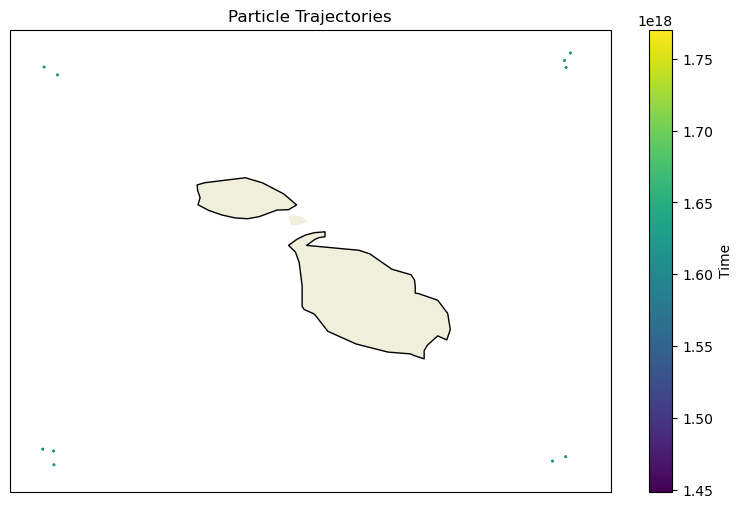

In [11]:
# Load the simulation output
ds = xr.open_zarr("debris_simulation_output.zarr")

# Define the geographic boundaries
extent = [13.9, 14.81, 35.6, 36.3]

# Create a GeoAxes with the PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)

# Add land, coastlines, and the border of the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the particle trajectories
scatter = ax.scatter(ds.lon, ds.lat, s=1, c=ds.time, cmap='viridis', marker='o', transform=ccrs.PlateCarree())

# Add a colorbar and labels
cbar = plt.colorbar(scatter, ax=ax, label='Time')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Particle Trajectories')

plt.show()